In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import datetime as dt
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from imblearn.over_sampling import SMOTE
import lightgbm as lgb


from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay,accuracy_score
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings("ignore")
import pickle

In [2]:
data=pd.read_excel("data.xlsx")
data.head()

Client Unnamed: 1 Unnamed: 2             Contract  \
0            NaN        NaN        NaN                  NaN   
1            CNP     Gender        Age         DataSemnarii   
2  1900226063350          M         32  2021-10-15 18:37:54   
3  1900226063350          M         32  2021-11-06 03:38:12   
4  1811228048420          M         41  2021-10-15 10:43:41   

            Unnamed: 4  Unnamed: 5 Unnamed: 6   Unnamed: 7 Unnamed: 8  \
0                  NaN         NaN        NaN          NaN        NaN   
1           DataInchis      Number     Produs  CreditLimit      State   
2  2021-10-16 18:11:03  DK53851057    Penguin         1900     Inchis   
3  2021-12-10 12:29:02  TC42768422    Penguin          700     Inchis   
4  2022-01-14 16:20:02  HP51173676    Penguin         2000     Inchis   

               Scoring  ...         Unnamed: 21         Unnamed: 22  \
0                  NaN  ...                 NaN                 NaN   
1          scoringdate  ...  PenguinIgnoringBNR  DolphinIgnoringBNR   
2  2021-10-15 00:31:13  ...                   0                   0   
3  2021-10-15 00:31:13  ...                   0                   0   
4  2021-10-15 07:34:50  ...                   0                   0   

      Unnamed: 23 Unnamed: 24  Collection     Unnamed: 26 Unnamed: 27  \
0             NaN         NaN         NaN             NaN         NaN   
1  ClientCategory   Comission  Withdrawed  DpdDiffDaysMax    DpdTotal   
2               0           0       -1900             -27           0   
3               0           0        -700             -22           0   
4               0           0       -2000               3           0   

  Unnamed: 28  Unnamed: 29          Computed  
0         NaN          NaN               NaN  
1   PaidTotal  FutureTotal  IsDerrogationBNR  
2     1907.56            0               NaN  
3      783.58            0               NaN  
4     2239.08            0               NaN  

[5 rows x 31 columns]

In [3]:
data.columns = data.iloc[1]

In [4]:
df=data.drop([0,1], inplace=False)
df=df.reset_index()
df=df.drop(df.columns[0],axis=1)

In [128]:
df_new=data.drop([0,1], inplace=False)
df_new=df_new.reset_index()
df_new=df_new.drop(df.columns[0],axis=1)

In [5]:
df=df.drop(['CNP','Number'],axis=1)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12516 entries, 0 to 12515
Data columns (total 29 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Gender              12516 non-null  object
 1   Age                 12516 non-null  object
 2   DataSemnarii        12516 non-null  object
 3   DataInchis          6827 non-null   object
 4   Produs              12516 non-null  object
 5   CreditLimit         12516 non-null  object
 6   State               12516 non-null  object
 7   scoringdate         12516 non-null  object
 8   score               12516 non-null  object
 9   ProbabilityOfModel  12516 non-null  object
 10  DeclIncome          12516 non-null  object
 11  ANAFIncome          12516 non-null  object
 12  TotalLoanPayments   12516 non-null  object
 13  BNR40Available      12516 non-null  object
 14  CreditsBefore       12516 non-null  object
 15  OfferCrab           12516 non-null  object
 16  OfferPenguin        12

In [7]:
df.isnull().sum()

1
Gender                    0
Age                       0
DataSemnarii              0
DataInchis             5689
Produs                    0
CreditLimit               0
State                     0
scoringdate               0
score                     0
ProbabilityOfModel        0
DeclIncome                0
ANAFIncome                0
TotalLoanPayments         0
BNR40Available            0
CreditsBefore             0
OfferCrab                 0
OfferPenguin              0
OfferDolphin              0
CrabIgnoringBNR           0
PenguinIgnoringBNR        0
DolphinIgnoringBNR        0
ClientCategory            0
Comission                 0
Withdrawed                0
DpdDiffDaysMax            0
DpdTotal                  0
PaidTotal                 0
FutureTotal               0
IsDerrogationBNR      11405
dtype: int64

In [8]:
df.duplicated().sum()

0

In [9]:
print(data['Gender'].value_counts())
print(df['Gender'].value_counts())

M         8327
F         4189
Gender       1
Name: Gender, dtype: int64
M    8327
F    4189
Name: Gender, dtype: int64


In [10]:
df['DataInchis']=pd.to_datetime(df['DataInchis'])
df['DataSemnarii']=pd.to_datetime(df['DataSemnarii'])
df['scoringdate']=pd.to_datetime(df['scoringdate'])

In [11]:
numeric_columns=['Age','CreditLimit','score','ProbabilityOfModel','DeclIncome','ANAFIncome','TotalLoanPayments','BNR40Available',
                 'CreditsBefore','OfferCrab','OfferPenguin','OfferDolphin','CrabIgnoringBNR','PenguinIgnoringBNR','DolphinIgnoringBNR',
                 'ClientCategory','Comission','Withdrawed','DpdDiffDaysMax','DpdTotal','PaidTotal','FutureTotal']

In [12]:
for column in numeric_columns:
    df[column]=pd.to_numeric(df[column])

In [13]:
dummy_df = pd.get_dummies(df['Produs'])
df= pd.concat([df, dummy_df], axis=1)
df=df.drop("Produs",axis=1)

In [14]:
object_values=[]
ob_coll=df.select_dtypes(object).columns
for column in ob_coll:
     object_values.append(np.count_nonzero(df[column].value_counts()))

<BarContainer object of 3 artists>

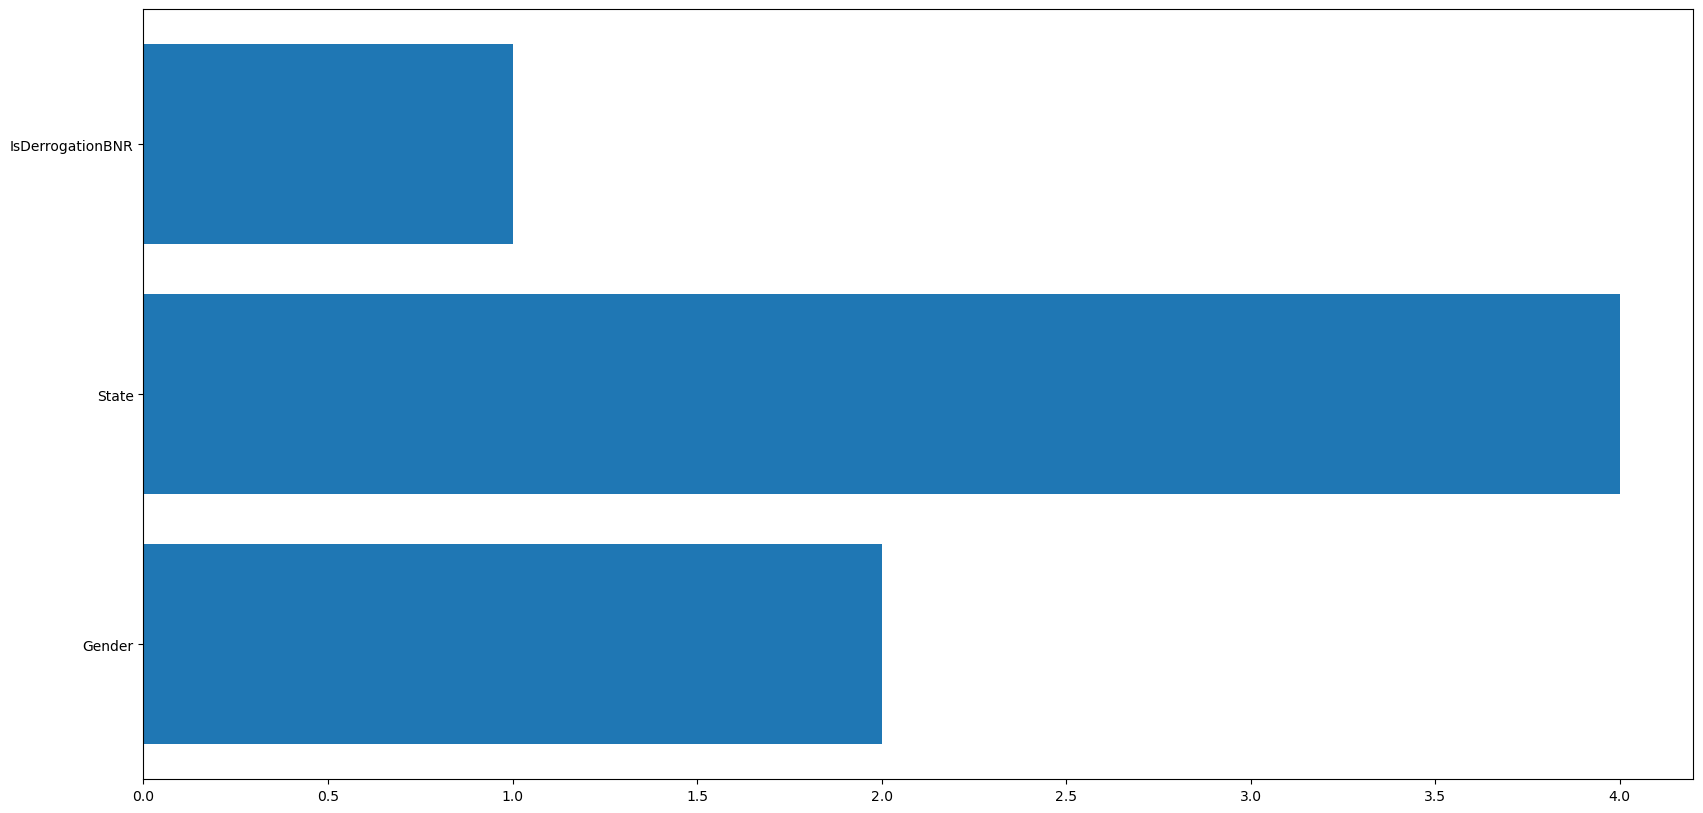

In [15]:
fig = plt.figure(figsize = (20,10))
plt.barh(ob_coll,object_values, label = 'values')

In [16]:
df['IsDerrogationBNR'].value_counts()

True    1111
Name: IsDerrogationBNR, dtype: int64

In [17]:
df['IsDerrogationBNR']=df['IsDerrogationBNR'].fillna(False)

In [18]:
df['State'].value_counts()

Inchis       6827
Activ        5429
Executare     259
Moneysend       1
Name: State, dtype: int64

In [19]:
df = df[df['State'] != 'Moneysend']

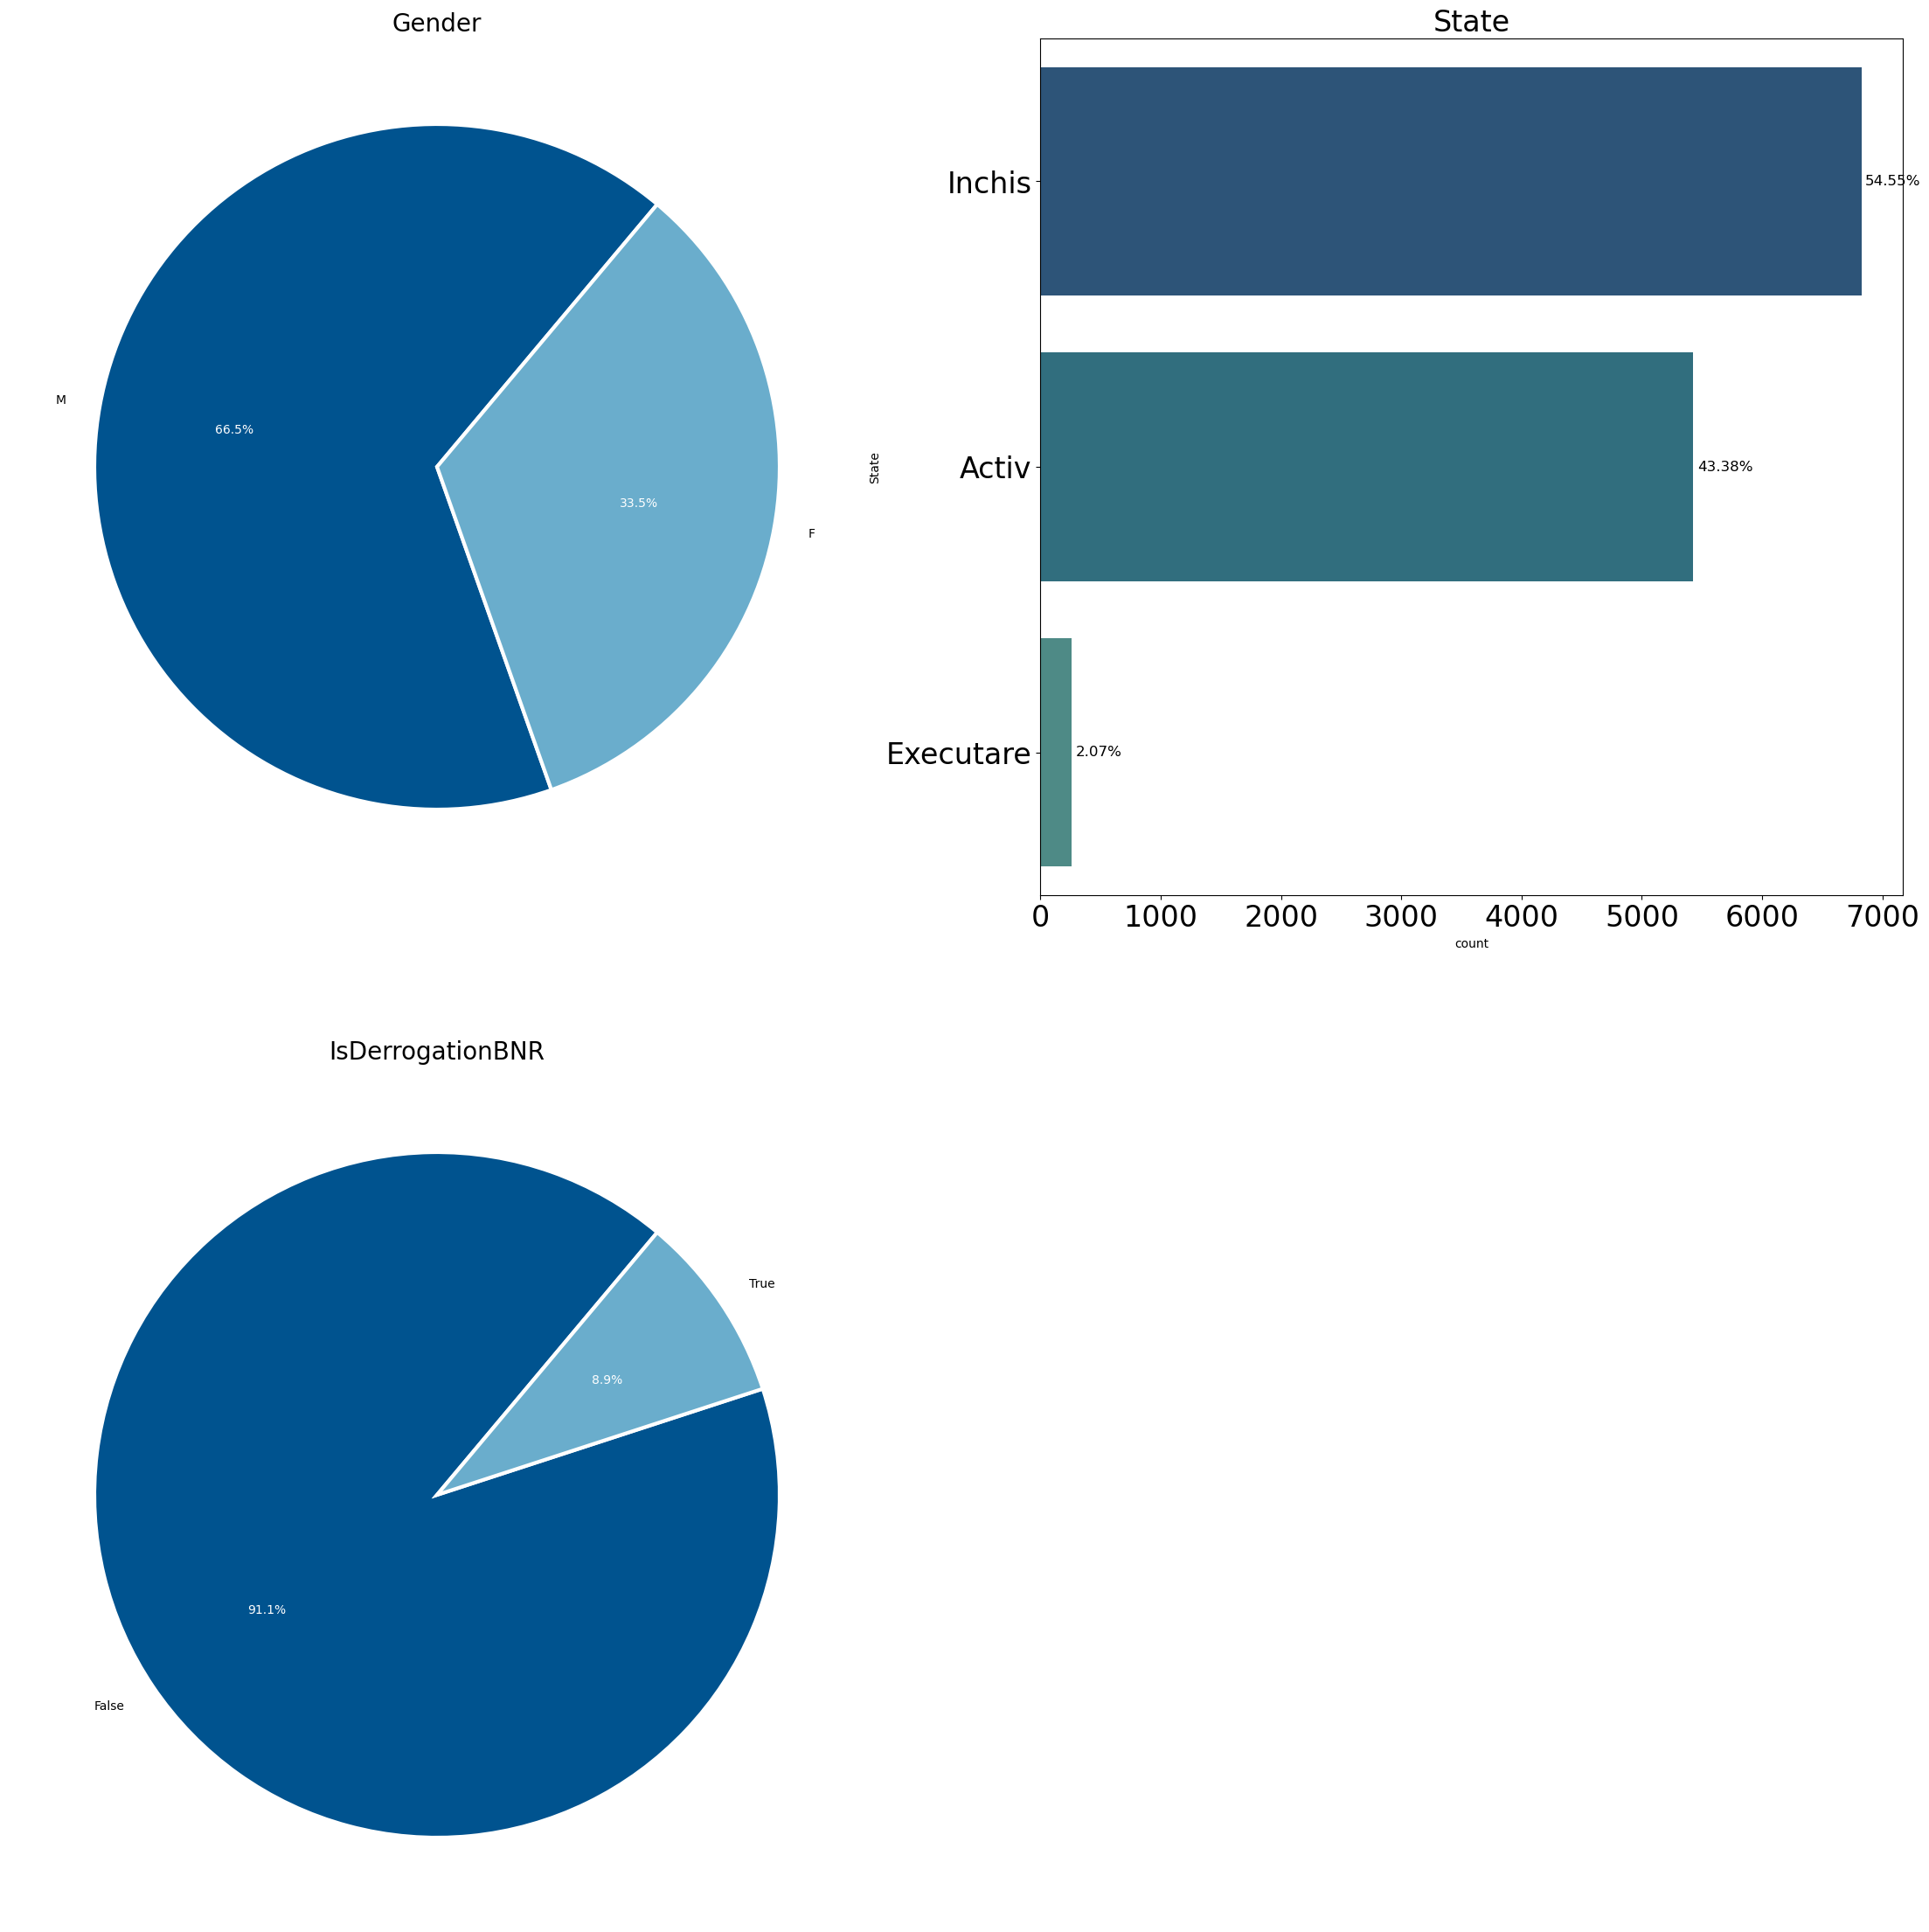

In [20]:
fig, ax = plt.subplots(figsize =(28, 28))
fig.patch.set_facecolor('white')
colors = sns.color_palette("crest_r", n_colors=4).as_hex()

for i in (enumerate(ob_coll)):
    plt.subplot(2, 2, i[0]+1)
    plt.xticks(fontsize=24)
    plt.yticks(fontsize=24)
    
    if df[i[1]].value_counts().count() > 2:
        ax = sns.countplot(y = i[1], data = df, order=df[i[1]].value_counts().index, palette=colors)
        pct = df[i[1]].value_counts(ascending=False, normalize=True).values * 100
        ax.bar_label(container=ax.containers[0], labels=list(map('{:.2f}%'.format,pct)), padding=3, size=12, color='black')
        ax.grid(False)
        plt.title(i[1], fontsize=24, color='black')
        

    else:
        _, texts, pcts = plt.pie(
            df[i[1]].value_counts(), 
            labels=df[i[1]].value_counts().index, 
            colors= ['#00538F', '#6AADCC'],
            autopct='%1.1f%%', 
            wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'},
            startangle=50)
        for pcts in pcts:
          pcts.set_color('white')
        plt.title(i[1], fontsize=20, color='black')
        plt.xticks(fontsize=24)
        plt.yticks(fontsize=24)


plt.show()  

In [21]:
# # Select numerical variables
# numeric = df.select_dtypes(exclude=object).columns
# fig, ax = plt.subplots(figsize =(20, 65))
# fig.patch.set_facecolor('white')
# colors = sns.color_palette("dark", n_colors=30).as_hex()

# for i in (enumerate(numeric)):
#     plt.subplot(20, 2, i[0]+1)
#     sns.kdeplot(x = i[1], data = df, color=colors[i[0]], fill=True)
#     plt.grid()
# plt.show

In [22]:
df.columns

Index(['Gender', 'Age', 'DataSemnarii', 'DataInchis', 'CreditLimit', 'State',
       'scoringdate', 'score', 'ProbabilityOfModel', 'DeclIncome',
       'ANAFIncome', 'TotalLoanPayments', 'BNR40Available', 'CreditsBefore',
       'OfferCrab', 'OfferPenguin', 'OfferDolphin', 'CrabIgnoringBNR',
       'PenguinIgnoringBNR', 'DolphinIgnoringBNR', 'ClientCategory',
       'Comission', 'Withdrawed', 'DpdDiffDaysMax', 'DpdTotal', 'PaidTotal',
       'FutureTotal', 'IsDerrogationBNR', 'Crab', 'Dolphin', 'Penguin'],
      dtype='object')

#### By federal law, a late payment cannot be reported to the credit reporting bureaus until it is at least 30 days past due. An overlooked bill won't hurt your credit as long as you pay before the 30-day mark, although you may have to pay a late fee

## How many days can you be late on a payment?

### 30days 

https://www.equifax.com/personal/education/credit-cards/when-late-credit-card-payments-post/#:~:text=Generally%20speaking%2C%20the%20reporting%20date,are%2060%20days%20past%20due.

In [23]:
df.loc[(df['DpdDiffDaysMax'] > 30)& (df['IsDerrogationBNR'] ==False), ['Withdrawed', 'DpdDiffDaysMax', 'DpdTotal', 'PaidTotal',
       'FutureTotal', 'IsDerrogationBNR','State']]
# y_pinguin = df_total.loc[df_total['Produs'] == 2, 'State']
# y_delfin=df_total.loc[df_total['Produs'] == 1, 'State']

Withdrawed  DpdDiffDaysMax  DpdTotal  PaidTotal  FutureTotal  \
8        -2500.00             280  -3020.66     135.35         0.00   
10       -2100.00              64      0.00    2487.47         0.00   
19       -6000.00             273 -10028.67     671.11         0.00   
21       -3000.00             303  -5406.78      10.00         0.00   
28       -3652.21             211  -5337.73    1083.21         0.00   
...           ...             ...       ...        ...          ...   
10227     -500.00              39   -250.24     179.03       208.06   
10253    -1200.00              38  -1065.36       0.00       499.36   
10316    -1000.00              35   -880.27       0.00       416.14   
10393    -2000.00              31  -1740.51       0.00       832.26   
10413    -2200.00              31  -1904.55      10.00       915.50   

       IsDerrogationBNR      State  
8                 False  Executare  
10                False     Inchis  
19                False  Executare  
21                False  Executare  
28                False  Executare  
...                 ...        ...  
10227             False      Activ  
10253             False      Activ  
10316             False      Activ  
10393             False      Activ  
10413             False      Activ  

[1355 rows x 7 columns]

### Dupa ce in primul notebook  am incercat sa transform coloana 'State' in target unde clienti riscanti fiind persoanele ale caror credit era in executare, iar cel inchis fiind client bun, am constientizat ca am realizat o greseala,deoare sunt si persoane ale caror credit este inchis, dar au trecut limita de 90 de zile la achitare

### De data aceasta ca clienti riscanti, vor fi cei care au creditul in executare,sau au trecut limita maxima cu 30 de zile,(contractul sa fie minim de 60 de zile,aceasta durata se va calcula din data maxima prezenta in coloana de inchidere, minus data de semnare la credit activ

In [24]:
max_datetime = df['DataInchis'].max()
df.loc[df['DataInchis'].isnull() , 'durata_contract']=(max_datetime - df['DataSemnarii']).dt.days
df.loc[df['DataInchis'].notnull() , 'durata_contract']=(df['DataInchis'] - df['DataSemnarii']).dt.days

### Am calculat durata contractului
#### Nu mai avem nevoie de datetime-uri


## Selectam clientii riscanti

In [25]:
df.loc[df['DpdDiffDaysMax'] > 30]

Gender  Age        DataSemnarii          DataInchis  CreditLimit  \
8          M   34 2021-10-28 17:10:08                 NaT         2500   
10         M   28 2021-10-15 11:56:24 2022-01-15 06:35:03         2100   
19         M   44 2021-10-28 11:00:39                 NaT         6000   
21         M   27 2021-10-15 15:05:16                 NaT         3000   
28         M   24 2021-10-25 14:31:14                 NaT         3000   
...      ...  ...                 ...                 ...          ...   
10227      M   20 2022-06-26 17:18:41                 NaT          500   
10253      F   31 2022-06-27 15:21:35                 NaT         1200   
10316      M   42 2022-06-30 11:25:56                 NaT         1000   
10393      M   31 2022-07-04 16:20:49                 NaT         2000   
10413      M   28 2022-07-04 15:34:02                 NaT         2200   

           State         scoringdate  score  ProbabilityOfModel  DeclIncome  \
8      Executare 2021-10-15 09:29:52    472              0.0632        3000   
10        Inchis 2021-10-15 11:53:19    506              0.9036        5600   
19     Executare 2021-10-15 14:14:12    584              0.8490        5500   
21     Executare 2021-10-15 14:29:52    494              0.9326        3560   
28     Executare 2021-10-15 17:31:41    513              0.9371        2150   
...          ...                 ...    ...                 ...         ...   
10227      Activ 2022-06-26 17:14:50    501              0.0161        2500   
10253      Activ 2022-06-27 11:34:43    536              0.8189        1500   
10316      Activ 2022-06-29 15:45:41    540              0.9988        2700   
10393      Activ 2022-07-02 10:41:23    479              0.9546        2500   
10413      Activ 2022-07-03 21:42:07    471              0.0003        4692   

       ...  Withdrawed  DpdDiffDaysMax  DpdTotal  PaidTotal  FutureTotal  \
8      ...    -2500.00             280  -3020.66     135.35         0.00   
10     ...    -2100.00              64      0.00    2487.47         0.00   
19     ...    -6000.00             273 -10028.67     671.11         0.00   
21     ...    -3000.00             303  -5406.78      10.00         0.00   
28     ...    -3652.21             211  -5337.73    1083.21         0.00   
...    ...         ...             ...       ...        ...          ...   
10227  ...     -500.00              39   -250.24     179.03       208.06   
10253  ...    -1200.00              38  -1065.36       0.00       499.36   
10316  ...    -1000.00              35   -880.27       0.00       416.14   
10393  ...    -2000.00              31  -1740.51       0.00       832.26   
10413  ...    -2200.00              31  -1904.55      10.00       915.50   

       IsDerrogationBNR  Crab  Dolphin  Penguin  durata_contract  
8                 False     0        0        1            308.0  
10                False     0        0        1             91.0  
19                False     0        1        0            309.0  
21                False     0        1        0            322.0  
28                False     0        1        0            312.0  
...                 ...   ...      ...      ...              ...  
10227             False     0        0        1             67.0  
10253             False     0        0        1             67.0  
10316             False     0        0        1             64.0  
10393             False     0        0        1             59.0  
10413             False     0        0        1             60.0  

[1439 rows x 32 columns]

In [136]:
df.loc[(df['IsDerrogationBNR'] ==False) & (df['DpdDiffDaysMax'] >= 30), 'target']=1    

KeyError: 'IsDerrogationBNR'

In [27]:
df.loc[df['DpdDiffDaysMax'] < 30,'target']=0 # clientiti buni

In [28]:
df['target'].value_counts()

0.0    10852
1.0     1544
Name: target, dtype: int64

In [29]:
df.loc[df['target'].isnull(),['Withdrawed', 'DpdDiffDaysMax', 'DpdTotal', 'PaidTotal',
       'FutureTotal', 'IsDerrogationBNR','durata_contract','State']]

Withdrawed  DpdDiffDaysMax  DpdTotal  PaidTotal  FutureTotal  \
5416     -3433.06              30  -2302.00    2709.66          0.0   
5558     -1284.64              30  -1648.00    1234.29          0.0   
5565     -4200.00             122  -6499.29      90.00          0.0   
5570     -1000.00              61  -1616.82     751.18          0.0   
5588     -2200.00              61  -1900.18    1829.42          0.0   
...           ...             ...       ...        ...          ...   
10163    -4000.00              61  -5662.84     187.16          0.0   
10255    -7100.00              30  -8440.00       0.00          0.0   
10335    -1000.00              30  -1708.00       0.00          0.0   
10399    -1000.00              30  -1567.00      10.00          0.0   
10409    -3400.00              30  -4441.00       0.00          0.0   

       IsDerrogationBNR  durata_contract  State  
5416               True            153.0  Activ  
5558               True            156.0  Activ  
5565               True            151.0  Activ  
5570               True            148.0  Activ  
5588               True            147.0  Activ  
...                 ...              ...    ...  
10163              True             70.0  Activ  
10255              True             56.0  Activ  
10335              True             63.0  Activ  
10399              True             62.0  Activ  
10409              True             60.0  Activ  

[119 rows x 8 columns]

### Voi face drop la aceste randuri,deoarece nu reprezinta o informatie care se atribuie concret la client bun sau rau,deoarece sunt unele persoane car au 39 de zile contractul,dar dar intarziere 30 de zile,inseamna ca trebuie rambunsat dupa 9 zile,dar cel mai mic credit,crab,este de 30 de zile, de asta am cautat anterioe,daca contractul e mai lung de 60 de zile,adica 30 de zile pana la data de plata +30 de zile intarziere

#### Facem drop la coloanele datetime,deoarece am extras deja informatia necesara din ele

In [30]:
df=df.drop(['DataInchis','DataSemnarii','scoringdate'],axis=1)

In [31]:
df.isnull().sum()

Gender                  0
Age                     0
CreditLimit             0
State                   0
score                   0
ProbabilityOfModel      0
DeclIncome              0
ANAFIncome              0
TotalLoanPayments       0
BNR40Available          0
CreditsBefore           0
OfferCrab               0
OfferPenguin            0
OfferDolphin            0
CrabIgnoringBNR         0
PenguinIgnoringBNR      0
DolphinIgnoringBNR      0
ClientCategory          0
Comission               0
Withdrawed              0
DpdDiffDaysMax          0
DpdTotal                0
PaidTotal               0
FutureTotal             0
IsDerrogationBNR        0
Crab                    0
Dolphin                 0
Penguin                 0
durata_contract         0
target                119
dtype: int64

In [32]:
df=df.dropna()

In [33]:
df['IsDerrogationBNR'].value_counts()

False    11404
True       992
Name: IsDerrogationBNR, dtype: int64

### Facem drop la aceasta coloana,deoarece la aplicarea pentru credit noi nu stim daca va urma derogare,iar acest lucru poate inrautati antrenarea

In [34]:
df=df.drop('IsDerrogationBNR',axis=1)

### Encodam datele categoriale

In [35]:
object_values=[]
ob_coll=df.select_dtypes(object).columns
for column in ob_coll:
     object_values.append(np.count_nonzero(df[column].value_counts()))

In [36]:
lbl_enc=LabelEncoder()
df[ob_coll]=df[ob_coll].astype(str).apply(lbl_enc.fit_transform)

<AxesSubplot:>

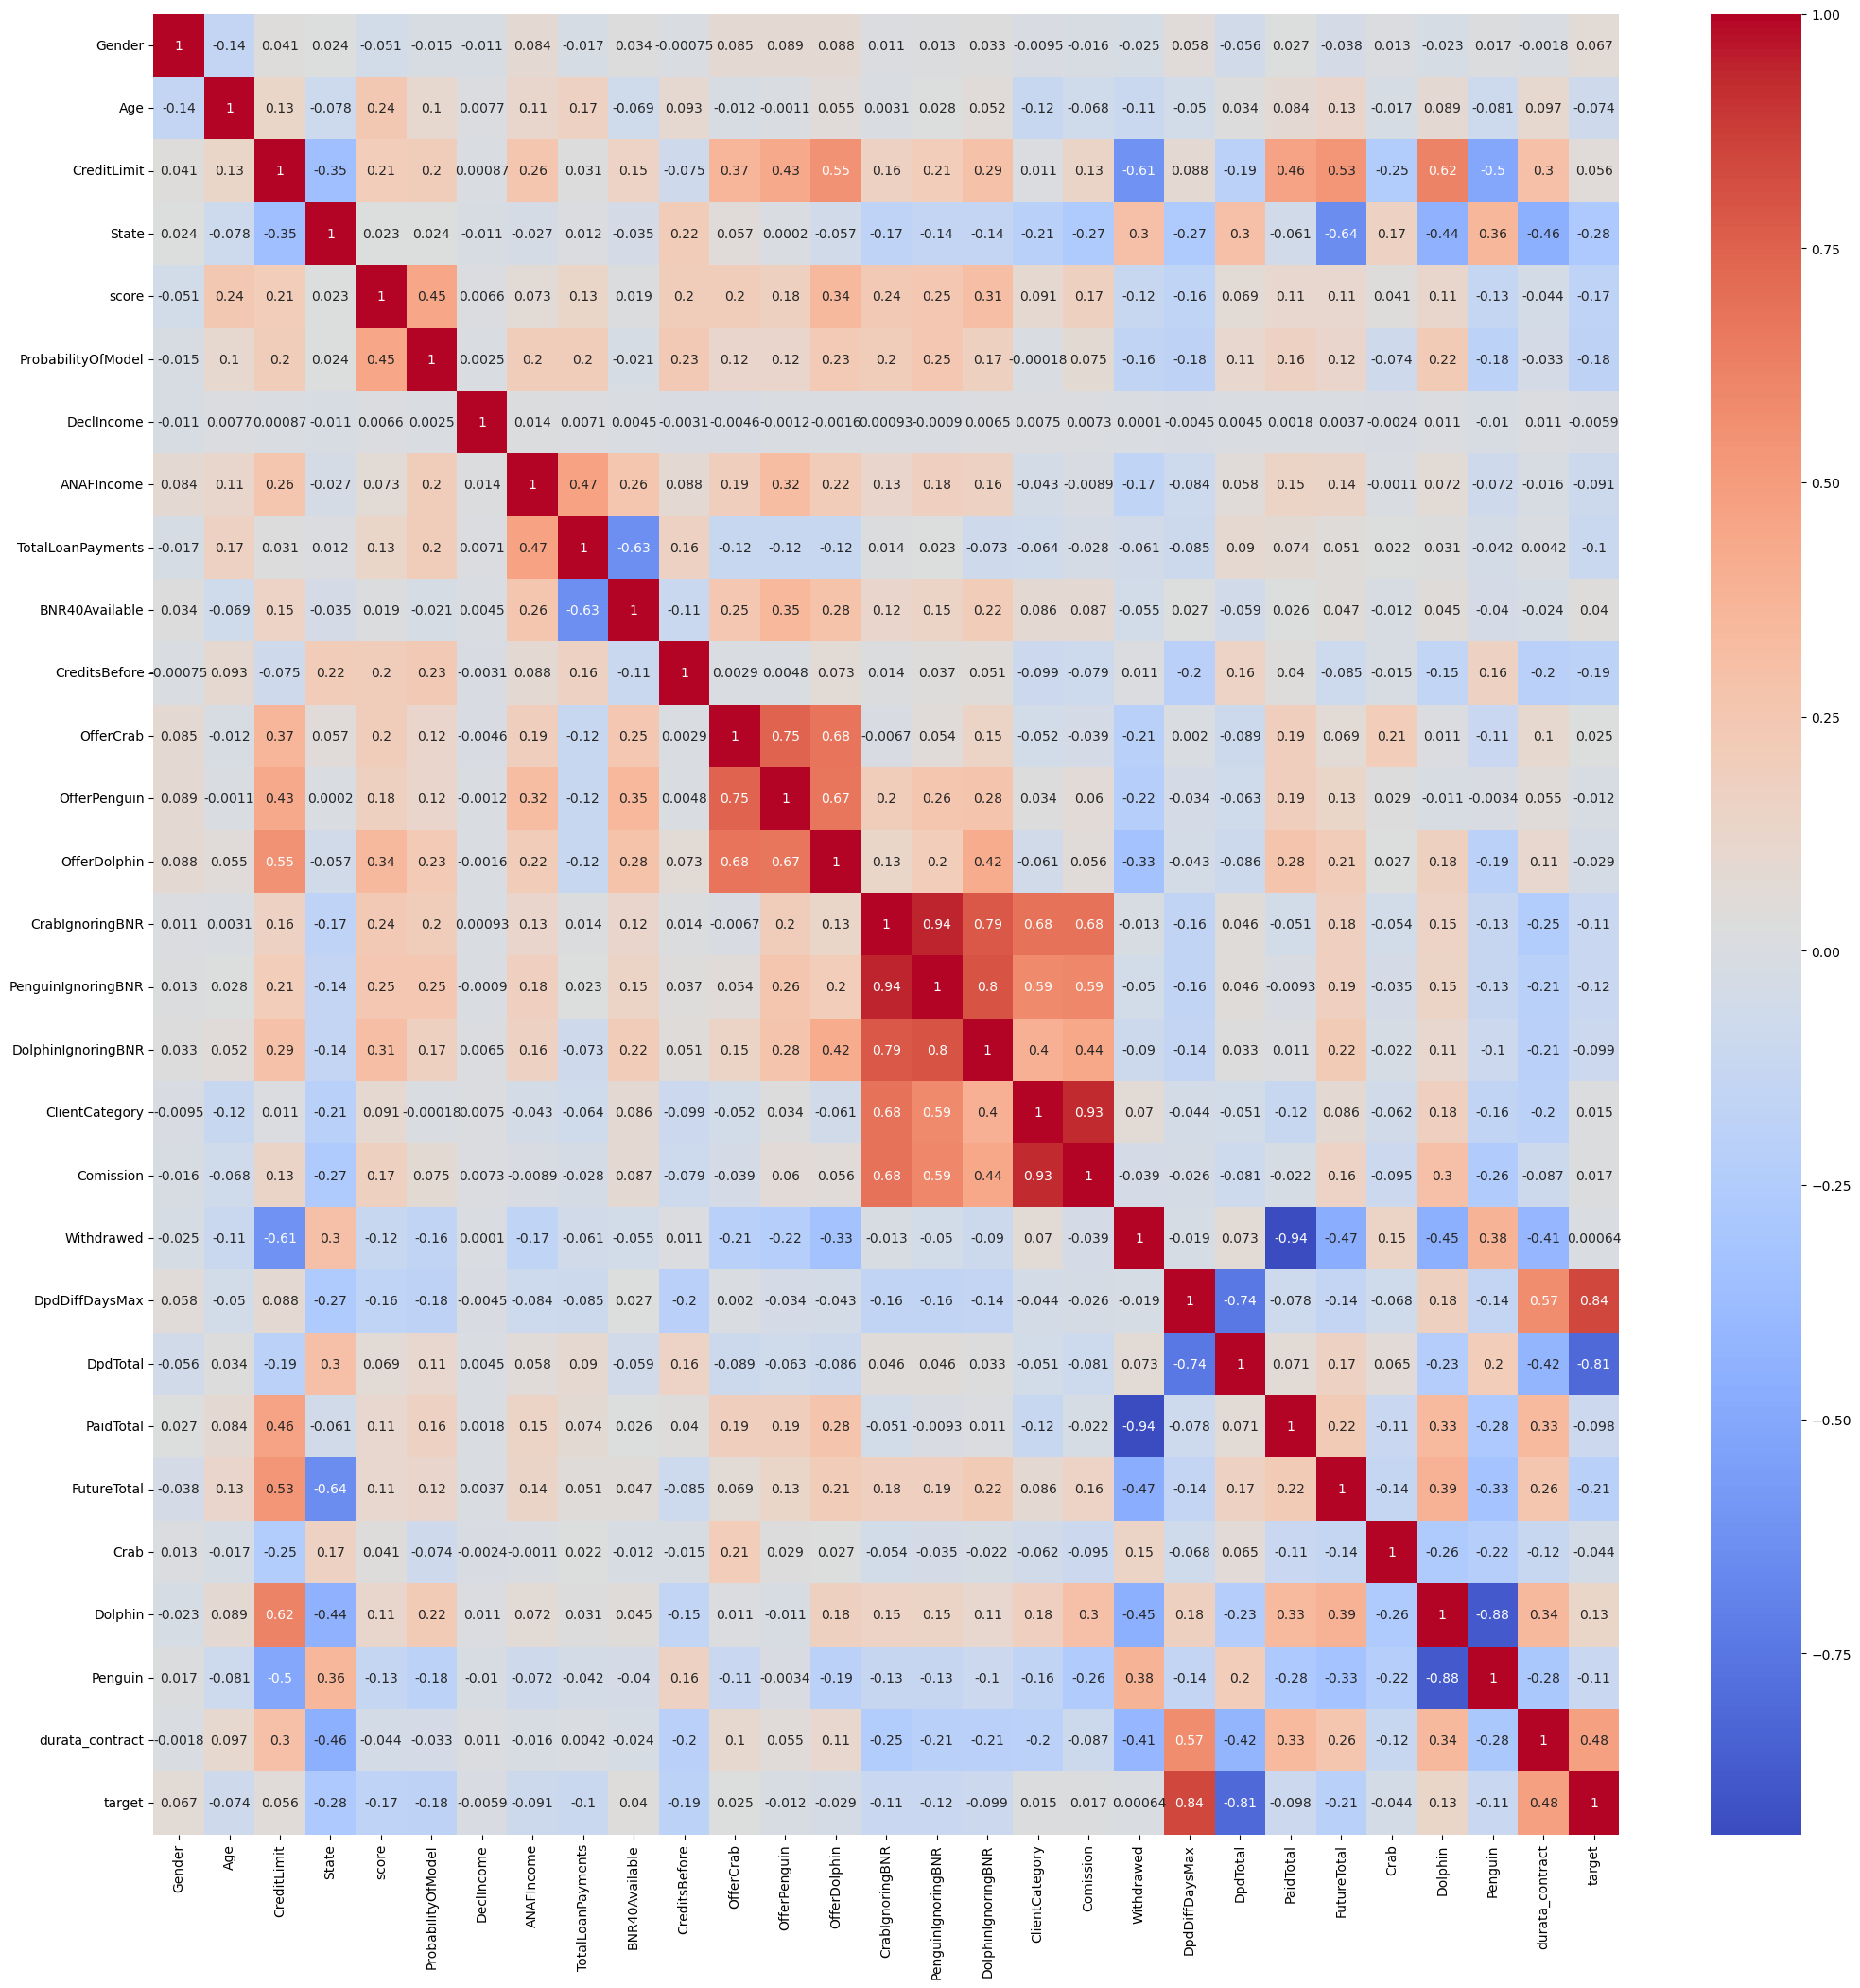

In [37]:
plt.figure(figsize=(25,25))
sns.heatmap(df.corr(),annot=True,cmap='coolwarm')

### Deoarece clientii sunt clasificati in baza intarzierii,vom face drop la coloanele de DPD

In [38]:
df=df.drop(['DpdDiffDaysMax','DpdTotal'],axis=1)

In [39]:
work_df=df

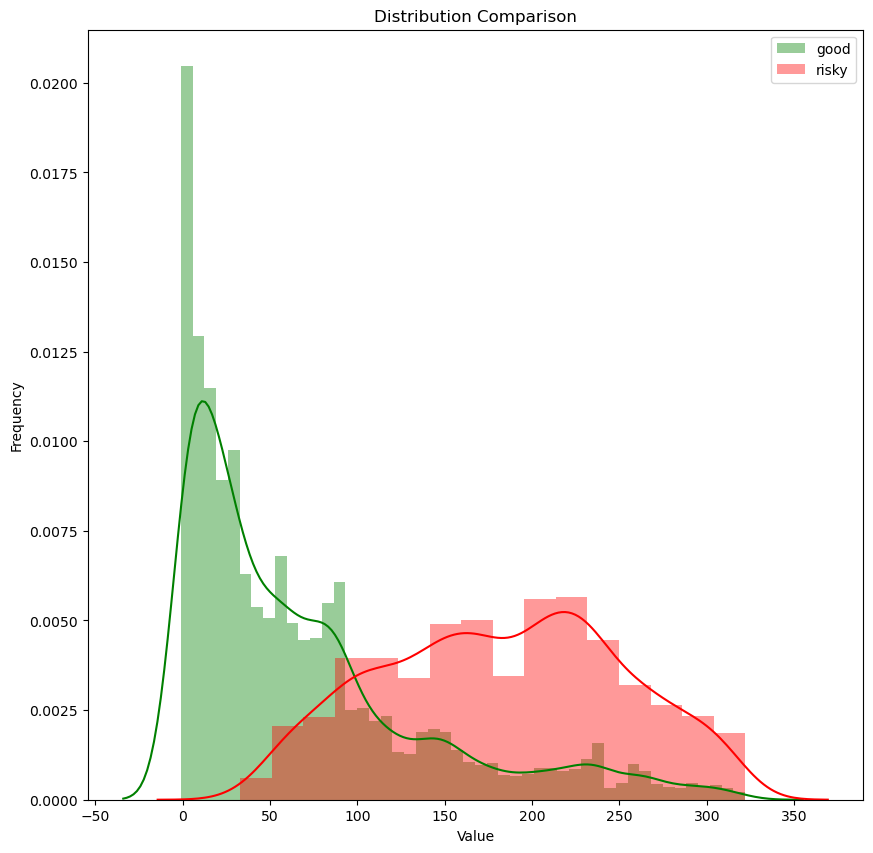

In [40]:
plt.figure(figsize=(10,10))
#sns.kdeplot(df['durata_contract'], shade=True, label='Distribution durata and target')
#sns.kdeplot(df['target'], shade=True, label='Distribution durata and target')
sns.distplot(df['durata_contract'][df['target']==0],color='g', label = 'good')
sns.distplot(df['durata_contract'][df['target']==1],color='r', label = 'risky')
#sns.kdeplot(df['target'], shade=True, label='Distribution durata and target')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Distribution Comparison')
plt.legend()

plt.show()

### Observam ca cu cat durata contractului e mai mare cu atat si numarul de clienti riscanti creste

In [41]:
df.columns

Index(['Gender', 'Age', 'CreditLimit', 'State', 'score', 'ProbabilityOfModel',
       'DeclIncome', 'ANAFIncome', 'TotalLoanPayments', 'BNR40Available',
       'CreditsBefore', 'OfferCrab', 'OfferPenguin', 'OfferDolphin',
       'CrabIgnoringBNR', 'PenguinIgnoringBNR', 'DolphinIgnoringBNR',
       'ClientCategory', 'Comission', 'Withdrawed', 'PaidTotal', 'FutureTotal',
       'Crab', 'Dolphin', 'Penguin', 'durata_contract', 'target'],
      dtype='object')

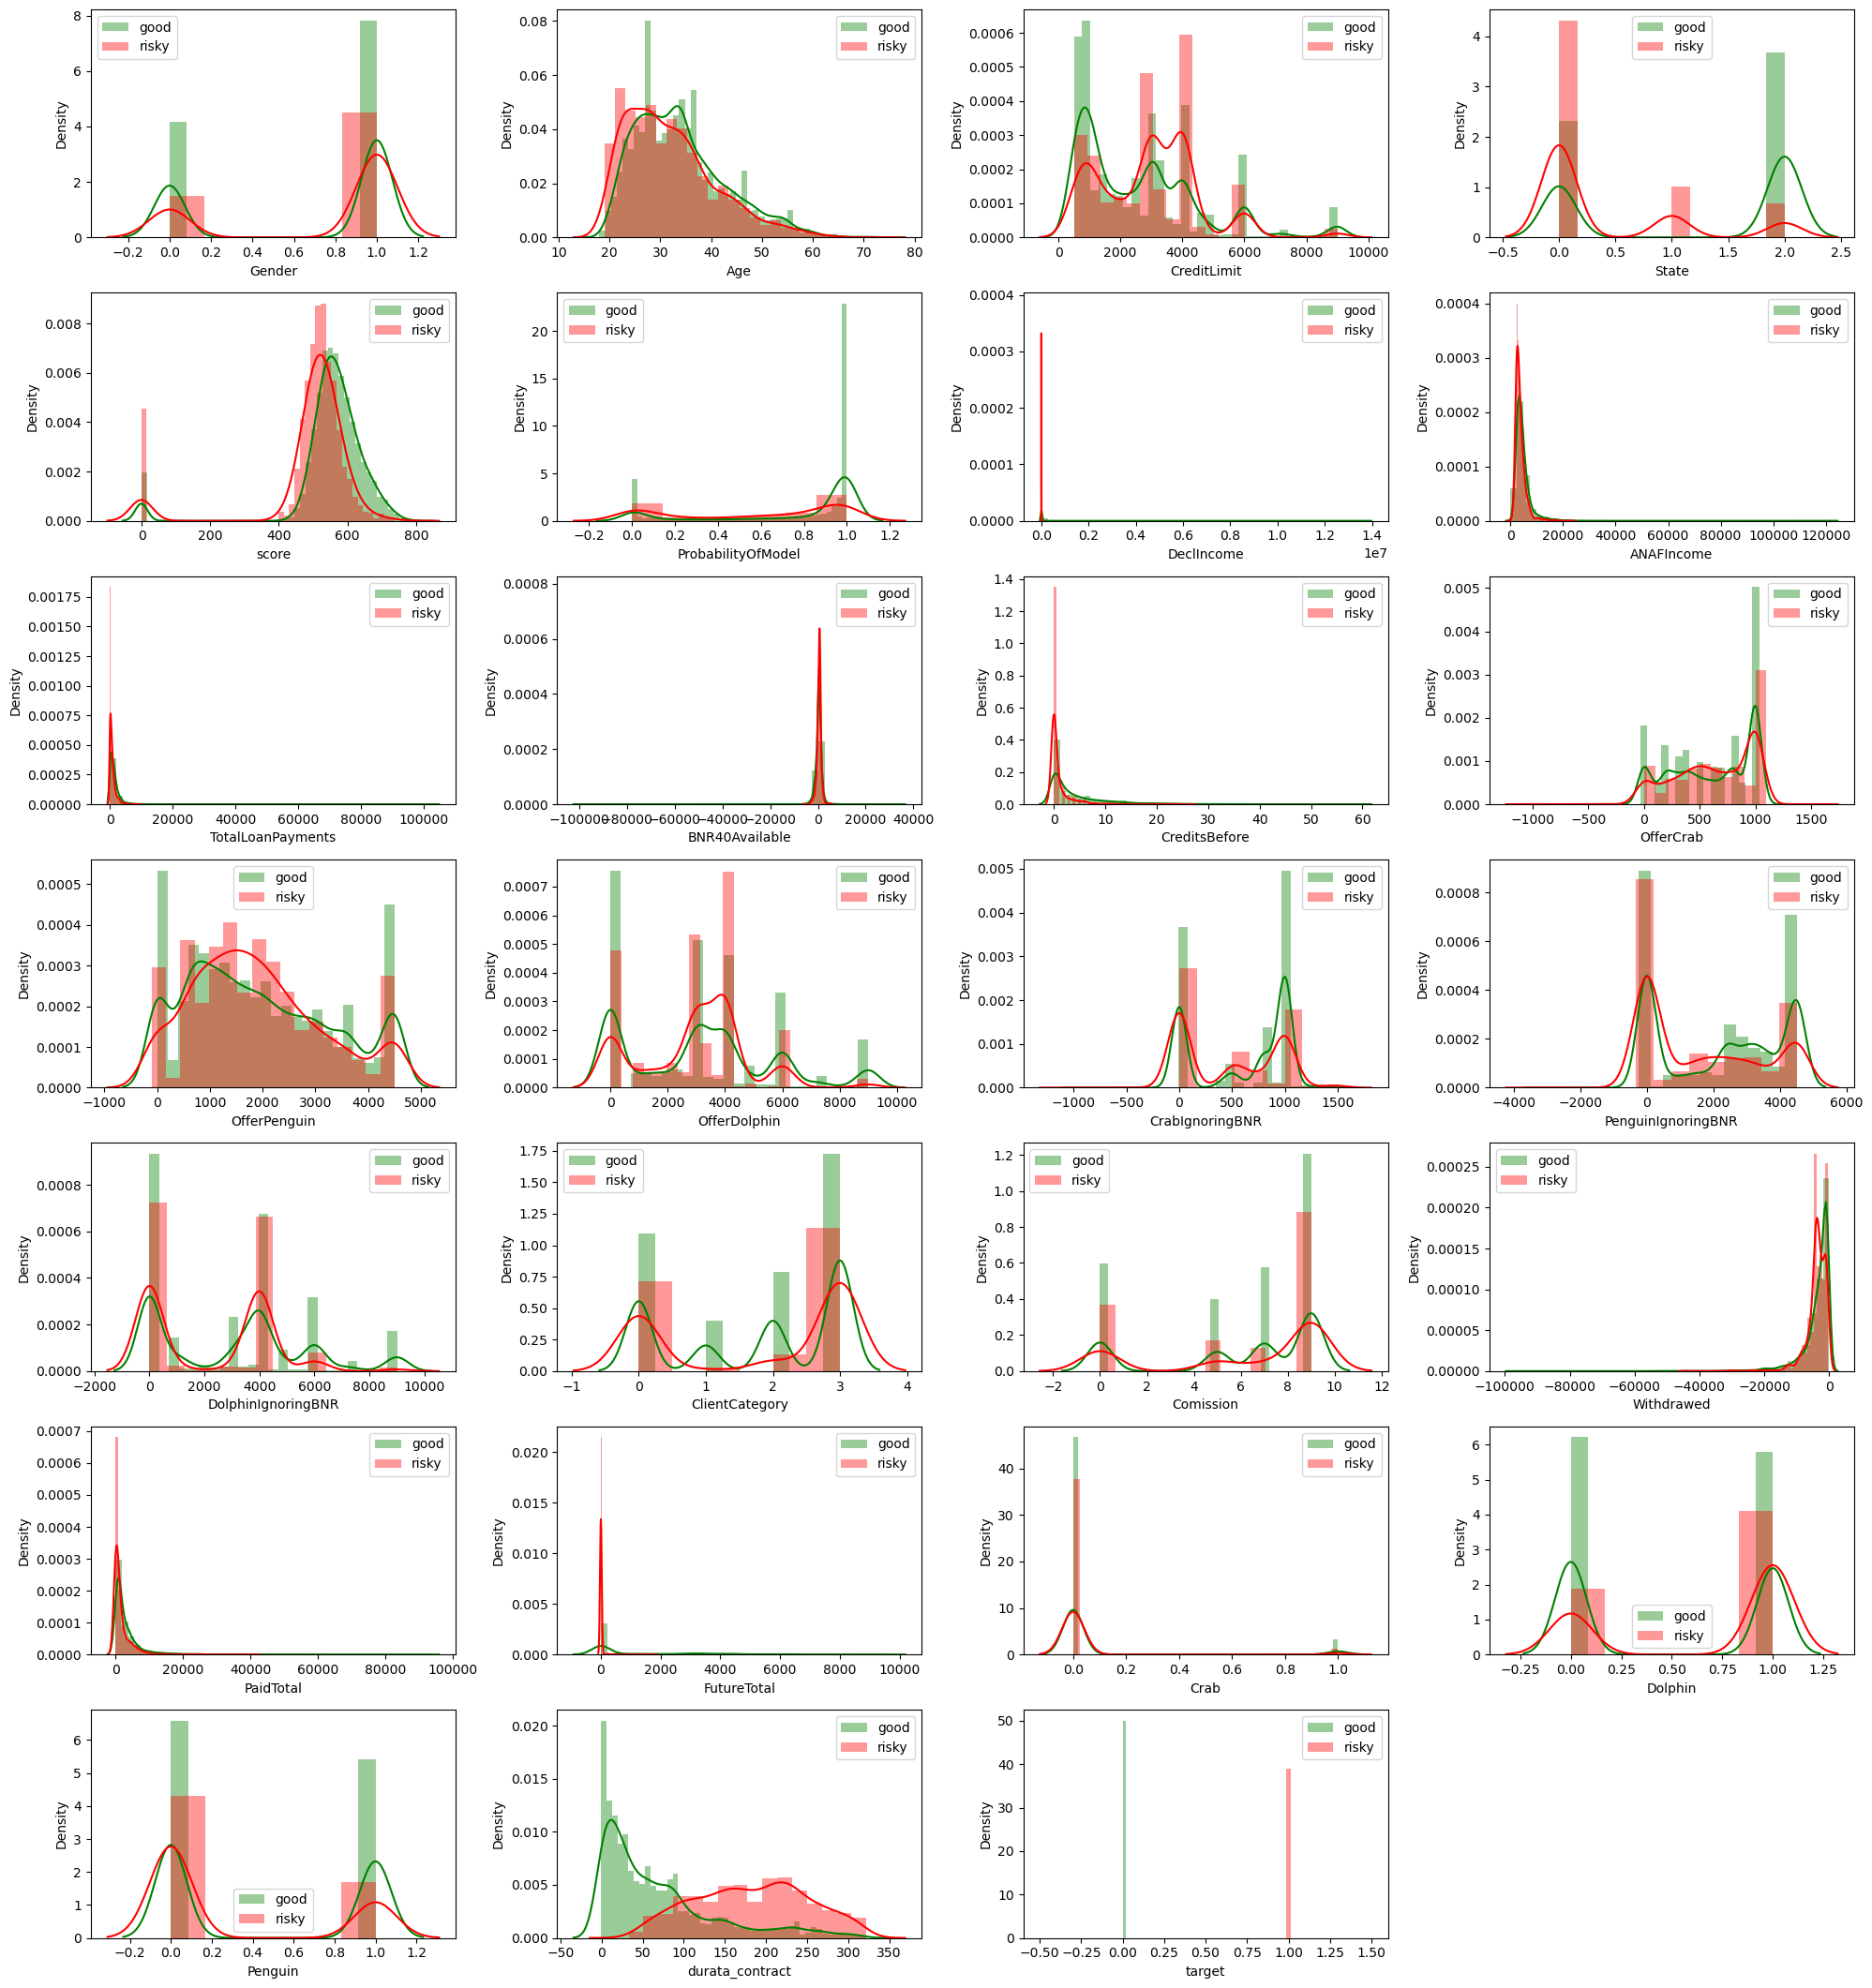

In [42]:
fig = plt.figure(figsize = (20, 25))
j = 0

for column in df:
    plt.subplot(8, 4, j+1)
    j += 1
    sns.distplot(df[column][df['target']==0],color='g', label = 'good')
    sns.distplot(df[column][df['target']==1],color='r', label = 'risky')
    plt.legend(loc='best')
fig.tight_layout()
fig.subplots_adjust(top=0.95)
plt.show()

### Vom crea 3 modele, pentru fiecare produs cate unul,mai intai cream pentru produsul 
# 🦀 Crab
### Incepem sa pregatim datele

In [43]:
df_crab=df.loc[df['Crab']==1]
df_crab=df_crab.drop(['Dolphin','Penguin','Crab'],axis=1)
df_delfin=df.loc[df['Dolphin']==1]
df_delfin=df_delfin.drop(['Dolphin','Penguin','Crab'],axis=1)
df_pinguin=df.loc[df['Penguin']==1]
df_pinguin=df_pinguin.drop(['Dolphin','Penguin','Crab'],axis=1)

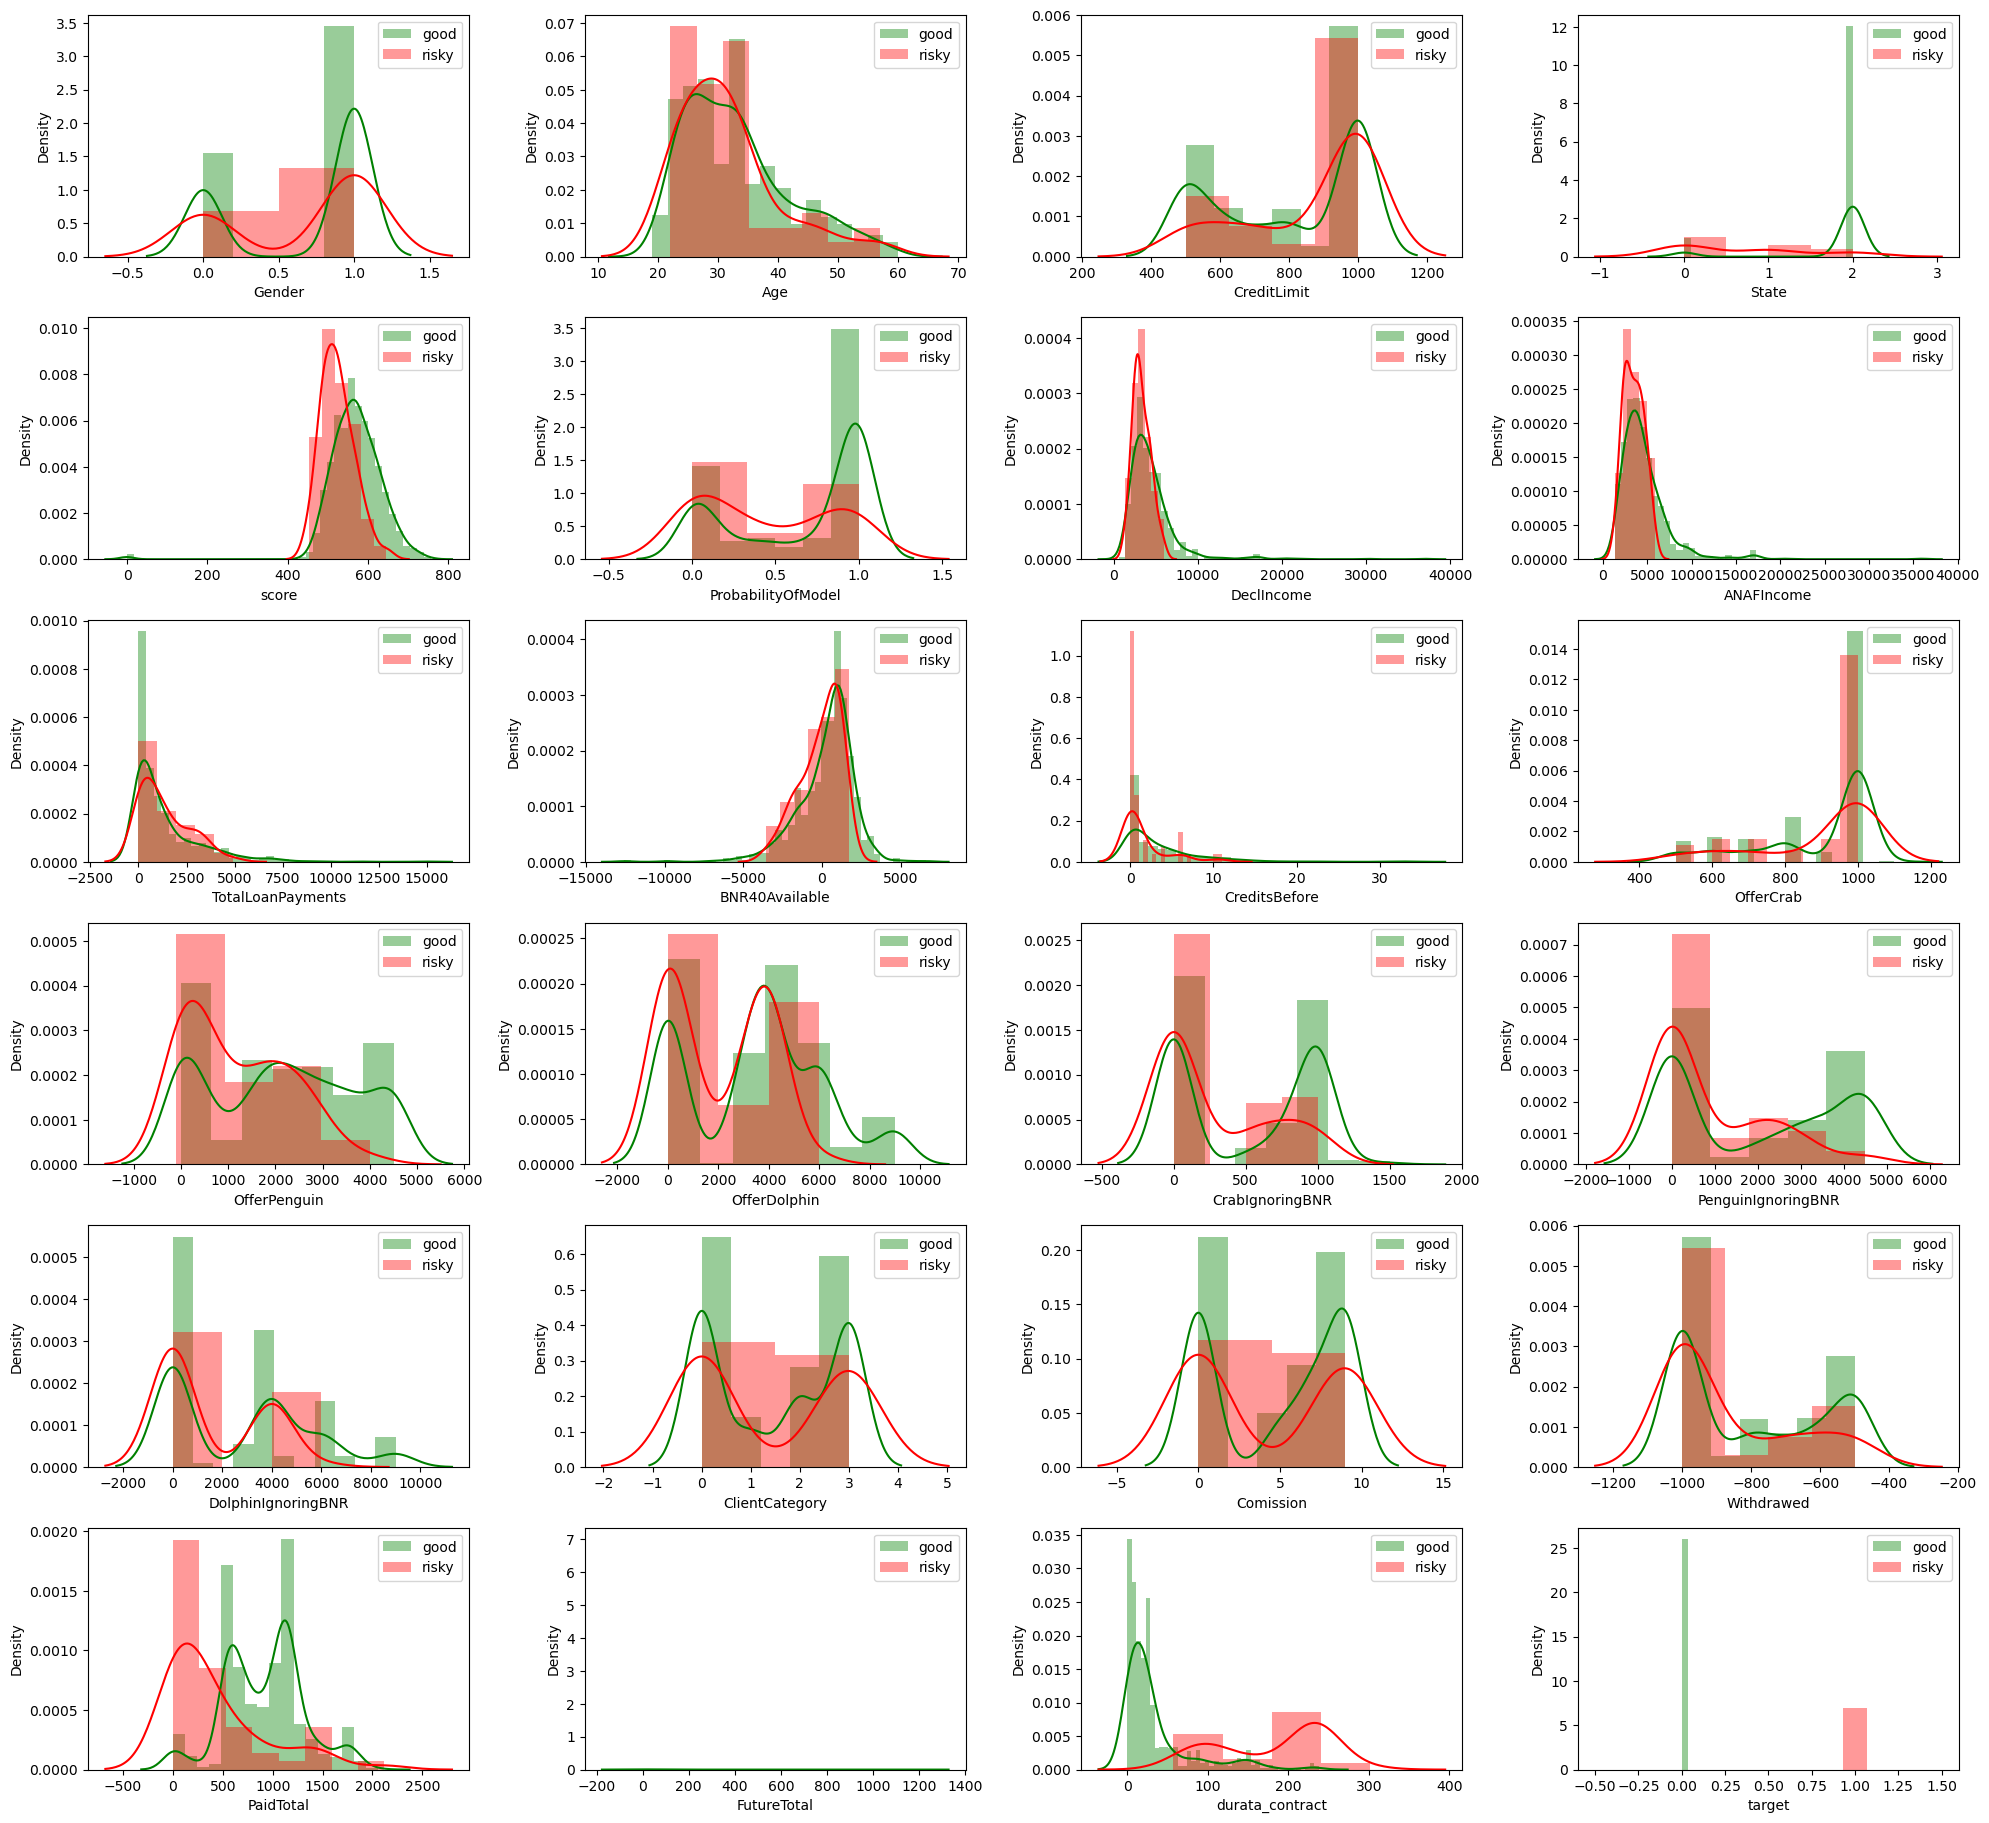

In [44]:
fig = plt.figure(figsize = (20, 25))
j = 0

for column in df_crab:
    plt.subplot(8, 4, j+1)
    j += 1
    sns.distplot(df_crab[column][df_crab['target']==0],color='g', label = 'good')
    sns.distplot(df_crab[column][df_crab['target']==1],color='r', label = 'risky')
    plt.legend(loc='best')
fig.tight_layout()
fig.subplots_adjust(top=0.95)
plt.show()

In [45]:
y_crab=df_crab['target']
X_crab=df_crab.drop(['State','ProbabilityOfModel', 'OfferPenguin',
       'OfferDolphin','PenguinIgnoringBNR','CrabIgnoringBNR','DolphinIgnoringBNR', 'ClientCategory', 'Comission', 'Withdrawed',
       'PaidTotal', 'FutureTotal', 'durata_contract', 'target','DeclIncome'],axis=1)

In [46]:
X_crab.columns

Index(['Gender', 'Age', 'CreditLimit', 'score', 'ANAFIncome',
       'TotalLoanPayments', 'BNR40Available', 'CreditsBefore', 'OfferCrab'],
      dtype='object')

In [47]:
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler(feature_range =(0, 1))
X_rescaled = min_max_scaler.fit_transform(X_crab)
print ("\nAfter min max Scaling : \n", X_rescaled)


After min max Scaling : 
 [[1.         0.34146341 0.8        ... 0.76363162 0.08823529 0.83333333]
 [0.         0.3902439  0.2        ... 0.72011479 0.         0.83333333]
 [0.         0.34146341 0.8        ... 0.70696582 0.         0.66666667]
 ...
 [1.         0.70731707 0.6        ... 0.7651448  0.14705882 0.5       ]
 [1.         0.04878049 0.2        ... 0.76587529 0.05882353 0.5       ]
 [1.         0.26829268 0.2        ... 0.81721889 0.14705882 0.5       ]]


In [48]:
from sklearn.decomposition import PCA
pca_crab = PCA(n_components = 0.95)
pca_crab.fit(X_rescaled)
X_pca = pca_crab.transform(X_rescaled)

In [49]:
X_pca=pd.DataFrame(X_pca)

In [50]:
X_train,X_test,y_train,y_test=train_test_split(X_pca,y_crab,test_size=0.2,random_state=42)

In [51]:
from imblearn.over_sampling import SMOTE
smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

In [52]:
#X_train,X_test,y_train,y_test=train_test_split(X_resampled,y_resampled,test_size=0.2,random_state=42)

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100

              precision    recall  f1-score   support

         0.0       0.96      0.85      0.90       144
         1.0       0.21      0.55      0.31        11

    accuracy                           0.83       155
   macro avg       0.59      0.70      0.60       155
weighted avg       0.91      0.83      0.86       155



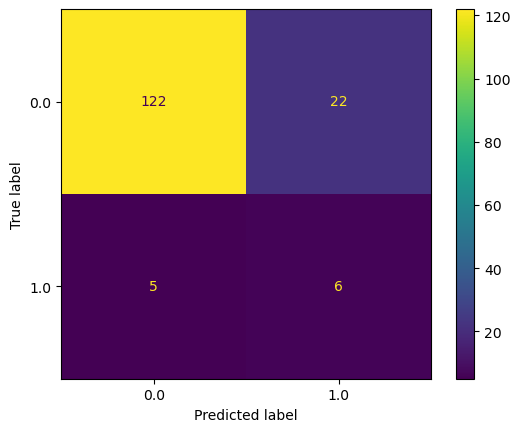

In [53]:
lgb_classifier_crab = lgb.LGBMClassifier(min_data_in_leaf=100,random_state=42)
#model = lgb.train(params, train_data, valid_sets=[val_data])
lgb_classifier_crab.fit(X_resampled, y_resampled)
y_pred = lgb_classifier_crab.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
ConfusionMatrixDisplay.from_predictions(y_test,y_pred)
print("\n"+ classification_report(y_test, y_pred))

# Crabul Gata

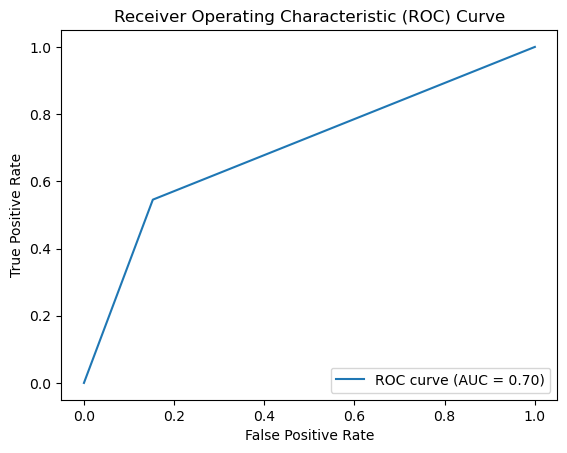

In [54]:
from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)
plt.plot(fpr, tpr, label='ROC curve (AUC = {:.2f})'.format(auc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [55]:
from sklearn.model_selection import cross_validate
def cross_validation(model, _X, _y, _cv=5):
      _scoring = ['accuracy', 'precision', 'recall', 'f1']
      results = cross_validate(estimator=model,
                               X=_X,
                               y=_y,
                               cv=_cv,
                               scoring=_scoring,
                               return_train_score=True)
      
      return {"Training Accuracy scores": results['train_accuracy'],
              "Mean Training Accuracy": results['train_accuracy'].mean()*100,
              "Training Precision scores": results['train_precision'],
              "Mean Training Precision": results['train_precision'].mean(),
              "Training Recall scores": results['train_recall'],
              "Mean Training Recall": results['train_recall'].mean(),
              "Training F1 scores": results['train_f1'],
              "Mean Training F1 Score": results['train_f1'].mean(),
              "Validation Accuracy scores": results['test_accuracy'],
              "Mean Validation Accuracy": results['test_accuracy'].mean()*100,
              "Validation Precision scores": results['test_precision'],
              "Mean Validation Precision": results['test_precision'].mean(),
              "Validation Recall scores": results['test_recall'],
              "Mean Validation Recall": results['test_recall'].mean(),
              "Validation F1 scores": results['test_f1'],
              "Mean Validation F1 Score": results['test_f1'].mean()
              }

In [56]:
def plot_result(x_label, y_label, plot_title, train_data, val_data):
        # Set size of plot
        plt.figure(figsize=(12,6))
        labels = ["1st Fold", "2nd Fold", "3rd Fold", "4th Fold", "5th Fold"]
        X_axis = np.arange(len(labels))
        ax = plt.gca()
        plt.ylim(0.40000, 1)
        plt.bar(X_axis-0.2, train_data, 0.4, color='blue', label='Training')
        plt.bar(X_axis+0.2, val_data, 0.4, color='red', label='Validation')
        plt.title(plot_title, fontsize=30)
        plt.xticks(X_axis, labels)
        plt.xlabel(x_label, fontsize=14)
        plt.ylabel(y_label, fontsize=14)
        plt.legend()
        plt.grid(True)
        plt.show()

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


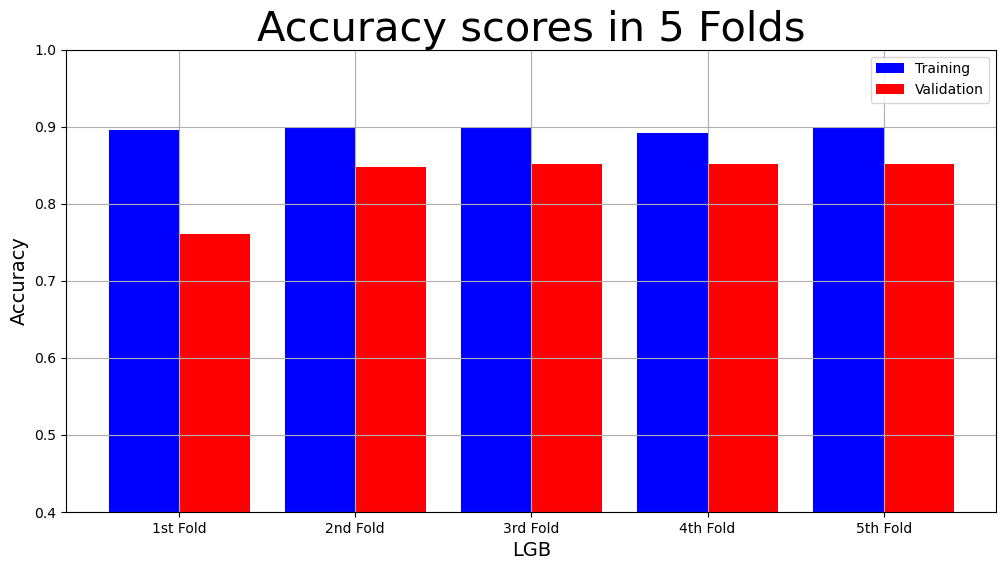

In [57]:
lgb_result = cross_validation(lgb_classifier_crab, X_resampled, y_resampled, 5)
model_name = "LGB"
plot_result(model_name,
            "Accuracy",
            "Accuracy scores in 5 Folds",
            lgb_result["Training Accuracy scores"],
            lgb_result["Validation Accuracy scores"])

# Salvarea modelului

In [58]:
# with open('model_crab.pkl', 'wb') as file:
#     pickle.dump(lgb_classifier_crab, file)

In [59]:
# with open('pca_model_crab.pkl', 'wb') as file:
#     pickle.dump(pca_crab, file)

In [60]:
# from sklearn.pipeline import Pipeline
# from sklearn.preprocessing import MinMaxScaler
# from sklearn.decomposition import PCA
# from imblearn.pipeline import Pipeline as IMBPipeline
# from imblearn.over_sampling import SMOTE
# import lightgbm as lgb

# # Define the pipeline steps
# steps = [
#     ('scaling', MinMaxScaler(feature_range=(0, 1))),
#     ('pca', PCA(n_components=0.95)),
#     ('smote', SMOTE(sampling_strategy=0.5)),  # Adjust the sampling strategy as desired
#     ('model', lgb.LGBMClassifier())
# ]

# # Create the pipeline
# pipeline = IMBPipeline(steps)

# # Fit the pipeline to the data
# pipeline.fit(X_crab, y_crab)

# # Predict using the pipeline
# y_pred = pipeline.predict(X_test)
# ConfusionMatrixDisplay.from_predictions(y_test,y_pred)
# print("\n"+ classification_report(y_test, y_pred))

## Tranformarea datelor de intrare

In [61]:
row=[1,32,1900,589,4980,1283,709,6,600]
row = np.array(row).reshape(1, -1)
row=min_max_scaler.fit_transform(row)
row=pca_crab.transform(row)
lgb_classifier_crab.predict(row)

array([0.])

In [62]:
row

array([[-0.12908952,  1.06467036, -0.27310357, -0.41567907,  0.23329303]])

# Delfin

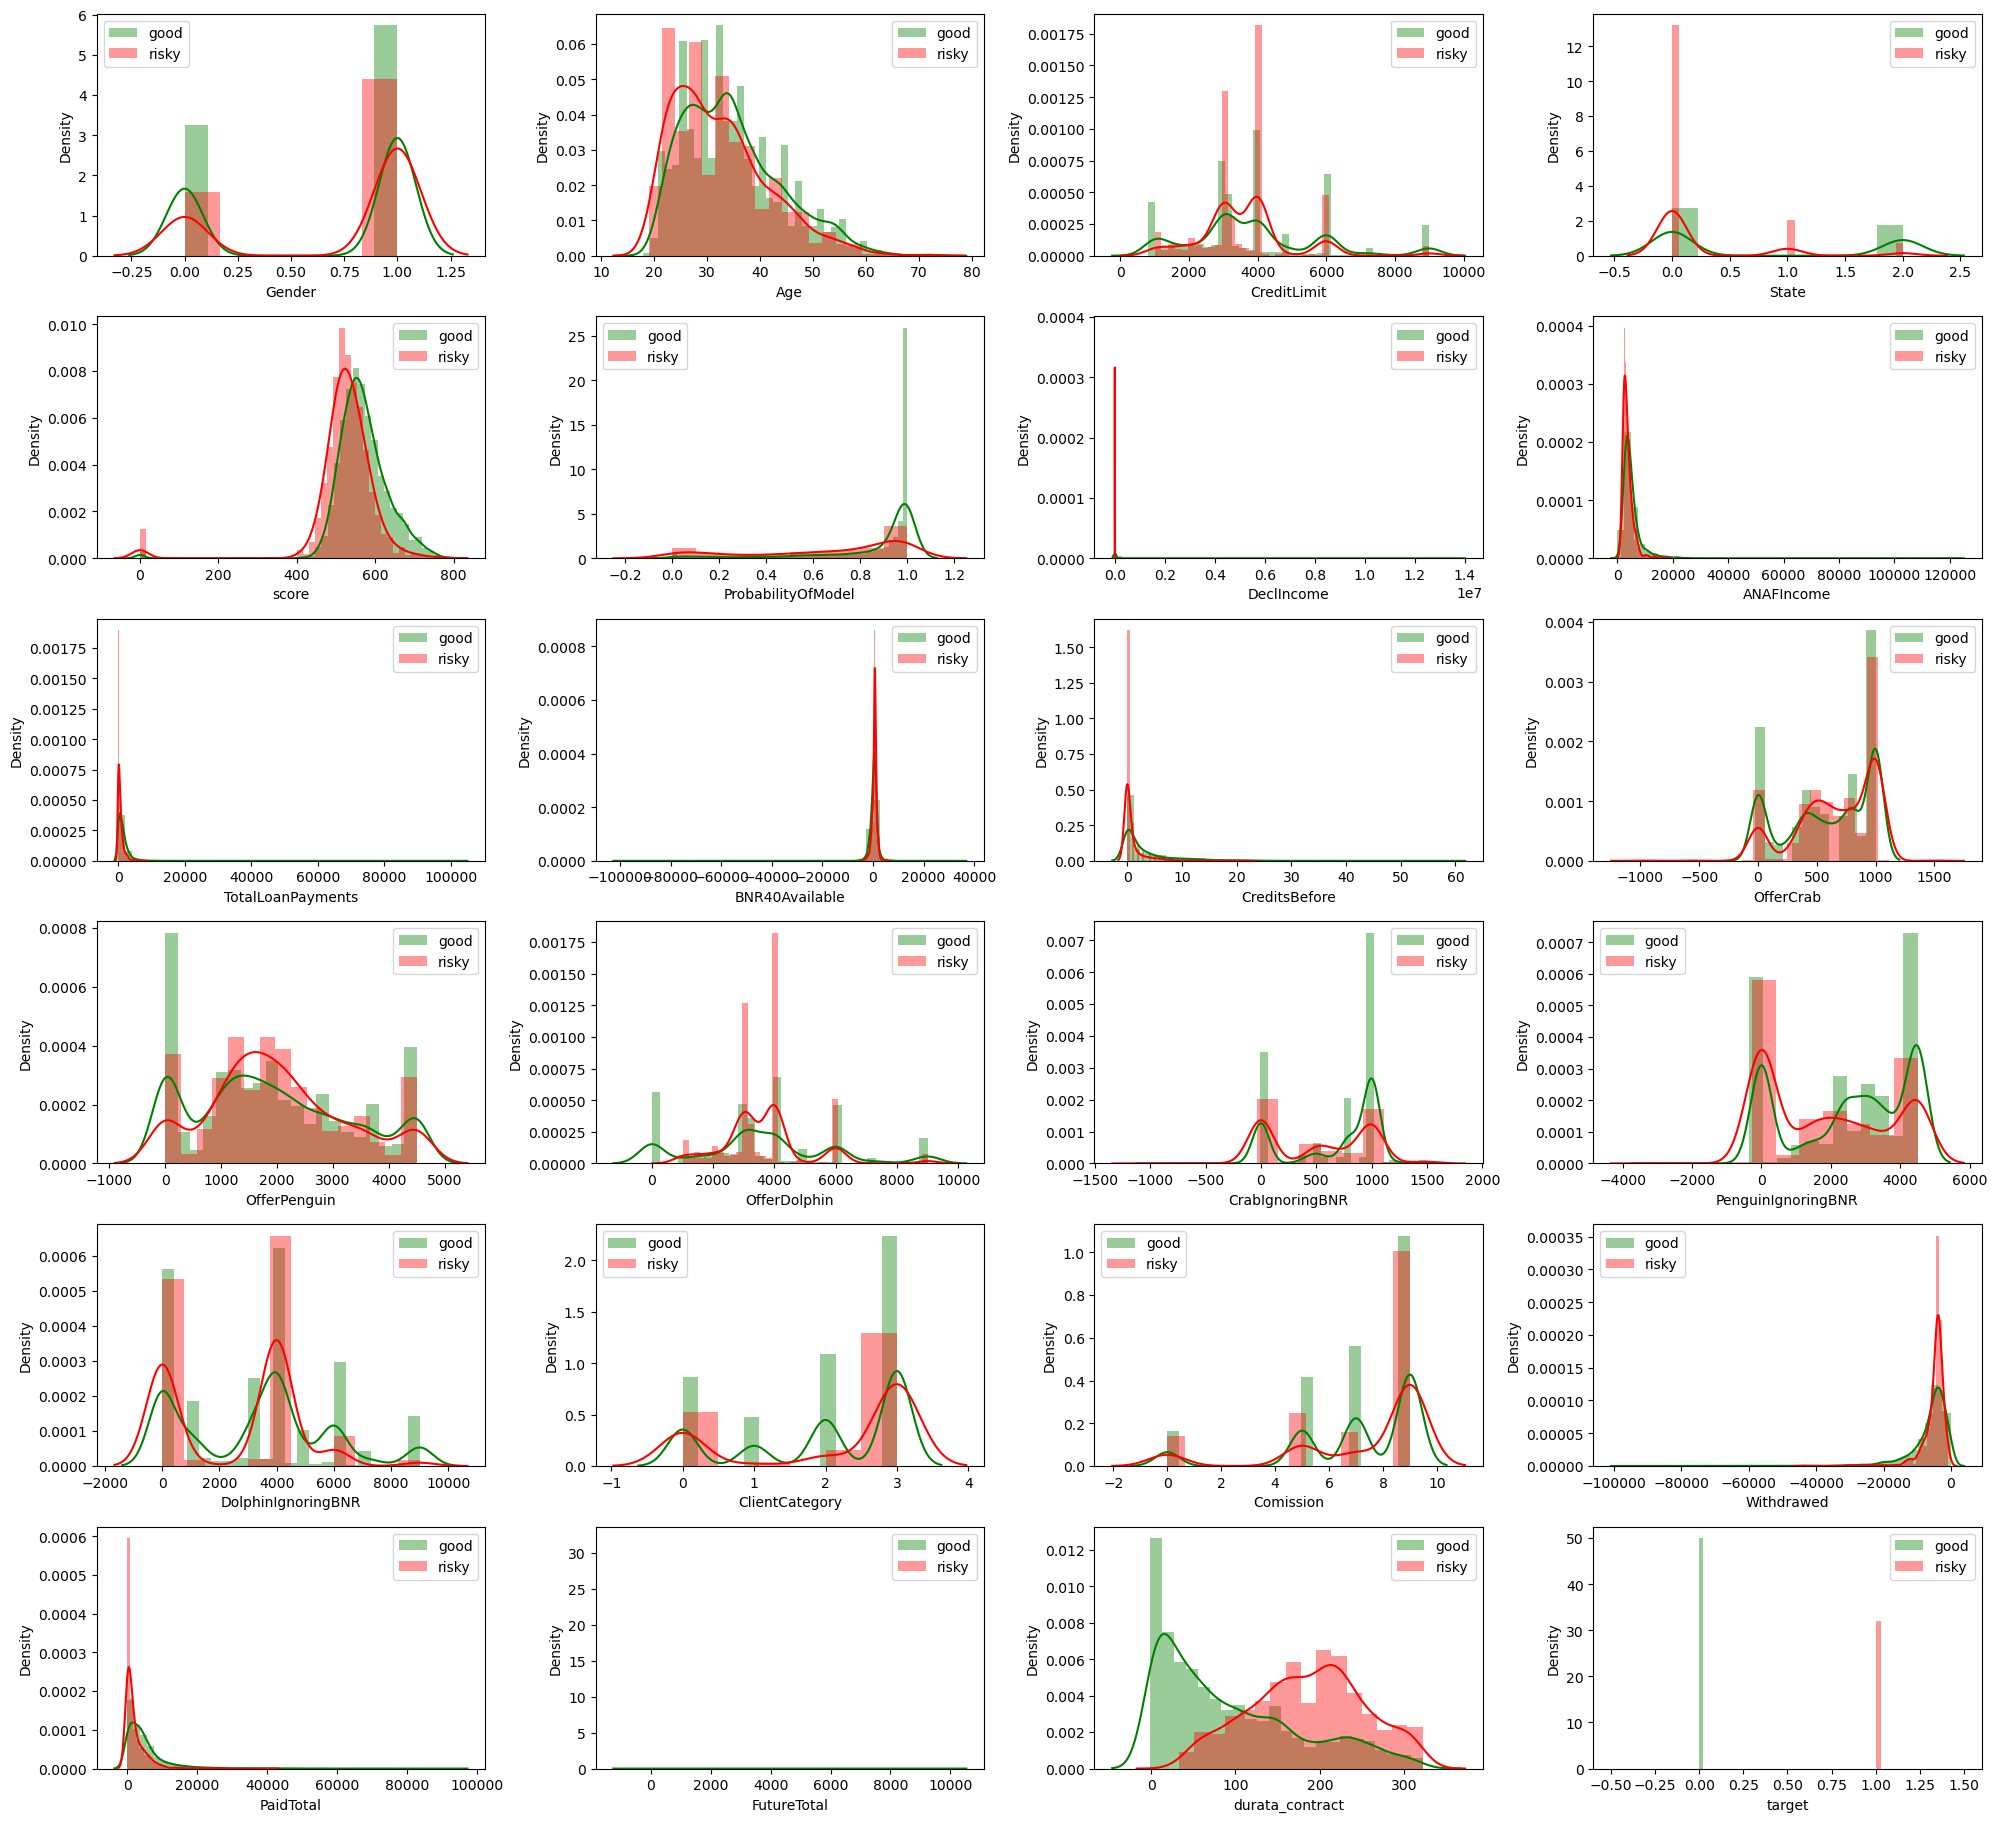

In [63]:
fig = plt.figure(figsize = (20, 25))
j = 0

for column in df_delfin:
    plt.subplot(8, 4, j+1)
    j += 1
    sns.distplot(df_delfin[column][df_delfin['target']==0],color='g', label = 'good')
    sns.distplot(df_delfin[column][df_delfin['target']==1],color='r', label = 'risky')
    plt.legend(loc='best')
fig.tight_layout()
fig.subplots_adjust(top=0.95)
plt.show()

In [64]:
y_delfin=df_delfin['target']
X_delfin=df_delfin.drop(['State','ProbabilityOfModel', 'OfferCrab',
       'OfferPenguin','CrabIgnoringBNR','DolphinIgnoringBNR','PenguinIgnoringBNR', 'ClientCategory', 'Comission', 'Withdrawed',
       'PaidTotal', 'FutureTotal', 'durata_contract', 'target','DeclIncome'],axis=1)

In [65]:
min_max_scaler = MinMaxScaler(feature_range =(0, 1))
X_rescaled = min_max_scaler.fit_transform(X_delfin)
print ("\nAfter min max Scaling : \n", X_rescaled)


After min max Scaling : 
 [[0.         0.16071429 0.26829268 ... 0.74070942 0.03389831 0.33333333]
 [1.         0.35714286 0.26829268 ... 0.72305404 0.03389831 0.33333333]
 [1.         0.41071429 0.26829268 ... 0.73916403 0.18644068 0.33333333]
 ...
 [1.         0.07142857 0.26829268 ... 0.72274059 0.         0.33333333]
 [1.         0.07142857 0.29268293 ... 0.74100101 0.15254237 0.35555556]
 [0.         0.35714286 0.48780488 ... 0.76194399 0.         0.53333333]]


In [66]:
from sklearn.decomposition import PCA
pca_delfin = PCA(n_components = 0.95)
pca_delfin.fit(X_rescaled)
X_pca = pca_delfin.transform(X_rescaled)

In [67]:
X_pca=pd.DataFrame(X_pca)
X_train,X_test,y_train,y_test=train_test_split(X_pca,y_delfin,test_size=0.2,random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)


              precision    recall  f1-score   support

         0.0       0.92      0.69      0.79      1047
         1.0       0.31      0.70      0.43       212

    accuracy                           0.69      1259
   macro avg       0.62      0.70      0.61      1259
weighted avg       0.82      0.69      0.73      1259



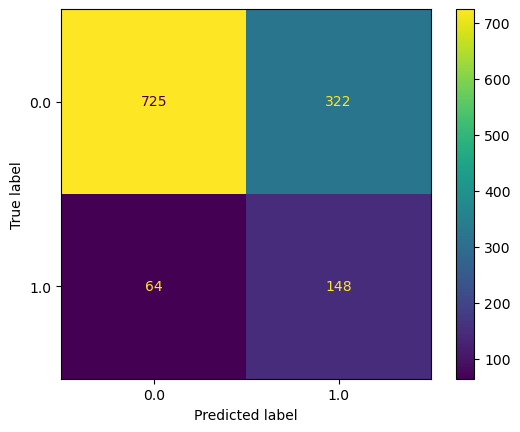

In [68]:
#X_train,X_test,y_train,y_test=train_test_split(X_resampled,y_resampled,test_size=0.2,random_state=42)
lgb_classifier_delfin = lgb.LGBMClassifier(random_state=42)
#model = lgb.train(params, train_data, valid_sets=[val_data])
lgb_classifier_delfin.fit(X_resampled,y_resampled)
y_pred = lgb_classifier_delfin.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
ConfusionMatrixDisplay.from_predictions(y_test,y_pred)
print("\n"+ classification_report(y_test, y_pred))

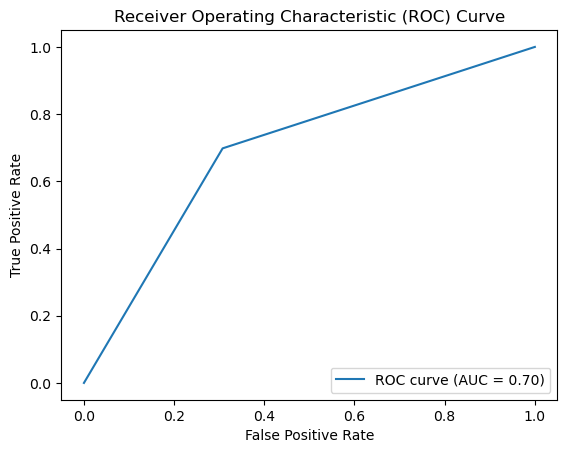

In [69]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)
plt.plot(fpr, tpr, label='ROC curve (AUC = {:.2f})'.format(auc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

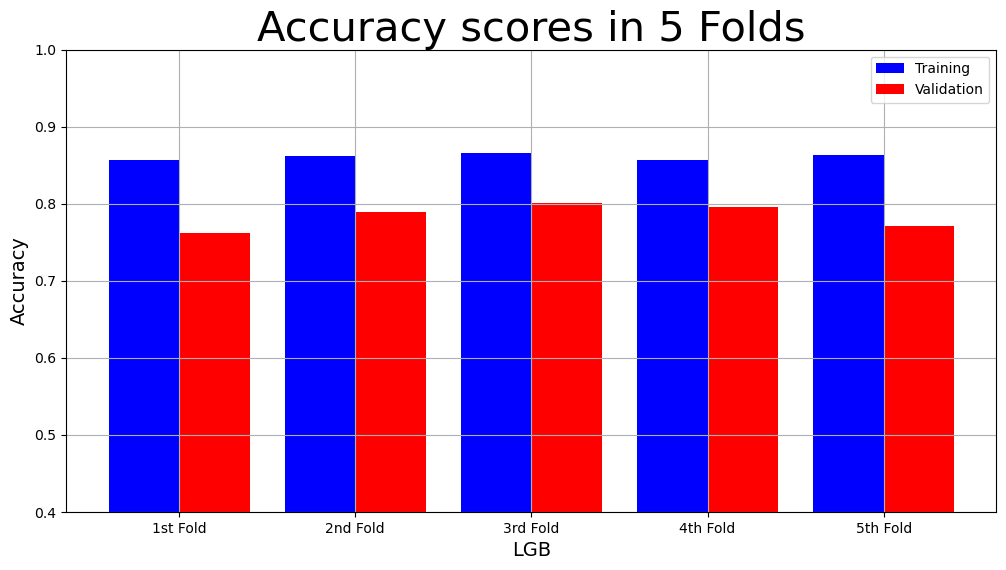

In [70]:
lgb_result = cross_validation(lgb_classifier_delfin, X_resampled, y_resampled, 5)
model_name = "LGB"
plot_result(model_name,
            "Accuracy",
            "Accuracy scores in 5 Folds",
            lgb_result["Training Accuracy scores"],
            lgb_result["Validation Accuracy scores"])

In [71]:
# with open('model_delfin.pkl', 'wb') as file:
#     pickle.dump(lgb_classifier_delfin, file)

In [72]:
# with open('pca_model_delfin.pkl', 'wb') as file:
#     pickle.dump(pca_delfin, file)

# Pinguin

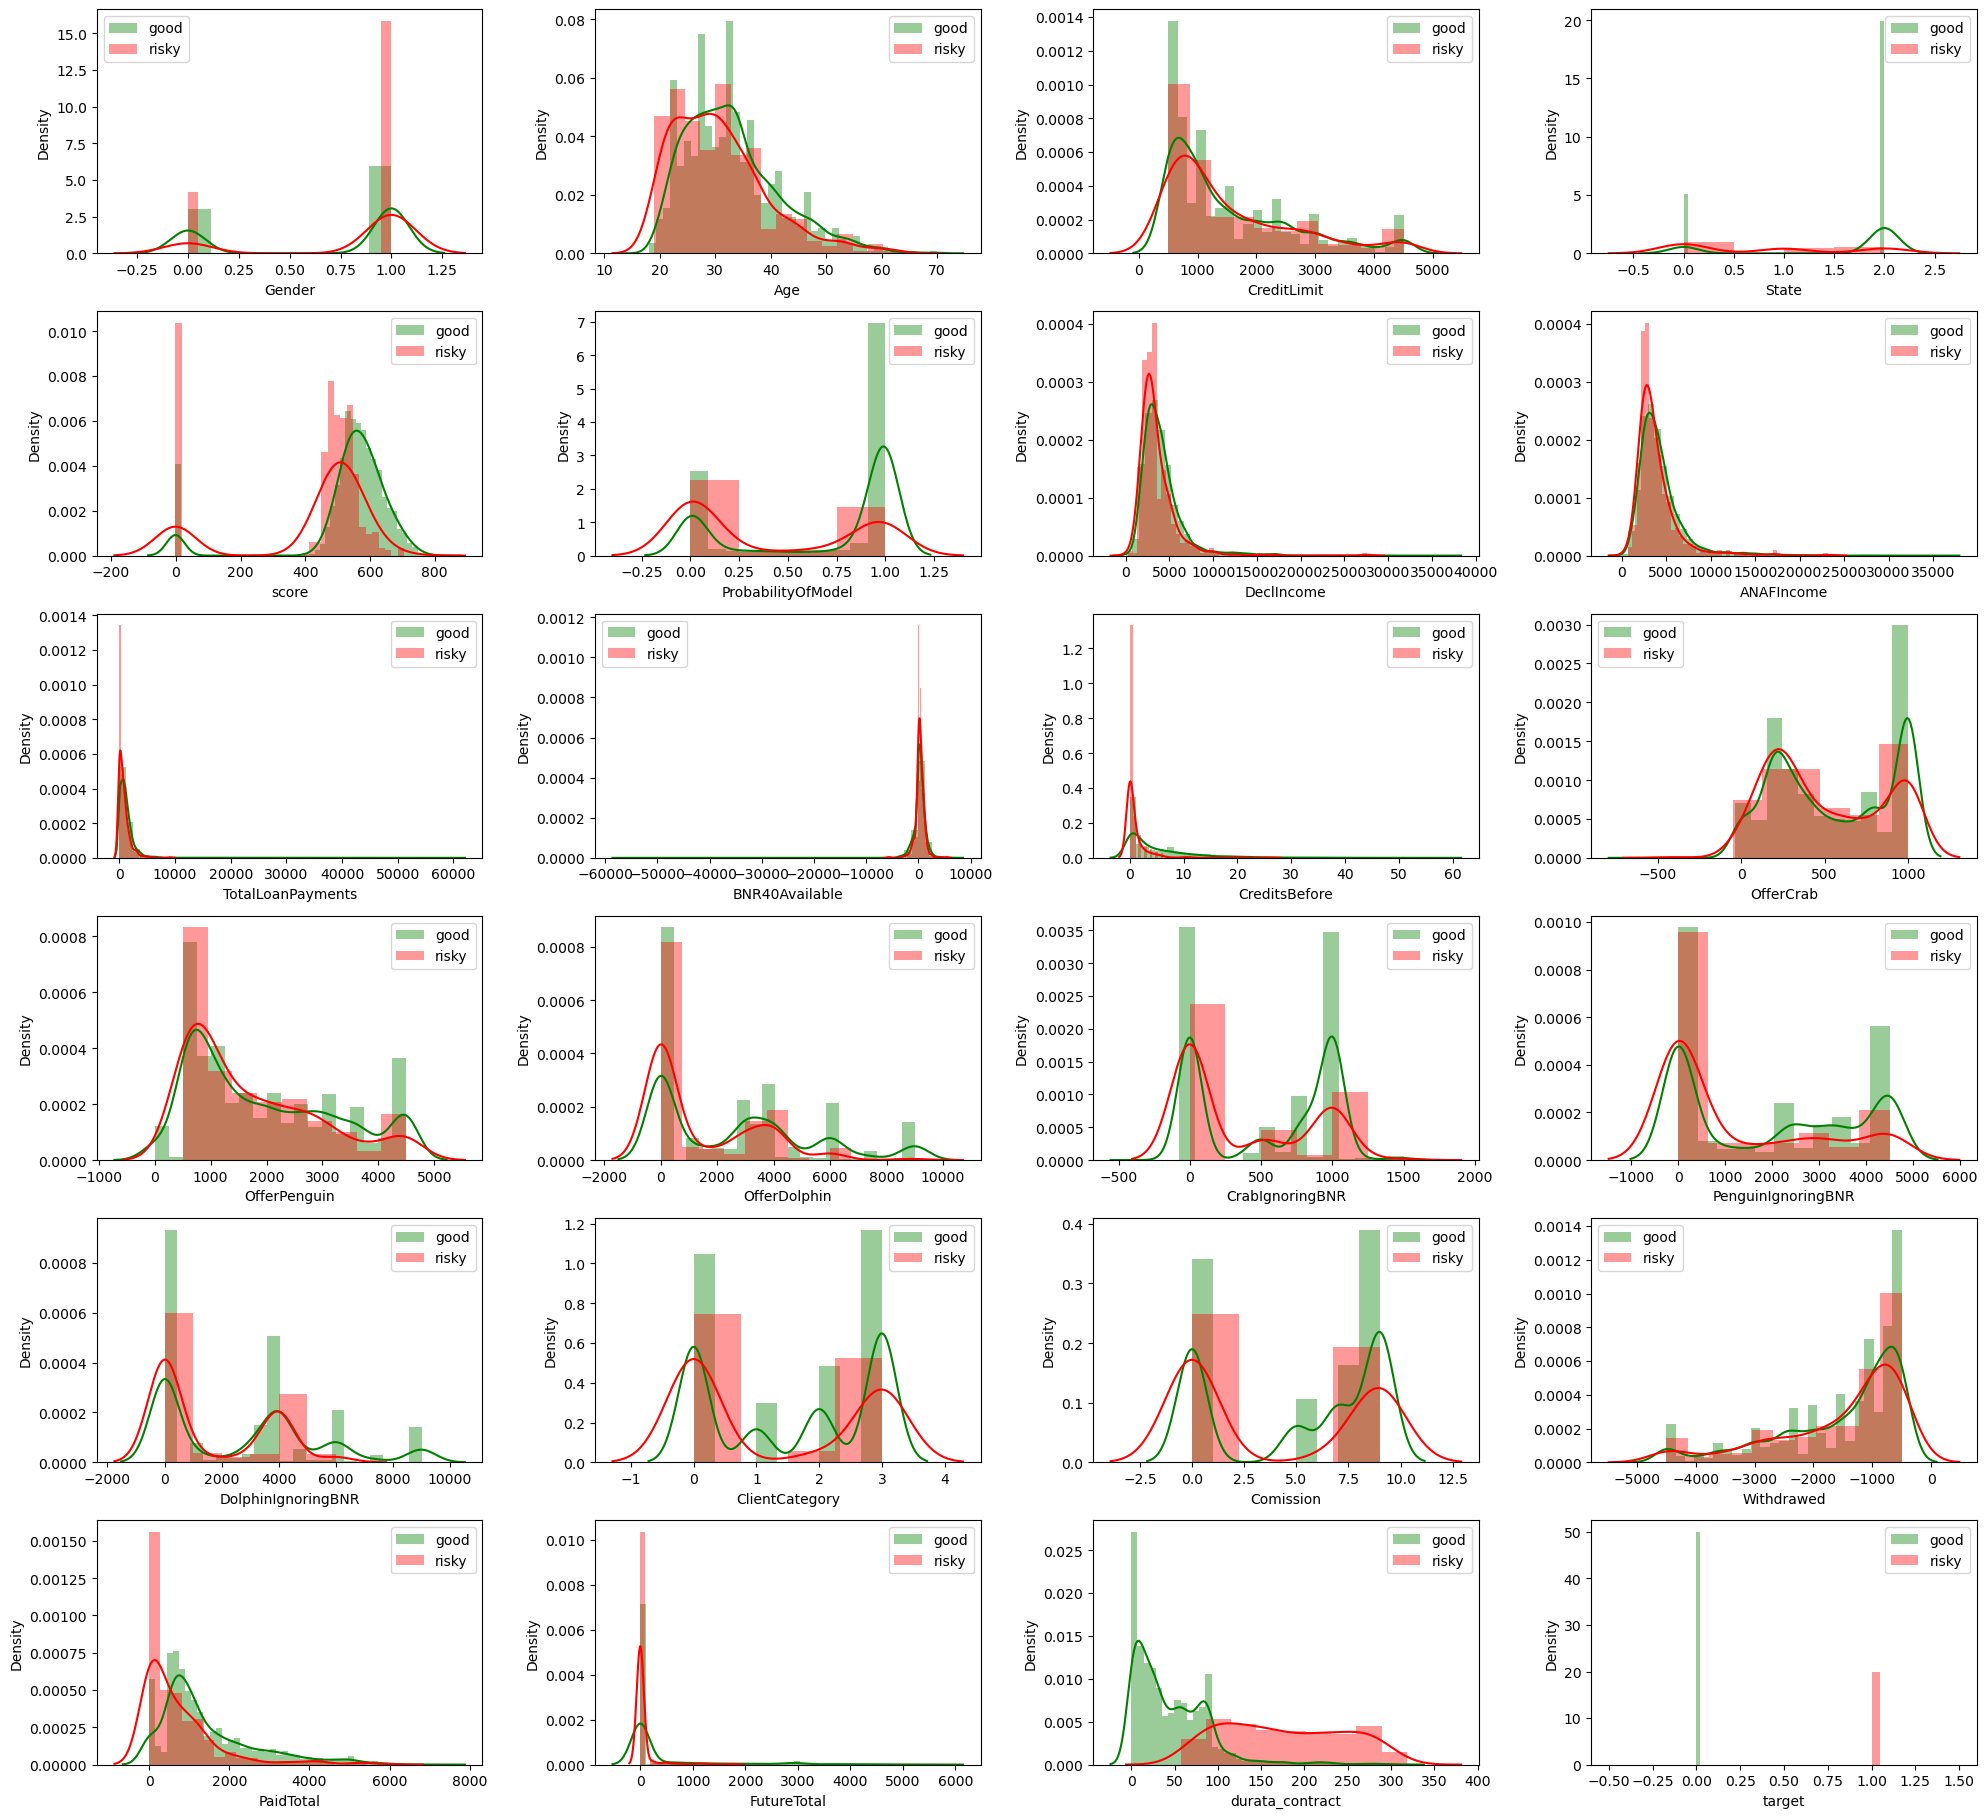

In [73]:
fig = plt.figure(figsize = (20, 25))
j = 0

for column in df_delfin:
    plt.subplot(8, 4, j+1)
    j += 1
    sns.distplot(df_pinguin[column][df_pinguin['target']==0],color='g', label = 'good')
    sns.distplot(df_pinguin[column][df_pinguin['target']==1],color='r', label = 'risky')
    plt.legend(loc='best')
fig.tight_layout()
fig.subplots_adjust(top=0.95)
plt.show()

In [74]:
y_pinguin=df_pinguin['target']
X_pinguin=df_pinguin.drop(['State','ProbabilityOfModel', 'OfferCrab',
       'OfferDolphin','CrabIgnoringBNR','PenguinIgnoringBNR','DolphinIgnoringBNR', 'ClientCategory', 'Comission', 'Withdrawed',
       'PaidTotal', 'FutureTotal', 'durata_contract', 'target','DeclIncome'],axis=1)

In [75]:
min_max_scaler = MinMaxScaler(feature_range =(0, 1))
X_rescaled = min_max_scaler.fit_transform(X_pinguin)
print ("\nAfter min max Scaling : \n", X_rescaled)


After min max Scaling : 
 [[1.         0.26923077 0.35       ... 0.89219767 0.10344828 0.42222222]
 [1.         0.26923077 0.05       ... 0.89219767 0.12068966 0.42222222]
 [1.         0.44230769 0.375      ... 0.8379763  0.12068966 0.44444444]
 ...
 [0.         0.17307692 0.475      ... 0.84675907 0.37931034 0.        ]
 [1.         0.11538462 0.475      ... 0.90320662 0.03448276 0.6       ]
 [1.         0.07692308 0.5        ... 0.88428404 0.13793103 0.55555556]]


In [76]:
pca_pinguin = PCA(n_components = 0.95)
pca_pinguin.fit(X_rescaled)
X_pca = pca_pinguin.transform(X_rescaled)

In [77]:
X_pca=pd.DataFrame(X_pca)
X_train,X_test,y_train,y_test=train_test_split(X_resampled,y_resampled,test_size=0.3,random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)


              precision    recall  f1-score   support

         0.0       0.84      0.72      0.77      1275
         1.0       0.75      0.86      0.80      1238

    accuracy                           0.79      2513
   macro avg       0.80      0.79      0.79      2513
weighted avg       0.80      0.79      0.79      2513



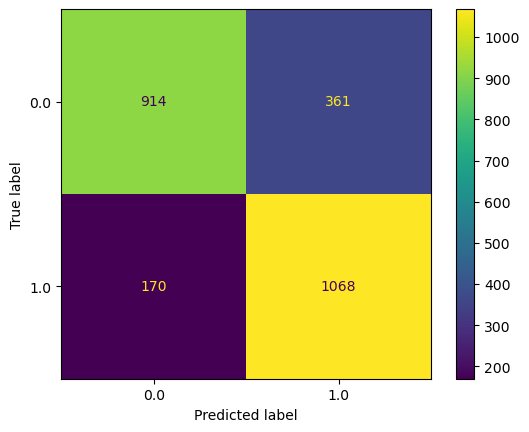

In [78]:
#X_train,X_test,y_train,y_test=train_test_split(X_resampled,y_resampled,test_size=0.2,random_state=42)
lgb_classifier_pinguin = lgb.LGBMClassifier(random_state=42)
#model = lgb.train(params, train_data, valid_sets=[val_data])
lgb_classifier_pinguin.fit(X_resampled,y_resampled)
y_pred = lgb_classifier_pinguin.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
ConfusionMatrixDisplay.from_predictions(y_test,y_pred)
print("\n"+ classification_report(y_test, y_pred))

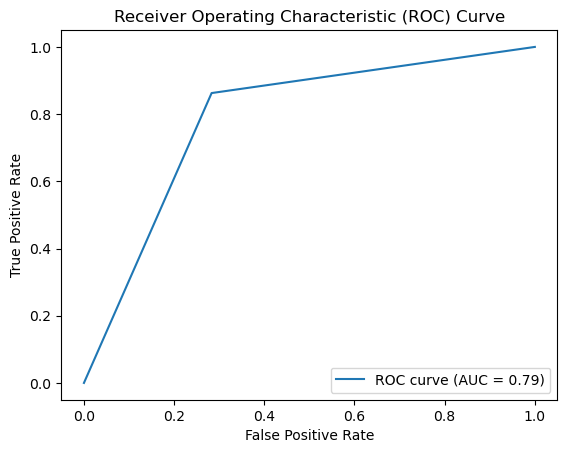

In [79]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)
plt.plot(fpr, tpr, label='ROC curve (AUC = {:.2f})'.format(auc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

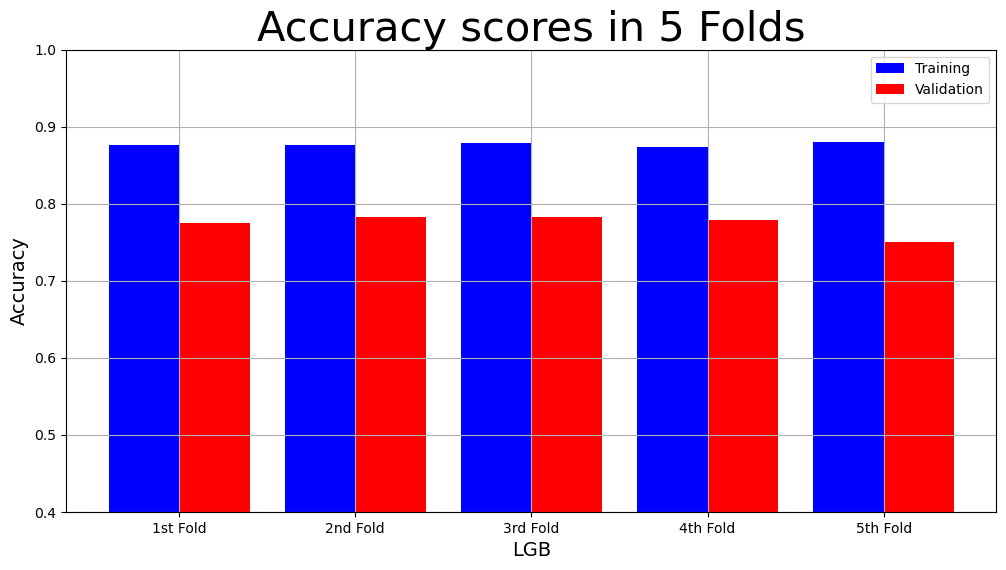

In [80]:
lgb_result = cross_validation(lgb_classifier_pinguin, X_resampled, y_resampled, 5)
model_name = "LGB"
plot_result(model_name,
            "Accuracy",
            "Accuracy scores in 5 Folds",
            lgb_result["Training Accuracy scores"],
            lgb_result["Validation Accuracy scores"])

In [81]:
# with open('model_pinguin.pkl', 'wb') as file:
#     pickle.dump(lgb_classifier_pinguin, file)

In [82]:
# with open('pca_model_pinguin.pkl', 'wb') as file:
#     pickle.dump(pca_pinguin, file)

In [83]:
X_crab.columns

Index(['Gender', 'Age', 'CreditLimit', 'score', 'ANAFIncome',
       'TotalLoanPayments', 'BNR40Available', 'CreditsBefore', 'OfferCrab'],
      dtype='object')

In [84]:
work_df.columns

Index(['Gender', 'Age', 'CreditLimit', 'State', 'score', 'ProbabilityOfModel',
       'DeclIncome', 'ANAFIncome', 'TotalLoanPayments', 'BNR40Available',
       'CreditsBefore', 'OfferCrab', 'OfferPenguin', 'OfferDolphin',
       'CrabIgnoringBNR', 'PenguinIgnoringBNR', 'DolphinIgnoringBNR',
       'ClientCategory', 'Comission', 'Withdrawed', 'PaidTotal', 'FutureTotal',
       'Crab', 'Dolphin', 'Penguin', 'durata_contract', 'target'],
      dtype='object')

In [85]:
y_work=work_df['target']
X_work=work_df.drop(['State','ProbabilityOfModel','DeclIncome','ClientCategory','durata_contract', 'Comission', 'Withdrawed', 'PaidTotal', 'FutureTotal','target','CrabIgnoringBNR','DolphinIgnoringBNR','PenguinIgnoringBNR'],axis=1)

In [86]:
X_work.loc[X_work['Penguin'] == 1, ['OfferCrab', 'OfferDolphin']]=0
X_work.loc[X_work['Crab'] == 1, ['OfferPenguin', 'OfferDolphin']]=0
X_work.loc[X_work['Dolphin'] == 1, ['OfferCrab', 'OfferPenguin']]=0


In [87]:
X_work.columns

Index(['Gender', 'Age', 'CreditLimit', 'score', 'ANAFIncome',
       'TotalLoanPayments', 'BNR40Available', 'CreditsBefore', 'OfferCrab',
       'OfferPenguin', 'OfferDolphin', 'Crab', 'Dolphin', 'Penguin'],
      dtype='object')

In [88]:
X_work=X_work.drop(['BNR40Available','OfferCrab','OfferPenguin', 'OfferDolphin','Penguin'],axis=1)

<AxesSubplot:>

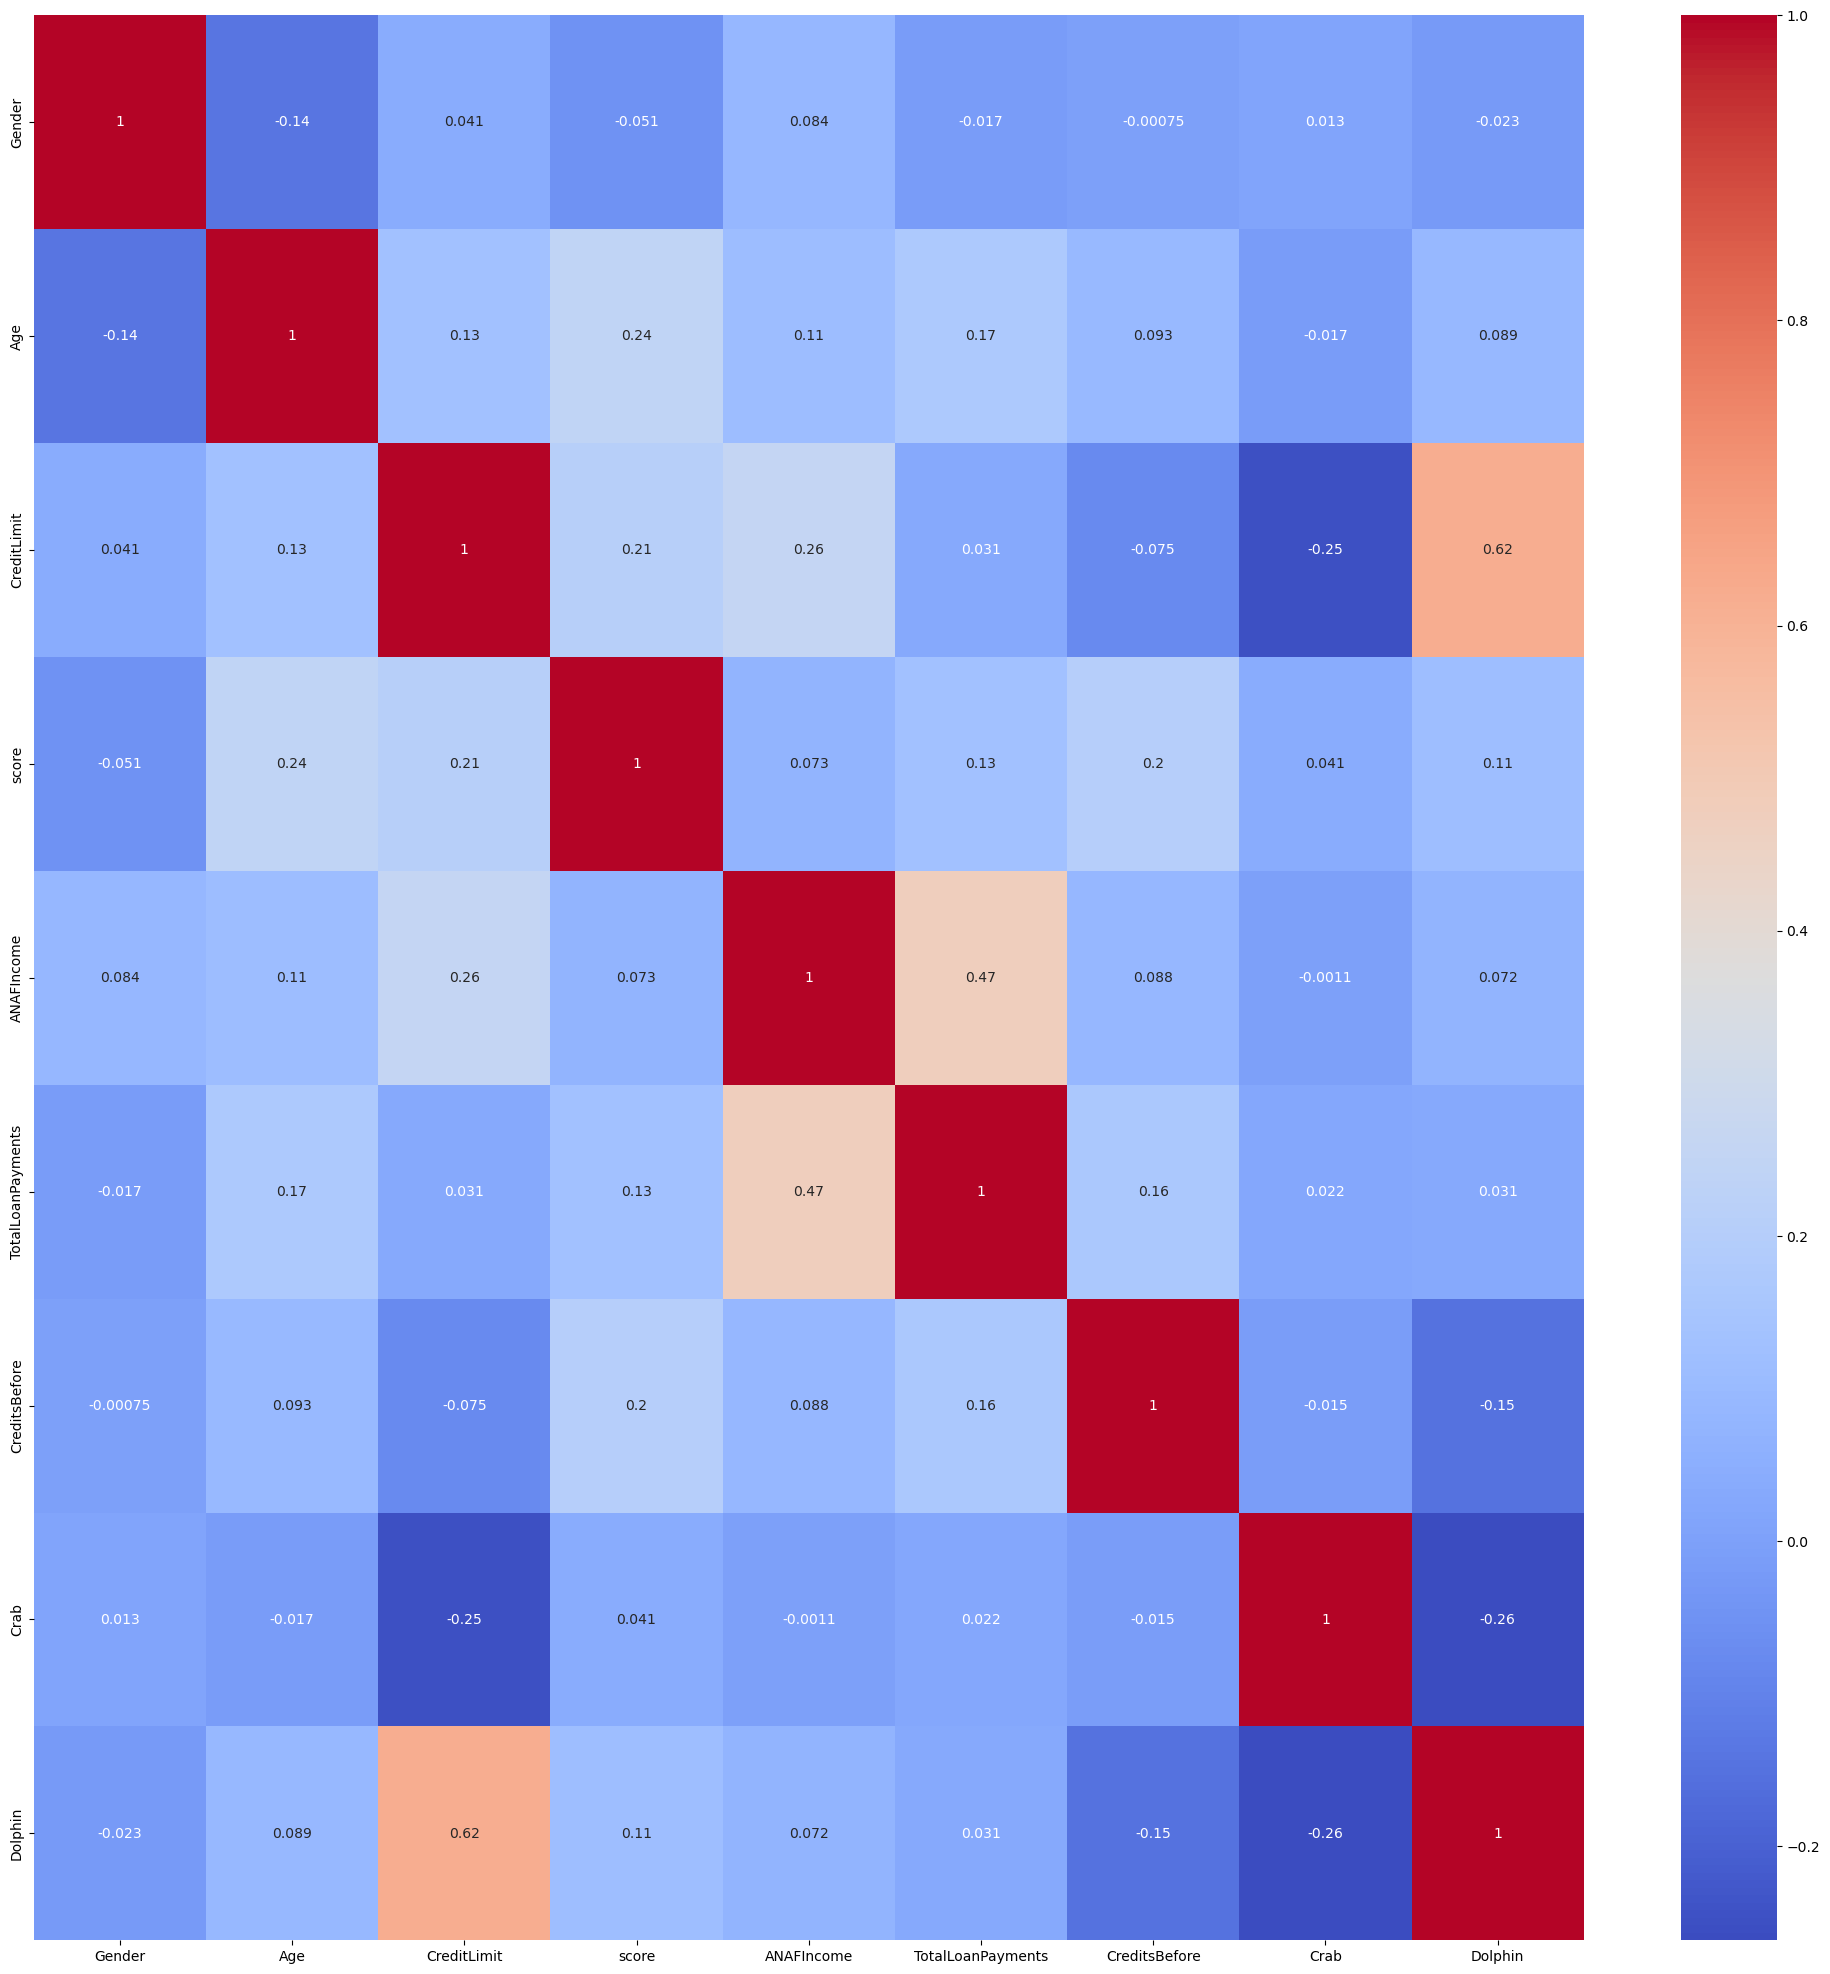

In [89]:
plt.figure(figsize=(25,25))
sns.heatmap(X_work.corr(),annot=True,cmap='coolwarm')

In [90]:
min_max_scaler = MinMaxScaler(feature_range =(0, 1))
X_rescaled = min_max_scaler.fit_transform(X_work)
print ("\nAfter min max Scaling : \n", X_rescaled)


After min max Scaling : 
 [[1.         0.25       0.16470588 ... 0.10169492 0.         0.        ]
 [1.         0.25       0.02352941 ... 0.11864407 0.         0.        ]
 [1.         0.41071429 0.17647059 ... 0.11864407 0.         0.        ]
 ...
 [1.         0.07142857 0.23529412 ... 0.13559322 0.         0.        ]
 [1.         0.07142857 0.31764706 ... 0.15254237 0.         1.        ]
 [0.         0.35714286 0.50588235 ... 0.         0.         1.        ]]


In [91]:
pca = PCA(n_components = 0.95)
pca.fit(X_rescaled)
X_pca = pca.transform(X_rescaled)

In [92]:

X_pca=pd.DataFrame(X_pca)
X_train,X_test,y_train,y_test=train_test_split(X_pca,y_work,test_size=0.2,random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)


              precision    recall  f1-score   support

         0.0       0.94      0.74      0.83      2197
         1.0       0.24      0.63      0.35       283

    accuracy                           0.73      2480
   macro avg       0.59      0.69      0.59      2480
weighted avg       0.86      0.73      0.77      2480



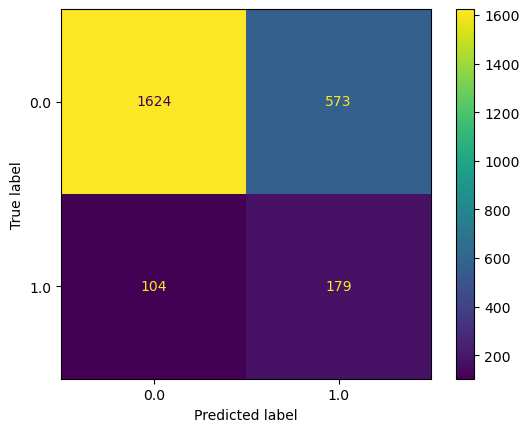

In [93]:
# X_train,X_test,y_train,y_test=train_test_split(X_resampled,y_resampled,test_size=0.2,random_state=42)
lgb_classifier_total = lgb.LGBMClassifier(random_state=42)
#model = lgb.train(params, train_data, valid_sets=[val_data])
lgb_classifier_total.fit(X_resampled,y_resampled)
y_pred = lgb_classifier_total.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
ConfusionMatrixDisplay.from_predictions(y_test,y_pred)
print("\n"+ classification_report(y_test, y_pred))

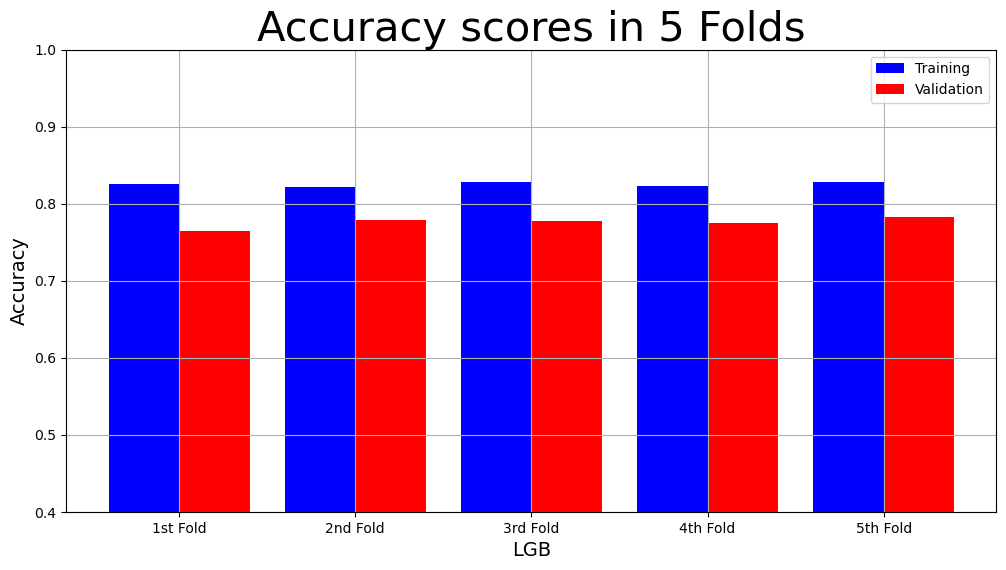

In [94]:
lgb_result = cross_validation(lgb_classifier_total, X_resampled, y_resampled, 5)
model_name = "LGB"
plot_result(model_name,
            "Accuracy",
            "Accuracy scores in 5 Folds",
            lgb_result["Training Accuracy scores"],
            lgb_result["Validation Accuracy scores"])

In [95]:
# with open('model_total.pkl', 'wb') as file:
#     pickle.dump(lgb_classifier_total, file)


              precision    recall  f1-score   support

         0.0       0.94      0.74      0.83      2197
         1.0       0.24      0.63      0.35       283

    accuracy                           0.73      2480
   macro avg       0.59      0.69      0.59      2480
weighted avg       0.86      0.73      0.77      2480



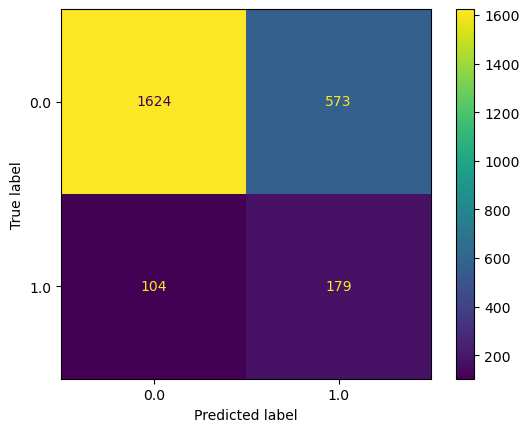

In [96]:
lgb_classifier_total = lgb.LGBMClassifier(random_state=42)
#model = lgb.train(params, train_data, valid_sets=[val_data])
lgb_classifier_total.fit(X_resampled,y_resampled)
y_pred = lgb_classifier_total.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
ConfusionMatrixDisplay.from_predictions(y_test,y_pred)
print("\n"+ classification_report(y_test, y_pred))

In [97]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
from sklearn.model_selection import GridSearchCV

In [98]:
adaBoost = AdaBoostClassifier(n_estimators=100,random_state=42)
gradientBoosting = GradientBoostingClassifier(n_estimators=50,random_state=42)
xgbClassifier = xgb.XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,random_state=42)
lgbClassifier = lgb.LGBMClassifier(max_depth=5, n_estimators=50,random_state=42)
catBoostClassifier = cb.CatBoostClassifier(random_state=42)
model_list=[adaBoost,gradientBoosting,lgbClassifier,catBoostClassifier,xgbClassifier,]


              precision    recall  f1-score   support

         0.0       0.94      0.64      0.76      2197
         1.0       0.20      0.71      0.31       283

    accuracy                           0.64      2480
   macro avg       0.57      0.67      0.54      2480
weighted avg       0.86      0.64      0.71      2480


              precision    recall  f1-score   support

         0.0       0.95      0.67      0.78      2197
         1.0       0.22      0.71      0.33       283

    accuracy                           0.67      2480
   macro avg       0.58      0.69      0.56      2480
weighted avg       0.86      0.67      0.73      2480


              precision    recall  f1-score   support

         0.0       0.95      0.69      0.80      2197
         1.0       0.23      0.71      0.35       283

    accuracy                           0.69      2480
   macro avg       0.59      0.70      0.57      2480
weighted avg       0.87      0.69      0.75      2480

Learning rate se

157:	learn: 0.5655463	total: 1.2s	remaining: 6.41s
158:	learn: 0.5653522	total: 1.21s	remaining: 6.4s
159:	learn: 0.5651233	total: 1.22s	remaining: 6.39s
160:	learn: 0.5646525	total: 1.22s	remaining: 6.38s
161:	learn: 0.5645303	total: 1.23s	remaining: 6.37s
162:	learn: 0.5643513	total: 1.24s	remaining: 6.36s
163:	learn: 0.5640161	total: 1.25s	remaining: 6.35s
164:	learn: 0.5637570	total: 1.25s	remaining: 6.34s
165:	learn: 0.5636010	total: 1.26s	remaining: 6.33s
166:	learn: 0.5634099	total: 1.27s	remaining: 6.32s
167:	learn: 0.5632943	total: 1.27s	remaining: 6.3s
168:	learn: 0.5630614	total: 1.28s	remaining: 6.3s
169:	learn: 0.5627345	total: 1.29s	remaining: 6.28s
170:	learn: 0.5624847	total: 1.29s	remaining: 6.28s
171:	learn: 0.5622330	total: 1.3s	remaining: 6.26s
172:	learn: 0.5619680	total: 1.31s	remaining: 6.25s
173:	learn: 0.5618219	total: 1.31s	remaining: 6.24s
174:	learn: 0.5616361	total: 1.32s	remaining: 6.22s
175:	learn: 0.5613771	total: 1.33s	remaining: 6.22s
176:	learn: 0.560

336:	learn: 0.5247788	total: 2.47s	remaining: 4.87s
337:	learn: 0.5245047	total: 2.48s	remaining: 4.86s
338:	learn: 0.5243626	total: 2.49s	remaining: 4.86s
339:	learn: 0.5242414	total: 2.5s	remaining: 4.85s
340:	learn: 0.5240891	total: 2.5s	remaining: 4.84s
341:	learn: 0.5239560	total: 2.51s	remaining: 4.83s
342:	learn: 0.5238083	total: 2.52s	remaining: 4.82s
343:	learn: 0.5235017	total: 2.52s	remaining: 4.81s
344:	learn: 0.5233559	total: 2.53s	remaining: 4.81s
345:	learn: 0.5231147	total: 2.54s	remaining: 4.8s
346:	learn: 0.5229153	total: 2.55s	remaining: 4.79s
347:	learn: 0.5226999	total: 2.55s	remaining: 4.78s
348:	learn: 0.5223968	total: 2.56s	remaining: 4.78s
349:	learn: 0.5220649	total: 2.57s	remaining: 4.77s
350:	learn: 0.5217397	total: 2.58s	remaining: 4.76s
351:	learn: 0.5214669	total: 2.58s	remaining: 4.75s
352:	learn: 0.5213307	total: 2.59s	remaining: 4.75s
353:	learn: 0.5210891	total: 2.6s	remaining: 4.74s
354:	learn: 0.5209354	total: 2.6s	remaining: 4.73s
355:	learn: 0.520

519:	learn: 0.4879181	total: 3.73s	remaining: 3.44s
520:	learn: 0.4877683	total: 3.74s	remaining: 3.44s
521:	learn: 0.4876373	total: 3.75s	remaining: 3.43s
522:	learn: 0.4874071	total: 3.75s	remaining: 3.42s
523:	learn: 0.4871314	total: 3.76s	remaining: 3.42s
524:	learn: 0.4868631	total: 3.77s	remaining: 3.41s
525:	learn: 0.4866937	total: 3.77s	remaining: 3.4s
526:	learn: 0.4865051	total: 3.78s	remaining: 3.39s
527:	learn: 0.4863374	total: 3.79s	remaining: 3.38s
528:	learn: 0.4860695	total: 3.79s	remaining: 3.38s
529:	learn: 0.4859896	total: 3.8s	remaining: 3.37s
530:	learn: 0.4858387	total: 3.81s	remaining: 3.36s
531:	learn: 0.4856767	total: 3.81s	remaining: 3.35s
532:	learn: 0.4854801	total: 3.82s	remaining: 3.35s
533:	learn: 0.4853710	total: 3.83s	remaining: 3.34s
534:	learn: 0.4852200	total: 3.83s	remaining: 3.33s
535:	learn: 0.4850118	total: 3.84s	remaining: 3.32s
536:	learn: 0.4847629	total: 3.85s	remaining: 3.32s
537:	learn: 0.4845577	total: 3.85s	remaining: 3.31s
538:	learn: 0.

697:	learn: 0.4585910	total: 4.97s	remaining: 2.15s
698:	learn: 0.4583933	total: 4.98s	remaining: 2.14s
699:	learn: 0.4582315	total: 4.99s	remaining: 2.14s
700:	learn: 0.4580070	total: 4.99s	remaining: 2.13s
701:	learn: 0.4579021	total: 5s	remaining: 2.12s
702:	learn: 0.4577906	total: 5.01s	remaining: 2.12s
703:	learn: 0.4577151	total: 5.01s	remaining: 2.11s
704:	learn: 0.4574993	total: 5.02s	remaining: 2.1s
705:	learn: 0.4574011	total: 5.03s	remaining: 2.09s
706:	learn: 0.4572043	total: 5.04s	remaining: 2.09s
707:	learn: 0.4570366	total: 5.04s	remaining: 2.08s
708:	learn: 0.4569277	total: 5.05s	remaining: 2.07s
709:	learn: 0.4567670	total: 5.06s	remaining: 2.06s
710:	learn: 0.4566584	total: 5.06s	remaining: 2.06s
711:	learn: 0.4565475	total: 5.07s	remaining: 2.05s
712:	learn: 0.4564259	total: 5.08s	remaining: 2.04s
713:	learn: 0.4563345	total: 5.08s	remaining: 2.04s
714:	learn: 0.4561847	total: 5.09s	remaining: 2.03s
715:	learn: 0.4560771	total: 5.1s	remaining: 2.02s
716:	learn: 0.455

881:	learn: 0.4338231	total: 6.24s	remaining: 835ms
882:	learn: 0.4337030	total: 6.25s	remaining: 828ms
883:	learn: 0.4335959	total: 6.25s	remaining: 821ms
884:	learn: 0.4334516	total: 6.26s	remaining: 814ms
885:	learn: 0.4333181	total: 6.27s	remaining: 806ms
886:	learn: 0.4332191	total: 6.28s	remaining: 800ms
887:	learn: 0.4330796	total: 6.28s	remaining: 792ms
888:	learn: 0.4329330	total: 6.29s	remaining: 785ms
889:	learn: 0.4328234	total: 6.3s	remaining: 778ms
890:	learn: 0.4326985	total: 6.3s	remaining: 771ms
891:	learn: 0.4326109	total: 6.31s	remaining: 764ms
892:	learn: 0.4324894	total: 6.32s	remaining: 757ms
893:	learn: 0.4322801	total: 6.32s	remaining: 750ms
894:	learn: 0.4321251	total: 6.33s	remaining: 743ms
895:	learn: 0.4320219	total: 6.34s	remaining: 736ms
896:	learn: 0.4318955	total: 6.34s	remaining: 728ms
897:	learn: 0.4318194	total: 6.35s	remaining: 721ms
898:	learn: 0.4317429	total: 6.36s	remaining: 714ms
899:	learn: 0.4315721	total: 6.36s	remaining: 707ms
900:	learn: 0.

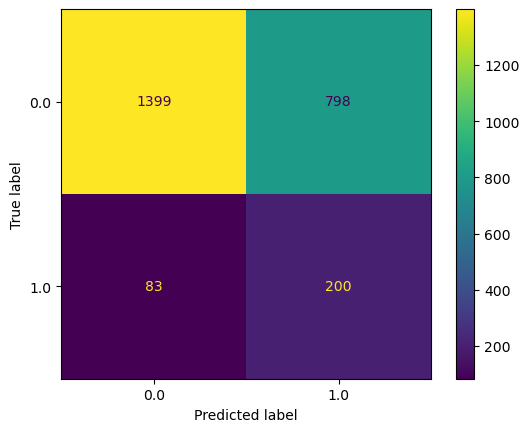

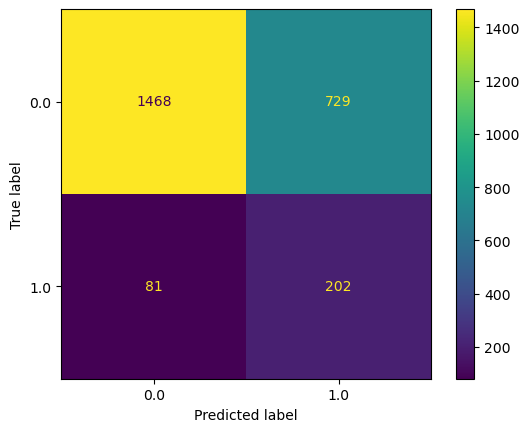

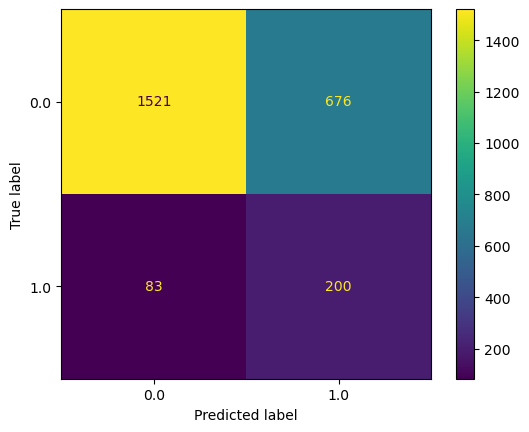

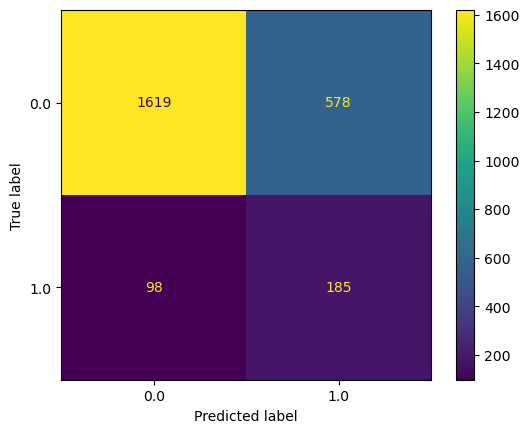

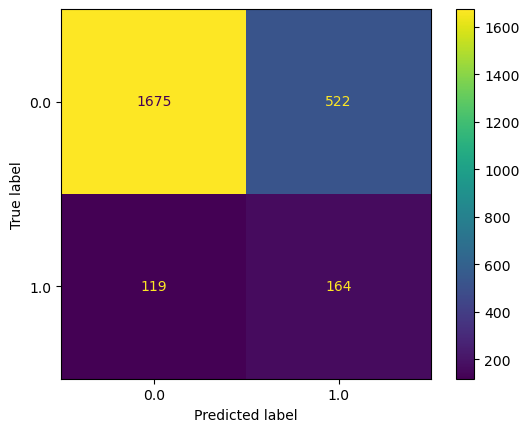

In [99]:
for model in model_list:
    model
    model.fit(X_resampled, y_resampled)
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    ConfusionMatrixDisplay.from_predictions(y_test,y_pred)
    print("\n"+ classification_report(y_test, y_pred))

In [100]:
### best xgb

In [101]:
catBoostClassifier = cb.CatBoostClassifier(random_state=42)
catBoost_params = {
    'iterations': [50, 100, 200],
    'learning_rate': [0.1, 0.5, 1.0],
    'depth': [3, 5, 7]
}
catBoost_grid = GridSearchCV(catBoostClassifier, catBoost_params, cv=5)
catBoost_grid.fit(X_train, y_train)
catBoost_best_model = catBoost_grid.best_estimator_

0:	learn: 0.6394485	total: 1.1ms	remaining: 53.9ms
1:	learn: 0.5954896	total: 2.31ms	remaining: 55.5ms
2:	learn: 0.5586191	total: 3.72ms	remaining: 58.3ms
3:	learn: 0.5277300	total: 5.15ms	remaining: 59.3ms
4:	learn: 0.5027715	total: 6.29ms	remaining: 56.6ms
5:	learn: 0.4815549	total: 7.28ms	remaining: 53.4ms
6:	learn: 0.4629558	total: 8.51ms	remaining: 52.3ms
7:	learn: 0.4469347	total: 9.61ms	remaining: 50.5ms
8:	learn: 0.4337139	total: 10.6ms	remaining: 48.3ms
9:	learn: 0.4222556	total: 11.7ms	remaining: 46.7ms
10:	learn: 0.4124914	total: 12.7ms	remaining: 45.1ms
11:	learn: 0.4041350	total: 13.7ms	remaining: 43.5ms
12:	learn: 0.3971408	total: 14.9ms	remaining: 42.5ms
13:	learn: 0.3908425	total: 16ms	remaining: 41.2ms
14:	learn: 0.3855456	total: 17.1ms	remaining: 39.9ms
15:	learn: 0.3809751	total: 18.6ms	remaining: 39.6ms
16:	learn: 0.3767976	total: 19.9ms	remaining: 38.7ms
17:	learn: 0.3730328	total: 21ms	remaining: 37.3ms
18:	learn: 0.3696830	total: 22ms	remaining: 35.9ms
19:	learn:

5:	learn: 0.4819717	total: 8.22ms	remaining: 60.3ms
6:	learn: 0.4633791	total: 9.89ms	remaining: 60.8ms
7:	learn: 0.4474090	total: 11.1ms	remaining: 58.1ms
8:	learn: 0.4342697	total: 12.2ms	remaining: 55.8ms
9:	learn: 0.4228066	total: 13.5ms	remaining: 54ms
10:	learn: 0.4130490	total: 14.7ms	remaining: 52.2ms
11:	learn: 0.4047264	total: 15.9ms	remaining: 50.3ms
12:	learn: 0.3978608	total: 17.1ms	remaining: 48.6ms
13:	learn: 0.3916555	total: 18.3ms	remaining: 47.2ms
14:	learn: 0.3859843	total: 19.8ms	remaining: 46.1ms
15:	learn: 0.3814164	total: 21.1ms	remaining: 44.9ms
16:	learn: 0.3773663	total: 22.5ms	remaining: 43.6ms
17:	learn: 0.3738061	total: 23.6ms	remaining: 42ms
18:	learn: 0.3705759	total: 24.9ms	remaining: 40.6ms
19:	learn: 0.3679590	total: 26.3ms	remaining: 39.4ms
20:	learn: 0.3655463	total: 27.5ms	remaining: 38ms
21:	learn: 0.3637250	total: 28.6ms	remaining: 36.5ms
22:	learn: 0.3618712	total: 29.9ms	remaining: 35.1ms
23:	learn: 0.3602759	total: 31.3ms	remaining: 33.9ms
24:	

8:	learn: 0.3459649	total: 11.1ms	remaining: 50.4ms
9:	learn: 0.3446828	total: 12.8ms	remaining: 51ms
10:	learn: 0.3435432	total: 13.9ms	remaining: 49.4ms
11:	learn: 0.3427556	total: 15.1ms	remaining: 47.7ms
12:	learn: 0.3419563	total: 16.2ms	remaining: 46.1ms
13:	learn: 0.3416095	total: 17.4ms	remaining: 44.9ms
14:	learn: 0.3412305	total: 18.6ms	remaining: 43.4ms
15:	learn: 0.3408989	total: 20ms	remaining: 42.6ms
16:	learn: 0.3401534	total: 21.8ms	remaining: 42.3ms
17:	learn: 0.3395257	total: 23.1ms	remaining: 41ms
18:	learn: 0.3383792	total: 24.4ms	remaining: 39.8ms
19:	learn: 0.3375681	total: 25.8ms	remaining: 38.7ms
20:	learn: 0.3368052	total: 27ms	remaining: 37.3ms
21:	learn: 0.3363601	total: 28.4ms	remaining: 36.1ms
22:	learn: 0.3356233	total: 29.7ms	remaining: 34.9ms
23:	learn: 0.3351129	total: 30.9ms	remaining: 33.5ms
24:	learn: 0.3345125	total: 32ms	remaining: 32ms
25:	learn: 0.3342221	total: 33.2ms	remaining: 30.7ms
26:	learn: 0.3333279	total: 34.5ms	remaining: 29.4ms
27:	lea

24:	learn: 0.3275877	total: 28.4ms	remaining: 28.4ms
25:	learn: 0.3268160	total: 29.8ms	remaining: 27.5ms
26:	learn: 0.3264080	total: 30.9ms	remaining: 26.3ms
27:	learn: 0.3261281	total: 32.1ms	remaining: 25.2ms
28:	learn: 0.3257776	total: 33.2ms	remaining: 24.1ms
29:	learn: 0.3252419	total: 34.4ms	remaining: 22.9ms
30:	learn: 0.3244334	total: 35.6ms	remaining: 21.8ms
31:	learn: 0.3240255	total: 36.7ms	remaining: 20.6ms
32:	learn: 0.3234655	total: 38ms	remaining: 19.6ms
33:	learn: 0.3227841	total: 39.2ms	remaining: 18.4ms
34:	learn: 0.3223915	total: 40.3ms	remaining: 17.3ms
35:	learn: 0.3221043	total: 41.7ms	remaining: 16.2ms
36:	learn: 0.3217615	total: 43ms	remaining: 15.1ms
37:	learn: 0.3213347	total: 44.3ms	remaining: 14ms
38:	learn: 0.3212500	total: 45.4ms	remaining: 12.8ms
39:	learn: 0.3209333	total: 46.4ms	remaining: 11.6ms
40:	learn: 0.3204637	total: 47.6ms	remaining: 10.5ms
41:	learn: 0.3202223	total: 48.6ms	remaining: 9.26ms
42:	learn: 0.3195177	total: 50ms	remaining: 8.13ms
4

0:	learn: 0.6395382	total: 942us	remaining: 93.3ms
1:	learn: 0.5954147	total: 2.23ms	remaining: 110ms
2:	learn: 0.5587308	total: 3.26ms	remaining: 105ms
3:	learn: 0.5282463	total: 4.28ms	remaining: 103ms
4:	learn: 0.5032967	total: 5.39ms	remaining: 102ms
5:	learn: 0.4816095	total: 6.52ms	remaining: 102ms
6:	learn: 0.4630465	total: 7.53ms	remaining: 100ms
7:	learn: 0.4471215	total: 8.7ms	remaining: 100ms
8:	learn: 0.4339740	total: 9.77ms	remaining: 98.8ms
9:	learn: 0.4225560	total: 10.8ms	remaining: 97ms
10:	learn: 0.4128977	total: 11.8ms	remaining: 95.6ms
11:	learn: 0.4046560	total: 13.1ms	remaining: 96.4ms
12:	learn: 0.3976528	total: 14.4ms	remaining: 96.7ms
13:	learn: 0.3914077	total: 15.6ms	remaining: 95.7ms
14:	learn: 0.3858370	total: 16.8ms	remaining: 95.5ms
15:	learn: 0.3812777	total: 18.2ms	remaining: 95.5ms
16:	learn: 0.3772802	total: 19.8ms	remaining: 96.6ms
17:	learn: 0.3737588	total: 21.1ms	remaining: 96.2ms
18:	learn: 0.3705305	total: 22.4ms	remaining: 95.3ms
19:	learn: 0.3

62:	learn: 0.3421084	total: 77.8ms	remaining: 45.7ms
63:	learn: 0.3419473	total: 79.8ms	remaining: 44.9ms
64:	learn: 0.3417841	total: 81.2ms	remaining: 43.7ms
65:	learn: 0.3416657	total: 82.4ms	remaining: 42.5ms
66:	learn: 0.3415028	total: 83.7ms	remaining: 41.2ms
67:	learn: 0.3414365	total: 84.9ms	remaining: 39.9ms
68:	learn: 0.3413401	total: 86ms	remaining: 38.6ms
69:	learn: 0.3412932	total: 87.1ms	remaining: 37.3ms
70:	learn: 0.3412347	total: 88.3ms	remaining: 36ms
71:	learn: 0.3411563	total: 89.4ms	remaining: 34.8ms
72:	learn: 0.3409951	total: 90.6ms	remaining: 33.5ms
73:	learn: 0.3407958	total: 91.9ms	remaining: 32.3ms
74:	learn: 0.3406765	total: 93.3ms	remaining: 31.1ms
75:	learn: 0.3406203	total: 94.6ms	remaining: 29.9ms
76:	learn: 0.3405228	total: 95.9ms	remaining: 28.6ms
77:	learn: 0.3404229	total: 97.3ms	remaining: 27.4ms
78:	learn: 0.3402890	total: 98.6ms	remaining: 26.2ms
79:	learn: 0.3401598	total: 100ms	remaining: 25ms
80:	learn: 0.3400902	total: 101ms	remaining: 23.8ms
8

97:	learn: 0.3105605	total: 125ms	remaining: 2.55ms
98:	learn: 0.3103991	total: 127ms	remaining: 1.28ms
99:	learn: 0.3098574	total: 128ms	remaining: 0us
0:	learn: 0.4797252	total: 1.47ms	remaining: 145ms
1:	learn: 0.4073050	total: 2.6ms	remaining: 128ms
2:	learn: 0.3768060	total: 3.66ms	remaining: 118ms
3:	learn: 0.3638414	total: 4.73ms	remaining: 113ms
4:	learn: 0.3584940	total: 5.84ms	remaining: 111ms
5:	learn: 0.3549059	total: 6.95ms	remaining: 109ms
6:	learn: 0.3514986	total: 8.07ms	remaining: 107ms
7:	learn: 0.3497110	total: 10.4ms	remaining: 120ms
8:	learn: 0.3484410	total: 11.9ms	remaining: 121ms
9:	learn: 0.3468390	total: 13.4ms	remaining: 121ms
10:	learn: 0.3453304	total: 14.7ms	remaining: 119ms
11:	learn: 0.3445985	total: 16ms	remaining: 117ms
12:	learn: 0.3440055	total: 17.3ms	remaining: 116ms
13:	learn: 0.3437575	total: 18.6ms	remaining: 114ms
14:	learn: 0.3432715	total: 19.9ms	remaining: 113ms
15:	learn: 0.3426869	total: 21.1ms	remaining: 111ms
16:	learn: 0.3418462	total: 

26:	learn: 0.3333279	total: 31.5ms	remaining: 85.3ms
27:	learn: 0.3329892	total: 33.3ms	remaining: 85.6ms
28:	learn: 0.3327169	total: 34.5ms	remaining: 84.4ms
29:	learn: 0.3322620	total: 35.7ms	remaining: 83.2ms
30:	learn: 0.3319621	total: 36.9ms	remaining: 82.2ms
31:	learn: 0.3311923	total: 38.2ms	remaining: 81.2ms
32:	learn: 0.3307353	total: 39.4ms	remaining: 80ms
33:	learn: 0.3303443	total: 40.6ms	remaining: 78.8ms
34:	learn: 0.3298033	total: 41.7ms	remaining: 77.5ms
35:	learn: 0.3289675	total: 43.3ms	remaining: 76.9ms
36:	learn: 0.3285662	total: 44.7ms	remaining: 76.1ms
37:	learn: 0.3282944	total: 46ms	remaining: 75ms
38:	learn: 0.3281254	total: 47.3ms	remaining: 73.9ms
39:	learn: 0.3278358	total: 48.5ms	remaining: 72.7ms
40:	learn: 0.3272839	total: 49.8ms	remaining: 71.7ms
41:	learn: 0.3268340	total: 51.1ms	remaining: 70.6ms
42:	learn: 0.3266185	total: 52.5ms	remaining: 69.6ms
43:	learn: 0.3262205	total: 53.7ms	remaining: 68.3ms
44:	learn: 0.3258618	total: 54.8ms	remaining: 67ms
4

79:	learn: 0.2961542	total: 96ms	remaining: 24ms
80:	learn: 0.2957686	total: 97.8ms	remaining: 22.9ms
81:	learn: 0.2953146	total: 99.2ms	remaining: 21.8ms
82:	learn: 0.2952606	total: 100ms	remaining: 20.5ms
83:	learn: 0.2950932	total: 101ms	remaining: 19.3ms
84:	learn: 0.2949255	total: 103ms	remaining: 18.1ms
85:	learn: 0.2945500	total: 104ms	remaining: 16.9ms
86:	learn: 0.2943373	total: 105ms	remaining: 15.7ms
87:	learn: 0.2937387	total: 106ms	remaining: 14.5ms
88:	learn: 0.2935436	total: 107ms	remaining: 13.3ms
89:	learn: 0.2930557	total: 108ms	remaining: 12.1ms
90:	learn: 0.2926704	total: 111ms	remaining: 10.9ms
91:	learn: 0.2923747	total: 112ms	remaining: 9.75ms
92:	learn: 0.2921687	total: 114ms	remaining: 8.55ms
93:	learn: 0.2919082	total: 115ms	remaining: 7.34ms
94:	learn: 0.2912714	total: 116ms	remaining: 6.12ms
95:	learn: 0.2910134	total: 118ms	remaining: 4.9ms
96:	learn: 0.2906902	total: 119ms	remaining: 3.68ms
97:	learn: 0.2904617	total: 121ms	remaining: 2.46ms
98:	learn: 0.2

25:	learn: 0.3248062	total: 34.2ms	remaining: 97.3ms
26:	learn: 0.3237350	total: 36ms	remaining: 97.4ms
27:	learn: 0.3234914	total: 37.2ms	remaining: 95.7ms
28:	learn: 0.3221953	total: 38.5ms	remaining: 94.2ms
29:	learn: 0.3217810	total: 39.7ms	remaining: 92.7ms
30:	learn: 0.3214237	total: 40.9ms	remaining: 91ms
31:	learn: 0.3210348	total: 42.1ms	remaining: 89.5ms
32:	learn: 0.3207310	total: 43.4ms	remaining: 88.1ms
33:	learn: 0.3200365	total: 44.6ms	remaining: 86.7ms
34:	learn: 0.3191764	total: 45.9ms	remaining: 85.3ms
35:	learn: 0.3182185	total: 47.2ms	remaining: 83.9ms
36:	learn: 0.3177224	total: 49.1ms	remaining: 83.7ms
37:	learn: 0.3169928	total: 50.5ms	remaining: 82.3ms
38:	learn: 0.3165802	total: 51.8ms	remaining: 81.1ms
39:	learn: 0.3162503	total: 53.1ms	remaining: 79.6ms
40:	learn: 0.3151590	total: 54.5ms	remaining: 78.4ms
41:	learn: 0.3144598	total: 55.9ms	remaining: 77.1ms
42:	learn: 0.3140787	total: 57.2ms	remaining: 75.8ms
43:	learn: 0.3136663	total: 58.9ms	remaining: 74.9

46:	learn: 0.3446078	total: 105ms	remaining: 343ms
47:	learn: 0.3444488	total: 108ms	remaining: 341ms
48:	learn: 0.3442168	total: 110ms	remaining: 340ms
49:	learn: 0.3440356	total: 113ms	remaining: 338ms
50:	learn: 0.3439229	total: 115ms	remaining: 336ms
51:	learn: 0.3437171	total: 118ms	remaining: 334ms
52:	learn: 0.3434328	total: 120ms	remaining: 333ms
53:	learn: 0.3431245	total: 122ms	remaining: 331ms
54:	learn: 0.3429573	total: 125ms	remaining: 329ms
55:	learn: 0.3427404	total: 127ms	remaining: 328ms
56:	learn: 0.3426002	total: 129ms	remaining: 325ms
57:	learn: 0.3424733	total: 132ms	remaining: 322ms
58:	learn: 0.3422571	total: 134ms	remaining: 319ms
59:	learn: 0.3420356	total: 136ms	remaining: 317ms
60:	learn: 0.3419122	total: 138ms	remaining: 315ms
61:	learn: 0.3417548	total: 141ms	remaining: 313ms
62:	learn: 0.3414517	total: 144ms	remaining: 313ms
63:	learn: 0.3412127	total: 146ms	remaining: 311ms
64:	learn: 0.3410894	total: 149ms	remaining: 309ms
65:	learn: 0.3409247	total: 151

85:	learn: 0.3386951	total: 199ms	remaining: 264ms
86:	learn: 0.3385656	total: 201ms	remaining: 262ms
87:	learn: 0.3384820	total: 204ms	remaining: 260ms
88:	learn: 0.3382294	total: 206ms	remaining: 257ms
89:	learn: 0.3381009	total: 209ms	remaining: 255ms
90:	learn: 0.3380023	total: 211ms	remaining: 253ms
91:	learn: 0.3378716	total: 214ms	remaining: 251ms
92:	learn: 0.3376366	total: 216ms	remaining: 248ms
93:	learn: 0.3374961	total: 218ms	remaining: 246ms
94:	learn: 0.3373417	total: 220ms	remaining: 244ms
95:	learn: 0.3372366	total: 223ms	remaining: 241ms
96:	learn: 0.3370667	total: 225ms	remaining: 239ms
97:	learn: 0.3368929	total: 227ms	remaining: 236ms
98:	learn: 0.3367850	total: 230ms	remaining: 234ms
99:	learn: 0.3366128	total: 232ms	remaining: 232ms
100:	learn: 0.3364093	total: 235ms	remaining: 230ms
101:	learn: 0.3362831	total: 237ms	remaining: 228ms
102:	learn: 0.3360947	total: 239ms	remaining: 225ms
103:	learn: 0.3359457	total: 241ms	remaining: 223ms
104:	learn: 0.3357265	total

51:	learn: 0.3437100	total: 110ms	remaining: 312ms
52:	learn: 0.3435266	total: 112ms	remaining: 311ms
53:	learn: 0.3430894	total: 115ms	remaining: 310ms
54:	learn: 0.3429667	total: 117ms	remaining: 308ms
55:	learn: 0.3428367	total: 119ms	remaining: 306ms
56:	learn: 0.3427070	total: 121ms	remaining: 305ms
57:	learn: 0.3425213	total: 124ms	remaining: 303ms
58:	learn: 0.3423443	total: 126ms	remaining: 301ms
59:	learn: 0.3422514	total: 129ms	remaining: 300ms
60:	learn: 0.3421394	total: 131ms	remaining: 299ms
61:	learn: 0.3419526	total: 133ms	remaining: 296ms
62:	learn: 0.3418020	total: 135ms	remaining: 294ms
63:	learn: 0.3416046	total: 137ms	remaining: 292ms
64:	learn: 0.3414698	total: 139ms	remaining: 290ms
65:	learn: 0.3412782	total: 142ms	remaining: 288ms
66:	learn: 0.3412010	total: 144ms	remaining: 286ms
67:	learn: 0.3410708	total: 146ms	remaining: 284ms
68:	learn: 0.3409252	total: 148ms	remaining: 281ms
69:	learn: 0.3408255	total: 150ms	remaining: 279ms
70:	learn: 0.3406273	total: 152

92:	learn: 0.3366236	total: 213ms	remaining: 245ms
93:	learn: 0.3365413	total: 215ms	remaining: 243ms
94:	learn: 0.3363241	total: 218ms	remaining: 240ms
95:	learn: 0.3362118	total: 220ms	remaining: 238ms
96:	learn: 0.3360085	total: 222ms	remaining: 236ms
97:	learn: 0.3358575	total: 225ms	remaining: 234ms
98:	learn: 0.3357473	total: 227ms	remaining: 232ms
99:	learn: 0.3356410	total: 230ms	remaining: 230ms
100:	learn: 0.3355127	total: 232ms	remaining: 227ms
101:	learn: 0.3353074	total: 235ms	remaining: 226ms
102:	learn: 0.3351865	total: 237ms	remaining: 223ms
103:	learn: 0.3350027	total: 240ms	remaining: 221ms
104:	learn: 0.3347197	total: 242ms	remaining: 219ms
105:	learn: 0.3345672	total: 244ms	remaining: 217ms
106:	learn: 0.3343871	total: 246ms	remaining: 214ms
107:	learn: 0.3342101	total: 249ms	remaining: 212ms
108:	learn: 0.3340972	total: 251ms	remaining: 210ms
109:	learn: 0.3339154	total: 253ms	remaining: 207ms
110:	learn: 0.3337642	total: 256ms	remaining: 205ms
111:	learn: 0.333598

54:	learn: 0.3422297	total: 119ms	remaining: 314ms
55:	learn: 0.3420735	total: 121ms	remaining: 312ms
56:	learn: 0.3417975	total: 123ms	remaining: 310ms
57:	learn: 0.3415290	total: 126ms	remaining: 307ms
58:	learn: 0.3413872	total: 127ms	remaining: 305ms
59:	learn: 0.3412764	total: 130ms	remaining: 303ms
60:	learn: 0.3410166	total: 132ms	remaining: 301ms
61:	learn: 0.3406674	total: 135ms	remaining: 300ms
62:	learn: 0.3405281	total: 137ms	remaining: 298ms
63:	learn: 0.3402509	total: 139ms	remaining: 296ms
64:	learn: 0.3401287	total: 141ms	remaining: 294ms
65:	learn: 0.3400421	total: 143ms	remaining: 291ms
66:	learn: 0.3398862	total: 146ms	remaining: 290ms
67:	learn: 0.3397485	total: 148ms	remaining: 288ms
68:	learn: 0.3396341	total: 150ms	remaining: 285ms
69:	learn: 0.3395447	total: 152ms	remaining: 283ms
70:	learn: 0.3394005	total: 154ms	remaining: 281ms
71:	learn: 0.3392609	total: 157ms	remaining: 278ms
72:	learn: 0.3391721	total: 158ms	remaining: 276ms
73:	learn: 0.3391029	total: 161

96:	learn: 0.2929660	total: 227ms	remaining: 241ms
97:	learn: 0.2924405	total: 230ms	remaining: 239ms
98:	learn: 0.2921894	total: 232ms	remaining: 237ms
99:	learn: 0.2916004	total: 234ms	remaining: 234ms
100:	learn: 0.2910379	total: 237ms	remaining: 232ms
101:	learn: 0.2904120	total: 240ms	remaining: 230ms
102:	learn: 0.2900972	total: 242ms	remaining: 228ms
103:	learn: 0.2897764	total: 244ms	remaining: 226ms
104:	learn: 0.2894557	total: 247ms	remaining: 224ms
105:	learn: 0.2889525	total: 250ms	remaining: 221ms
106:	learn: 0.2886579	total: 252ms	remaining: 219ms
107:	learn: 0.2884011	total: 254ms	remaining: 217ms
108:	learn: 0.2881084	total: 257ms	remaining: 214ms
109:	learn: 0.2877231	total: 259ms	remaining: 212ms
110:	learn: 0.2873913	total: 261ms	remaining: 210ms
111:	learn: 0.2867031	total: 264ms	remaining: 207ms
112:	learn: 0.2863255	total: 266ms	remaining: 205ms
113:	learn: 0.2860522	total: 268ms	remaining: 202ms
114:	learn: 0.2859000	total: 271ms	remaining: 200ms
115:	learn: 0.28

138:	learn: 0.2837963	total: 312ms	remaining: 137ms
139:	learn: 0.2833812	total: 314ms	remaining: 135ms
140:	learn: 0.2829653	total: 316ms	remaining: 132ms
141:	learn: 0.2825792	total: 319ms	remaining: 130ms
142:	learn: 0.2820781	total: 321ms	remaining: 128ms
143:	learn: 0.2814957	total: 323ms	remaining: 126ms
144:	learn: 0.2809747	total: 326ms	remaining: 124ms
145:	learn: 0.2805750	total: 328ms	remaining: 121ms
146:	learn: 0.2802923	total: 330ms	remaining: 119ms
147:	learn: 0.2799216	total: 333ms	remaining: 117ms
148:	learn: 0.2796775	total: 335ms	remaining: 115ms
149:	learn: 0.2792358	total: 337ms	remaining: 112ms
150:	learn: 0.2790371	total: 340ms	remaining: 110ms
151:	learn: 0.2787652	total: 343ms	remaining: 108ms
152:	learn: 0.2784792	total: 345ms	remaining: 106ms
153:	learn: 0.2780176	total: 347ms	remaining: 104ms
154:	learn: 0.2777275	total: 349ms	remaining: 101ms
155:	learn: 0.2774845	total: 351ms	remaining: 99.1ms
156:	learn: 0.2771558	total: 354ms	remaining: 96.9ms
157:	learn

101:	learn: 0.2963641	total: 232ms	remaining: 222ms
102:	learn: 0.2959761	total: 234ms	remaining: 221ms
103:	learn: 0.2958538	total: 237ms	remaining: 219ms
104:	learn: 0.2954629	total: 239ms	remaining: 216ms
105:	learn: 0.2948928	total: 241ms	remaining: 214ms
106:	learn: 0.2942467	total: 243ms	remaining: 211ms
107:	learn: 0.2939406	total: 246ms	remaining: 209ms
108:	learn: 0.2937000	total: 248ms	remaining: 207ms
109:	learn: 0.2933823	total: 251ms	remaining: 205ms
110:	learn: 0.2932018	total: 253ms	remaining: 203ms
111:	learn: 0.2926964	total: 256ms	remaining: 201ms
112:	learn: 0.2922273	total: 258ms	remaining: 199ms
113:	learn: 0.2919469	total: 261ms	remaining: 197ms
114:	learn: 0.2916439	total: 264ms	remaining: 195ms
115:	learn: 0.2914033	total: 266ms	remaining: 192ms
116:	learn: 0.2908978	total: 268ms	remaining: 190ms
117:	learn: 0.2906405	total: 271ms	remaining: 188ms
118:	learn: 0.2903161	total: 273ms	remaining: 186ms
119:	learn: 0.2900784	total: 275ms	remaining: 183ms
120:	learn: 

64:	learn: 0.3117333	total: 147ms	remaining: 304ms
65:	learn: 0.3115618	total: 149ms	remaining: 302ms
66:	learn: 0.3110686	total: 151ms	remaining: 300ms
67:	learn: 0.3105553	total: 153ms	remaining: 298ms
68:	learn: 0.3098942	total: 156ms	remaining: 295ms
69:	learn: 0.3094806	total: 158ms	remaining: 293ms
70:	learn: 0.3090594	total: 161ms	remaining: 292ms
71:	learn: 0.3087305	total: 163ms	remaining: 290ms
72:	learn: 0.3082642	total: 165ms	remaining: 288ms
73:	learn: 0.3081172	total: 168ms	remaining: 286ms
74:	learn: 0.3076662	total: 170ms	remaining: 284ms
75:	learn: 0.3072669	total: 173ms	remaining: 282ms
76:	learn: 0.3067904	total: 175ms	remaining: 279ms
77:	learn: 0.3063771	total: 178ms	remaining: 278ms
78:	learn: 0.3058967	total: 180ms	remaining: 276ms
79:	learn: 0.3054525	total: 182ms	remaining: 273ms
80:	learn: 0.3050314	total: 184ms	remaining: 271ms
81:	learn: 0.3047075	total: 187ms	remaining: 268ms
82:	learn: 0.3042024	total: 189ms	remaining: 266ms
83:	learn: 0.3037368	total: 191

99:	learn: 0.2939862	total: 226ms	remaining: 226ms
100:	learn: 0.2936749	total: 228ms	remaining: 224ms
101:	learn: 0.2933522	total: 231ms	remaining: 222ms
102:	learn: 0.2930766	total: 233ms	remaining: 219ms
103:	learn: 0.2928779	total: 235ms	remaining: 217ms
104:	learn: 0.2920009	total: 237ms	remaining: 215ms
105:	learn: 0.2915923	total: 240ms	remaining: 213ms
106:	learn: 0.2911311	total: 243ms	remaining: 211ms
107:	learn: 0.2908685	total: 245ms	remaining: 209ms
108:	learn: 0.2906077	total: 247ms	remaining: 206ms
109:	learn: 0.2903955	total: 250ms	remaining: 204ms
110:	learn: 0.2901296	total: 252ms	remaining: 202ms
111:	learn: 0.2896060	total: 255ms	remaining: 200ms
112:	learn: 0.2891930	total: 257ms	remaining: 198ms
113:	learn: 0.2888793	total: 259ms	remaining: 196ms
114:	learn: 0.2883996	total: 262ms	remaining: 193ms
115:	learn: 0.2881644	total: 264ms	remaining: 191ms
116:	learn: 0.2879648	total: 266ms	remaining: 189ms
117:	learn: 0.2877943	total: 268ms	remaining: 187ms
118:	learn: 0

142:	learn: 0.2500525	total: 332ms	remaining: 132ms
143:	learn: 0.2497592	total: 335ms	remaining: 130ms
144:	learn: 0.2492730	total: 337ms	remaining: 128ms
145:	learn: 0.2488921	total: 340ms	remaining: 126ms
146:	learn: 0.2484265	total: 342ms	remaining: 123ms
147:	learn: 0.2481988	total: 344ms	remaining: 121ms
148:	learn: 0.2478794	total: 347ms	remaining: 119ms
149:	learn: 0.2474378	total: 349ms	remaining: 116ms
150:	learn: 0.2470773	total: 351ms	remaining: 114ms
151:	learn: 0.2466212	total: 354ms	remaining: 112ms
152:	learn: 0.2461547	total: 362ms	remaining: 111ms
153:	learn: 0.2457369	total: 367ms	remaining: 110ms
154:	learn: 0.2450430	total: 371ms	remaining: 108ms
155:	learn: 0.2448361	total: 373ms	remaining: 105ms
156:	learn: 0.2438859	total: 375ms	remaining: 103ms
157:	learn: 0.2432453	total: 378ms	remaining: 101ms
158:	learn: 0.2424991	total: 381ms	remaining: 98.3ms
159:	learn: 0.2423591	total: 384ms	remaining: 95.9ms
160:	learn: 0.2418507	total: 386ms	remaining: 93.5ms
161:	lear

172:	learn: 0.2439703	total: 407ms	remaining: 63.5ms
173:	learn: 0.2436989	total: 409ms	remaining: 61.2ms
174:	learn: 0.2434275	total: 411ms	remaining: 58.8ms
175:	learn: 0.2430699	total: 413ms	remaining: 56.4ms
176:	learn: 0.2425056	total: 416ms	remaining: 54ms
177:	learn: 0.2423027	total: 418ms	remaining: 51.7ms
178:	learn: 0.2417549	total: 420ms	remaining: 49.3ms
179:	learn: 0.2413206	total: 422ms	remaining: 46.9ms
180:	learn: 0.2406626	total: 425ms	remaining: 44.6ms
181:	learn: 0.2403629	total: 427ms	remaining: 42.2ms
182:	learn: 0.2399239	total: 429ms	remaining: 39.9ms
183:	learn: 0.2394556	total: 431ms	remaining: 37.5ms
184:	learn: 0.2387117	total: 434ms	remaining: 35.2ms
185:	learn: 0.2383349	total: 436ms	remaining: 32.8ms
186:	learn: 0.2377951	total: 438ms	remaining: 30.5ms
187:	learn: 0.2370720	total: 440ms	remaining: 28.1ms
188:	learn: 0.2365574	total: 443ms	remaining: 25.8ms
189:	learn: 0.2359052	total: 445ms	remaining: 23.4ms
190:	learn: 0.2353460	total: 448ms	remaining: 21

134:	learn: 0.2581041	total: 310ms	remaining: 149ms
135:	learn: 0.2576109	total: 313ms	remaining: 147ms
136:	learn: 0.2570464	total: 315ms	remaining: 145ms
137:	learn: 0.2567560	total: 317ms	remaining: 143ms
138:	learn: 0.2563985	total: 320ms	remaining: 140ms
139:	learn: 0.2559744	total: 322ms	remaining: 138ms
140:	learn: 0.2551490	total: 324ms	remaining: 136ms
141:	learn: 0.2546540	total: 327ms	remaining: 134ms
142:	learn: 0.2543063	total: 329ms	remaining: 131ms
143:	learn: 0.2538480	total: 332ms	remaining: 129ms
144:	learn: 0.2534107	total: 334ms	remaining: 127ms
145:	learn: 0.2531435	total: 337ms	remaining: 124ms
146:	learn: 0.2529900	total: 340ms	remaining: 123ms
147:	learn: 0.2525358	total: 343ms	remaining: 120ms
148:	learn: 0.2521024	total: 345ms	remaining: 118ms
149:	learn: 0.2516011	total: 348ms	remaining: 116ms
150:	learn: 0.2514271	total: 350ms	remaining: 113ms
151:	learn: 0.2509580	total: 352ms	remaining: 111ms
152:	learn: 0.2506695	total: 354ms	remaining: 109ms
153:	learn: 

181:	learn: 0.2356719	total: 411ms	remaining: 40.7ms
182:	learn: 0.2352295	total: 414ms	remaining: 38.4ms
183:	learn: 0.2347657	total: 416ms	remaining: 36.2ms
184:	learn: 0.2344038	total: 418ms	remaining: 33.9ms
185:	learn: 0.2340136	total: 420ms	remaining: 31.6ms
186:	learn: 0.2338566	total: 423ms	remaining: 29.4ms
187:	learn: 0.2334908	total: 426ms	remaining: 27.2ms
188:	learn: 0.2332271	total: 428ms	remaining: 24.9ms
189:	learn: 0.2328261	total: 430ms	remaining: 22.6ms
190:	learn: 0.2324538	total: 433ms	remaining: 20.4ms
191:	learn: 0.2321792	total: 435ms	remaining: 18.1ms
192:	learn: 0.2319144	total: 437ms	remaining: 15.8ms
193:	learn: 0.2318186	total: 439ms	remaining: 13.6ms
194:	learn: 0.2314406	total: 442ms	remaining: 11.3ms
195:	learn: 0.2311701	total: 444ms	remaining: 9.06ms
196:	learn: 0.2308669	total: 446ms	remaining: 6.79ms
197:	learn: 0.2305522	total: 448ms	remaining: 4.53ms
198:	learn: 0.2303260	total: 450ms	remaining: 2.26ms
199:	learn: 0.2297568	total: 453ms	remaining: 

0:	learn: 0.6396950	total: 2.03ms	remaining: 99.6ms
1:	learn: 0.5956491	total: 3.75ms	remaining: 90.1ms
2:	learn: 0.5598714	total: 5.43ms	remaining: 85.1ms
3:	learn: 0.5294486	total: 7.45ms	remaining: 85.7ms
4:	learn: 0.5037268	total: 9.2ms	remaining: 82.8ms
5:	learn: 0.4814408	total: 10.9ms	remaining: 80.1ms
6:	learn: 0.4627381	total: 12.7ms	remaining: 77.9ms
7:	learn: 0.4471299	total: 14.4ms	remaining: 75.7ms
8:	learn: 0.4333640	total: 16.4ms	remaining: 74.8ms
9:	learn: 0.4218805	total: 18.1ms	remaining: 72.6ms
10:	learn: 0.4121032	total: 20ms	remaining: 70.9ms
11:	learn: 0.4034112	total: 22.1ms	remaining: 69.9ms
12:	learn: 0.3955640	total: 23.9ms	remaining: 68ms
13:	learn: 0.3890333	total: 25.6ms	remaining: 65.8ms
14:	learn: 0.3833967	total: 27.4ms	remaining: 64ms
15:	learn: 0.3784028	total: 29.3ms	remaining: 62.3ms
16:	learn: 0.3745784	total: 31ms	remaining: 60.1ms
17:	learn: 0.3708044	total: 32.8ms	remaining: 58.3ms
18:	learn: 0.3677407	total: 34.6ms	remaining: 56.4ms
19:	learn: 0

9:	learn: 0.4220113	total: 17.4ms	remaining: 69.5ms
10:	learn: 0.4120767	total: 19.3ms	remaining: 68.5ms
11:	learn: 0.4031805	total: 21.4ms	remaining: 67.7ms
12:	learn: 0.3951889	total: 23.7ms	remaining: 67.5ms
13:	learn: 0.3887755	total: 25.6ms	remaining: 65.7ms
14:	learn: 0.3831203	total: 27.3ms	remaining: 63.8ms
15:	learn: 0.3780882	total: 29.1ms	remaining: 61.9ms
16:	learn: 0.3742383	total: 31.2ms	remaining: 60.5ms
17:	learn: 0.3704553	total: 32.9ms	remaining: 58.5ms
18:	learn: 0.3673870	total: 34.5ms	remaining: 56.2ms
19:	learn: 0.3646823	total: 36.2ms	remaining: 54.3ms
20:	learn: 0.3625060	total: 38.9ms	remaining: 53.7ms
21:	learn: 0.3602284	total: 40.7ms	remaining: 51.8ms
22:	learn: 0.3582615	total: 42.4ms	remaining: 49.8ms
23:	learn: 0.3566984	total: 44.2ms	remaining: 47.9ms
24:	learn: 0.3552396	total: 46.1ms	remaining: 46.1ms
25:	learn: 0.3539816	total: 47.8ms	remaining: 44.1ms
26:	learn: 0.3527373	total: 49.6ms	remaining: 42.2ms
27:	learn: 0.3517066	total: 51.4ms	remaining: 4

46:	learn: 0.3130631	total: 84.5ms	remaining: 5.39ms
47:	learn: 0.3124495	total: 86.8ms	remaining: 3.62ms
48:	learn: 0.3119565	total: 88.6ms	remaining: 1.81ms
49:	learn: 0.3112889	total: 90.3ms	remaining: 0us
0:	learn: 0.4795123	total: 1.93ms	remaining: 94.7ms
1:	learn: 0.4054090	total: 3.51ms	remaining: 84.2ms
2:	learn: 0.3751408	total: 5.06ms	remaining: 79.3ms
3:	learn: 0.3597828	total: 6.63ms	remaining: 76.3ms
4:	learn: 0.3527004	total: 8.31ms	remaining: 74.8ms
5:	learn: 0.3476828	total: 9.86ms	remaining: 72.3ms
6:	learn: 0.3458138	total: 11.7ms	remaining: 72.2ms
7:	learn: 0.3437663	total: 13.5ms	remaining: 71ms
8:	learn: 0.3422816	total: 15.2ms	remaining: 69.2ms
9:	learn: 0.3414133	total: 16.8ms	remaining: 67.1ms
10:	learn: 0.3402580	total: 18.5ms	remaining: 65.6ms
11:	learn: 0.3394837	total: 20ms	remaining: 63.2ms
12:	learn: 0.3380960	total: 21.6ms	remaining: 61.6ms
13:	learn: 0.3371962	total: 23.5ms	remaining: 60.4ms
14:	learn: 0.3362488	total: 25.2ms	remaining: 58.7ms
15:	learn:

40:	learn: 0.2988732	total: 77ms	remaining: 16.9ms
41:	learn: 0.2985681	total: 79.2ms	remaining: 15.1ms
42:	learn: 0.2979657	total: 81ms	remaining: 13.2ms
43:	learn: 0.2970493	total: 82.9ms	remaining: 11.3ms
44:	learn: 0.2963921	total: 84.8ms	remaining: 9.43ms
45:	learn: 0.2956723	total: 86.6ms	remaining: 7.53ms
46:	learn: 0.2949550	total: 88.5ms	remaining: 5.65ms
47:	learn: 0.2936200	total: 90.8ms	remaining: 3.78ms
48:	learn: 0.2930366	total: 93.1ms	remaining: 1.9ms
49:	learn: 0.2925628	total: 95ms	remaining: 0us
0:	learn: 0.3836355	total: 1.78ms	remaining: 87.4ms
1:	learn: 0.3537532	total: 3.4ms	remaining: 81.5ms
2:	learn: 0.3479651	total: 5.05ms	remaining: 79.2ms
3:	learn: 0.3460426	total: 6.7ms	remaining: 77ms
4:	learn: 0.3437572	total: 8.59ms	remaining: 77.3ms
5:	learn: 0.3409696	total: 10.2ms	remaining: 75ms
6:	learn: 0.3388874	total: 12.2ms	remaining: 74.9ms
7:	learn: 0.3378089	total: 14.7ms	remaining: 77.1ms
8:	learn: 0.3352704	total: 16.4ms	remaining: 74.6ms
9:	learn: 0.333024

61:	learn: 0.3374805	total: 110ms	remaining: 67.6ms
62:	learn: 0.3373399	total: 112ms	remaining: 65.9ms
63:	learn: 0.3371368	total: 114ms	remaining: 64ms
64:	learn: 0.3368864	total: 115ms	remaining: 62.1ms
65:	learn: 0.3365269	total: 117ms	remaining: 60.3ms
66:	learn: 0.3363506	total: 119ms	remaining: 58.4ms
67:	learn: 0.3362264	total: 120ms	remaining: 56.6ms
68:	learn: 0.3360700	total: 122ms	remaining: 54.8ms
69:	learn: 0.3358506	total: 124ms	remaining: 53.2ms
70:	learn: 0.3357208	total: 126ms	remaining: 51.5ms
71:	learn: 0.3355609	total: 128ms	remaining: 49.7ms
72:	learn: 0.3351969	total: 130ms	remaining: 47.9ms
73:	learn: 0.3349707	total: 131ms	remaining: 46.2ms
74:	learn: 0.3347415	total: 133ms	remaining: 44.5ms
75:	learn: 0.3345617	total: 135ms	remaining: 42.7ms
76:	learn: 0.3343122	total: 153ms	remaining: 45.7ms
77:	learn: 0.3341145	total: 155ms	remaining: 43.6ms
78:	learn: 0.3339530	total: 157ms	remaining: 41.6ms
79:	learn: 0.3338177	total: 158ms	remaining: 39.6ms
80:	learn: 0.3

39:	learn: 0.3453488	total: 73.3ms	remaining: 110ms
40:	learn: 0.3449510	total: 76.1ms	remaining: 110ms
41:	learn: 0.3444504	total: 78.1ms	remaining: 108ms
42:	learn: 0.3440596	total: 79.7ms	remaining: 106ms
43:	learn: 0.3437622	total: 81.5ms	remaining: 104ms
44:	learn: 0.3434554	total: 83.1ms	remaining: 102ms
45:	learn: 0.3430443	total: 84.8ms	remaining: 99.6ms
46:	learn: 0.3427166	total: 86.5ms	remaining: 97.6ms
47:	learn: 0.3424178	total: 88.3ms	remaining: 95.7ms
48:	learn: 0.3422102	total: 90.2ms	remaining: 93.9ms
49:	learn: 0.3419232	total: 92.1ms	remaining: 92.1ms
50:	learn: 0.3415373	total: 94.1ms	remaining: 90.4ms
51:	learn: 0.3412279	total: 95.9ms	remaining: 88.5ms
52:	learn: 0.3408558	total: 97.9ms	remaining: 86.8ms
53:	learn: 0.3407249	total: 99.7ms	remaining: 85ms
54:	learn: 0.3405148	total: 102ms	remaining: 83.1ms
55:	learn: 0.3403786	total: 103ms	remaining: 81.3ms
56:	learn: 0.3401221	total: 106ms	remaining: 80ms
57:	learn: 0.3398659	total: 108ms	remaining: 78.1ms
58:	lea

8:	learn: 0.4339740	total: 22.7ms	remaining: 230ms
9:	learn: 0.4224031	total: 24.6ms	remaining: 222ms
10:	learn: 0.4125281	total: 26.2ms	remaining: 212ms
11:	learn: 0.4040455	total: 27.8ms	remaining: 204ms
12:	learn: 0.3963579	total: 29.3ms	remaining: 196ms
13:	learn: 0.3899703	total: 30.9ms	remaining: 190ms
14:	learn: 0.3843107	total: 32.8ms	remaining: 186ms
15:	learn: 0.3794268	total: 34.6ms	remaining: 182ms
16:	learn: 0.3756253	total: 36.4ms	remaining: 178ms
17:	learn: 0.3718840	total: 38.2ms	remaining: 174ms
18:	learn: 0.3688307	total: 40ms	remaining: 171ms
19:	learn: 0.3661226	total: 42ms	remaining: 168ms
20:	learn: 0.3635552	total: 43.6ms	remaining: 164ms
21:	learn: 0.3612142	total: 45.4ms	remaining: 161ms
22:	learn: 0.3590868	total: 47.1ms	remaining: 158ms
23:	learn: 0.3575996	total: 49.2ms	remaining: 156ms
24:	learn: 0.3561448	total: 51.3ms	remaining: 154ms
25:	learn: 0.3548896	total: 53.1ms	remaining: 151ms
26:	learn: 0.3535433	total: 54.9ms	remaining: 148ms
27:	learn: 0.35246

0:	learn: 0.4797512	total: 1.97ms	remaining: 195ms
1:	learn: 0.4065936	total: 3.75ms	remaining: 184ms
2:	learn: 0.3767536	total: 5.42ms	remaining: 175ms
3:	learn: 0.3644431	total: 7.46ms	remaining: 179ms
4:	learn: 0.3568223	total: 9.37ms	remaining: 178ms
5:	learn: 0.3514481	total: 11.1ms	remaining: 175ms
6:	learn: 0.3494603	total: 12.7ms	remaining: 169ms
7:	learn: 0.3470381	total: 14.6ms	remaining: 168ms
8:	learn: 0.3448815	total: 16.2ms	remaining: 164ms
9:	learn: 0.3426056	total: 17.7ms	remaining: 159ms
10:	learn: 0.3413812	total: 19.4ms	remaining: 157ms
11:	learn: 0.3396175	total: 21.1ms	remaining: 155ms
12:	learn: 0.3378817	total: 23.7ms	remaining: 158ms
13:	learn: 0.3370450	total: 26ms	remaining: 160ms
14:	learn: 0.3358302	total: 27.7ms	remaining: 157ms
15:	learn: 0.3350795	total: 29.6ms	remaining: 155ms
16:	learn: 0.3338061	total: 31.4ms	remaining: 153ms
17:	learn: 0.3328668	total: 33.3ms	remaining: 151ms
18:	learn: 0.3324377	total: 35ms	remaining: 149ms
19:	learn: 0.3316448	total

96:	learn: 0.2928576	total: 198ms	remaining: 6.13ms
97:	learn: 0.2926459	total: 201ms	remaining: 4.1ms
98:	learn: 0.2921478	total: 203ms	remaining: 2.05ms
99:	learn: 0.2915269	total: 205ms	remaining: 0us
0:	learn: 0.4795123	total: 1.61ms	remaining: 159ms
1:	learn: 0.4054090	total: 3.23ms	remaining: 158ms
2:	learn: 0.3751408	total: 5.46ms	remaining: 177ms
3:	learn: 0.3597828	total: 7.02ms	remaining: 169ms
4:	learn: 0.3527004	total: 8.88ms	remaining: 169ms
5:	learn: 0.3476828	total: 10.7ms	remaining: 168ms
6:	learn: 0.3458138	total: 12.4ms	remaining: 164ms
7:	learn: 0.3437663	total: 13.9ms	remaining: 160ms
8:	learn: 0.3422816	total: 15.7ms	remaining: 159ms
9:	learn: 0.3414133	total: 17.2ms	remaining: 155ms
10:	learn: 0.3402580	total: 18.8ms	remaining: 152ms
11:	learn: 0.3394837	total: 21.1ms	remaining: 155ms
12:	learn: 0.3380960	total: 23.2ms	remaining: 155ms
13:	learn: 0.3371962	total: 25.1ms	remaining: 154ms
14:	learn: 0.3362488	total: 26.9ms	remaining: 152ms
15:	learn: 0.3356709	total

63:	learn: 0.3051049	total: 117ms	remaining: 65.7ms
64:	learn: 0.3047924	total: 119ms	remaining: 64ms
65:	learn: 0.3042366	total: 121ms	remaining: 62.2ms
66:	learn: 0.3033935	total: 123ms	remaining: 60.4ms
67:	learn: 0.3031184	total: 126ms	remaining: 59.1ms
68:	learn: 0.3028889	total: 127ms	remaining: 57.2ms
69:	learn: 0.3023979	total: 129ms	remaining: 55.4ms
70:	learn: 0.3022047	total: 131ms	remaining: 53.6ms
71:	learn: 0.3019714	total: 133ms	remaining: 51.9ms
72:	learn: 0.3011260	total: 135ms	remaining: 50ms
73:	learn: 0.3006095	total: 137ms	remaining: 48.1ms
74:	learn: 0.3003160	total: 139ms	remaining: 46.5ms
75:	learn: 0.2999895	total: 142ms	remaining: 44.7ms
76:	learn: 0.2996542	total: 143ms	remaining: 42.8ms
77:	learn: 0.2990896	total: 145ms	remaining: 40.9ms
78:	learn: 0.2987489	total: 147ms	remaining: 39.1ms
79:	learn: 0.2986307	total: 149ms	remaining: 37.3ms
80:	learn: 0.2983995	total: 151ms	remaining: 35.4ms
81:	learn: 0.2976145	total: 153ms	remaining: 33.5ms
82:	learn: 0.297

29:	learn: 0.3068074	total: 56.7ms	remaining: 132ms
30:	learn: 0.3055391	total: 59.6ms	remaining: 133ms
31:	learn: 0.3046737	total: 61.8ms	remaining: 131ms
32:	learn: 0.3037614	total: 63.8ms	remaining: 130ms
33:	learn: 0.3028146	total: 65.7ms	remaining: 128ms
34:	learn: 0.3018415	total: 67.6ms	remaining: 125ms
35:	learn: 0.3012156	total: 69.5ms	remaining: 124ms
36:	learn: 0.3002113	total: 71.6ms	remaining: 122ms
37:	learn: 0.2991154	total: 73.4ms	remaining: 120ms
38:	learn: 0.2978467	total: 76ms	remaining: 119ms
39:	learn: 0.2964393	total: 77.9ms	remaining: 117ms
40:	learn: 0.2950270	total: 79.8ms	remaining: 115ms
41:	learn: 0.2947016	total: 81.7ms	remaining: 113ms
42:	learn: 0.2942947	total: 83.5ms	remaining: 111ms
43:	learn: 0.2935406	total: 85.6ms	remaining: 109ms
44:	learn: 0.2929496	total: 87.8ms	remaining: 107ms
45:	learn: 0.2917965	total: 90.7ms	remaining: 106ms
46:	learn: 0.2913201	total: 92.5ms	remaining: 104ms
47:	learn: 0.2899994	total: 94.4ms	remaining: 102ms
48:	learn: 0.2

0:	learn: 0.3836355	total: 2.54ms	remaining: 252ms
1:	learn: 0.3537532	total: 4.37ms	remaining: 214ms
2:	learn: 0.3479651	total: 5.93ms	remaining: 192ms
3:	learn: 0.3460426	total: 7.48ms	remaining: 180ms
4:	learn: 0.3437572	total: 9.18ms	remaining: 174ms
5:	learn: 0.3409696	total: 10.8ms	remaining: 169ms
6:	learn: 0.3388874	total: 12.5ms	remaining: 166ms
7:	learn: 0.3378089	total: 14.2ms	remaining: 163ms
8:	learn: 0.3352704	total: 16.1ms	remaining: 163ms
9:	learn: 0.3330240	total: 18ms	remaining: 162ms
10:	learn: 0.3308625	total: 19.8ms	remaining: 160ms
11:	learn: 0.3298187	total: 21.5ms	remaining: 158ms
12:	learn: 0.3282124	total: 23.5ms	remaining: 157ms
13:	learn: 0.3260542	total: 25.2ms	remaining: 155ms
14:	learn: 0.3253431	total: 26.9ms	remaining: 153ms
15:	learn: 0.3230755	total: 28.6ms	remaining: 150ms
16:	learn: 0.3211790	total: 30.7ms	remaining: 150ms
17:	learn: 0.3187259	total: 32.8ms	remaining: 149ms
18:	learn: 0.3170832	total: 34.5ms	remaining: 147ms
19:	learn: 0.3154654	tot

0:	learn: 0.6177205	total: 3.13ms	remaining: 622ms
1:	learn: 0.5607590	total: 6.17ms	remaining: 611ms
2:	learn: 0.5137901	total: 9.07ms	remaining: 596ms
3:	learn: 0.4783695	total: 11.7ms	remaining: 571ms
4:	learn: 0.4501354	total: 14.6ms	remaining: 568ms
5:	learn: 0.4296664	total: 17.5ms	remaining: 565ms
6:	learn: 0.4132261	total: 20.1ms	remaining: 555ms
7:	learn: 0.3995059	total: 23ms	remaining: 552ms
8:	learn: 0.3890510	total: 25.7ms	remaining: 545ms
9:	learn: 0.3808381	total: 28.8ms	remaining: 548ms
10:	learn: 0.3744507	total: 32.2ms	remaining: 554ms
11:	learn: 0.3687421	total: 35.4ms	remaining: 554ms
12:	learn: 0.3649809	total: 38.2ms	remaining: 549ms
13:	learn: 0.3618317	total: 41ms	remaining: 544ms
14:	learn: 0.3589311	total: 44ms	remaining: 543ms
15:	learn: 0.3558753	total: 47.5ms	remaining: 547ms
16:	learn: 0.3539959	total: 50.4ms	remaining: 542ms
17:	learn: 0.3526003	total: 52.9ms	remaining: 535ms
18:	learn: 0.3509183	total: 55.7ms	remaining: 531ms
19:	learn: 0.3498625	total: 

196:	learn: 0.2960622	total: 603ms	remaining: 9.18ms
197:	learn: 0.2958778	total: 606ms	remaining: 6.12ms
198:	learn: 0.2957483	total: 619ms	remaining: 3.11ms
199:	learn: 0.2954025	total: 622ms	remaining: 0us
0:	learn: 0.6185139	total: 2.42ms	remaining: 481ms
1:	learn: 0.5594380	total: 4.86ms	remaining: 481ms
2:	learn: 0.5142819	total: 7.24ms	remaining: 475ms
3:	learn: 0.4798676	total: 9.82ms	remaining: 481ms
4:	learn: 0.4511460	total: 12.5ms	remaining: 489ms
5:	learn: 0.4298698	total: 15.3ms	remaining: 495ms
6:	learn: 0.4133036	total: 17.7ms	remaining: 488ms
7:	learn: 0.3997807	total: 20.4ms	remaining: 489ms
8:	learn: 0.3888462	total: 23.2ms	remaining: 493ms
9:	learn: 0.3801051	total: 26.1ms	remaining: 496ms
10:	learn: 0.3739717	total: 29.3ms	remaining: 504ms
11:	learn: 0.3686928	total: 32.6ms	remaining: 510ms
12:	learn: 0.3644303	total: 35.4ms	remaining: 509ms
13:	learn: 0.3609736	total: 38.1ms	remaining: 507ms
14:	learn: 0.3577393	total: 41.1ms	remaining: 507ms
15:	learn: 0.3552786	

189:	learn: 0.2982692	total: 564ms	remaining: 29.7ms
190:	learn: 0.2980668	total: 568ms	remaining: 26.7ms
191:	learn: 0.2978220	total: 571ms	remaining: 23.8ms
192:	learn: 0.2974086	total: 574ms	remaining: 20.8ms
193:	learn: 0.2971967	total: 577ms	remaining: 17.8ms
194:	learn: 0.2969449	total: 581ms	remaining: 14.9ms
195:	learn: 0.2967796	total: 583ms	remaining: 11.9ms
196:	learn: 0.2965864	total: 586ms	remaining: 8.93ms
197:	learn: 0.2963305	total: 589ms	remaining: 5.95ms
198:	learn: 0.2961896	total: 592ms	remaining: 2.98ms
199:	learn: 0.2960467	total: 595ms	remaining: 0us
0:	learn: 0.6190643	total: 3.15ms	remaining: 626ms
1:	learn: 0.5618248	total: 5.72ms	remaining: 566ms
2:	learn: 0.5156143	total: 8.38ms	remaining: 550ms
3:	learn: 0.4799975	total: 10.8ms	remaining: 529ms
4:	learn: 0.4522293	total: 13.4ms	remaining: 522ms
5:	learn: 0.4327841	total: 15.8ms	remaining: 512ms
6:	learn: 0.4165193	total: 18.3ms	remaining: 506ms
7:	learn: 0.4037315	total: 21.3ms	remaining: 511ms
8:	learn: 0.

182:	learn: 0.3019330	total: 536ms	remaining: 49.8ms
183:	learn: 0.3017941	total: 539ms	remaining: 46.9ms
184:	learn: 0.3014299	total: 542ms	remaining: 44ms
185:	learn: 0.3012998	total: 545ms	remaining: 41ms
186:	learn: 0.3011537	total: 548ms	remaining: 38.1ms
187:	learn: 0.3010556	total: 552ms	remaining: 35.2ms
188:	learn: 0.3007928	total: 555ms	remaining: 32.3ms
189:	learn: 0.3006225	total: 558ms	remaining: 29.4ms
190:	learn: 0.3004067	total: 561ms	remaining: 26.4ms
191:	learn: 0.3002959	total: 564ms	remaining: 23.5ms
192:	learn: 0.3000459	total: 567ms	remaining: 20.6ms
193:	learn: 0.2997877	total: 570ms	remaining: 17.6ms
194:	learn: 0.2993837	total: 575ms	remaining: 14.7ms
195:	learn: 0.2990940	total: 578ms	remaining: 11.8ms
196:	learn: 0.2989759	total: 582ms	remaining: 8.86ms
197:	learn: 0.2987157	total: 586ms	remaining: 5.92ms
198:	learn: 0.2985583	total: 589ms	remaining: 2.96ms
199:	learn: 0.2983142	total: 593ms	remaining: 0us
0:	learn: 0.6186525	total: 2.81ms	remaining: 560ms
1:

174:	learn: 0.3025271	total: 517ms	remaining: 73.9ms
175:	learn: 0.3023645	total: 520ms	remaining: 70.9ms
176:	learn: 0.3020827	total: 524ms	remaining: 68.1ms
177:	learn: 0.3019472	total: 527ms	remaining: 65.1ms
178:	learn: 0.3018790	total: 530ms	remaining: 62.1ms
179:	learn: 0.3016478	total: 533ms	remaining: 59.2ms
180:	learn: 0.3013801	total: 536ms	remaining: 56.2ms
181:	learn: 0.3011937	total: 539ms	remaining: 53.3ms
182:	learn: 0.3010542	total: 542ms	remaining: 50.3ms
183:	learn: 0.3009081	total: 544ms	remaining: 47.3ms
184:	learn: 0.3005609	total: 547ms	remaining: 44.4ms
185:	learn: 0.3003532	total: 550ms	remaining: 41.4ms
186:	learn: 0.3000849	total: 553ms	remaining: 38.4ms
187:	learn: 0.2998128	total: 556ms	remaining: 35.5ms
188:	learn: 0.2996439	total: 558ms	remaining: 32.5ms
189:	learn: 0.2994187	total: 561ms	remaining: 29.5ms
190:	learn: 0.2991410	total: 564ms	remaining: 26.6ms
191:	learn: 0.2989685	total: 567ms	remaining: 23.6ms
192:	learn: 0.2987905	total: 577ms	remaining: 

164:	learn: 0.3039443	total: 490ms	remaining: 104ms
165:	learn: 0.3037129	total: 495ms	remaining: 101ms
166:	learn: 0.3035089	total: 498ms	remaining: 98.4ms
167:	learn: 0.3033825	total: 501ms	remaining: 95.4ms
168:	learn: 0.3029710	total: 504ms	remaining: 92.5ms
169:	learn: 0.3028256	total: 508ms	remaining: 89.6ms
170:	learn: 0.3026905	total: 511ms	remaining: 86.6ms
171:	learn: 0.3025009	total: 513ms	remaining: 83.6ms
172:	learn: 0.3022339	total: 516ms	remaining: 80.6ms
173:	learn: 0.3019858	total: 519ms	remaining: 77.6ms
174:	learn: 0.3018264	total: 522ms	remaining: 74.6ms
175:	learn: 0.3014914	total: 526ms	remaining: 71.7ms
176:	learn: 0.3013014	total: 529ms	remaining: 68.7ms
177:	learn: 0.3008132	total: 532ms	remaining: 65.7ms
178:	learn: 0.3006811	total: 534ms	remaining: 62.7ms
179:	learn: 0.3004934	total: 537ms	remaining: 59.7ms
180:	learn: 0.3003488	total: 541ms	remaining: 56.8ms
181:	learn: 0.2999981	total: 544ms	remaining: 53.8ms
182:	learn: 0.2998306	total: 547ms	remaining: 50

159:	learn: 0.2090603	total: 468ms	remaining: 117ms
160:	learn: 0.2083678	total: 471ms	remaining: 114ms
161:	learn: 0.2081262	total: 474ms	remaining: 111ms
162:	learn: 0.2077100	total: 477ms	remaining: 108ms
163:	learn: 0.2075394	total: 480ms	remaining: 105ms
164:	learn: 0.2070439	total: 483ms	remaining: 102ms
165:	learn: 0.2064607	total: 486ms	remaining: 99.5ms
166:	learn: 0.2060527	total: 489ms	remaining: 96.6ms
167:	learn: 0.2056790	total: 492ms	remaining: 93.7ms
168:	learn: 0.2049826	total: 495ms	remaining: 90.8ms
169:	learn: 0.2044193	total: 498ms	remaining: 87.9ms
170:	learn: 0.2042394	total: 501ms	remaining: 85ms
171:	learn: 0.2037391	total: 504ms	remaining: 82.1ms
172:	learn: 0.2031366	total: 507ms	remaining: 79.1ms
173:	learn: 0.2027136	total: 510ms	remaining: 76.1ms
174:	learn: 0.2024821	total: 512ms	remaining: 73.2ms
175:	learn: 0.2018268	total: 515ms	remaining: 70.3ms
176:	learn: 0.2009998	total: 518ms	remaining: 67.4ms
177:	learn: 0.2002629	total: 521ms	remaining: 64.4ms
1

148:	learn: 0.2169341	total: 449ms	remaining: 154ms
149:	learn: 0.2160662	total: 453ms	remaining: 151ms
150:	learn: 0.2153400	total: 456ms	remaining: 148ms
151:	learn: 0.2148198	total: 459ms	remaining: 145ms
152:	learn: 0.2141321	total: 463ms	remaining: 142ms
153:	learn: 0.2134520	total: 466ms	remaining: 139ms
154:	learn: 0.2125989	total: 470ms	remaining: 136ms
155:	learn: 0.2118920	total: 473ms	remaining: 133ms
156:	learn: 0.2110237	total: 477ms	remaining: 131ms
157:	learn: 0.2102336	total: 481ms	remaining: 128ms
158:	learn: 0.2101062	total: 484ms	remaining: 125ms
159:	learn: 0.2096909	total: 487ms	remaining: 122ms
160:	learn: 0.2091554	total: 491ms	remaining: 119ms
161:	learn: 0.2081627	total: 494ms	remaining: 116ms
162:	learn: 0.2076179	total: 498ms	remaining: 113ms
163:	learn: 0.2070265	total: 501ms	remaining: 110ms
164:	learn: 0.2066330	total: 504ms	remaining: 107ms
165:	learn: 0.2061715	total: 508ms	remaining: 104ms
166:	learn: 0.2058744	total: 512ms	remaining: 101ms
167:	learn: 

136:	learn: 0.2210520	total: 403ms	remaining: 185ms
137:	learn: 0.2205490	total: 407ms	remaining: 183ms
138:	learn: 0.2201409	total: 410ms	remaining: 180ms
139:	learn: 0.2194608	total: 413ms	remaining: 177ms
140:	learn: 0.2183903	total: 416ms	remaining: 174ms
141:	learn: 0.2181419	total: 419ms	remaining: 171ms
142:	learn: 0.2176177	total: 424ms	remaining: 169ms
143:	learn: 0.2170309	total: 427ms	remaining: 166ms
144:	learn: 0.2161825	total: 430ms	remaining: 163ms
145:	learn: 0.2159863	total: 433ms	remaining: 160ms
146:	learn: 0.2153356	total: 436ms	remaining: 157ms
147:	learn: 0.2143682	total: 439ms	remaining: 154ms
148:	learn: 0.2132103	total: 443ms	remaining: 151ms
149:	learn: 0.2126890	total: 445ms	remaining: 148ms
150:	learn: 0.2119429	total: 448ms	remaining: 146ms
151:	learn: 0.2113903	total: 451ms	remaining: 143ms
152:	learn: 0.2109608	total: 455ms	remaining: 140ms
153:	learn: 0.2103395	total: 458ms	remaining: 137ms
154:	learn: 0.2097123	total: 461ms	remaining: 134ms
155:	learn: 

117:	learn: 0.2324136	total: 362ms	remaining: 252ms
118:	learn: 0.2319740	total: 365ms	remaining: 249ms
119:	learn: 0.2314552	total: 368ms	remaining: 245ms
120:	learn: 0.2308635	total: 371ms	remaining: 242ms
121:	learn: 0.2305226	total: 374ms	remaining: 239ms
122:	learn: 0.2297180	total: 378ms	remaining: 236ms
123:	learn: 0.2289345	total: 381ms	remaining: 233ms
124:	learn: 0.2282128	total: 384ms	remaining: 230ms
125:	learn: 0.2278045	total: 387ms	remaining: 227ms
126:	learn: 0.2269216	total: 390ms	remaining: 224ms
127:	learn: 0.2263421	total: 393ms	remaining: 221ms
128:	learn: 0.2258175	total: 396ms	remaining: 218ms
129:	learn: 0.2250353	total: 399ms	remaining: 215ms
130:	learn: 0.2241108	total: 403ms	remaining: 212ms
131:	learn: 0.2233208	total: 407ms	remaining: 209ms
132:	learn: 0.2227990	total: 409ms	remaining: 206ms
133:	learn: 0.2222318	total: 412ms	remaining: 203ms
134:	learn: 0.2215696	total: 415ms	remaining: 200ms
135:	learn: 0.2206183	total: 419ms	remaining: 197ms
136:	learn: 

106:	learn: 0.2410102	total: 318ms	remaining: 277ms
107:	learn: 0.2396781	total: 321ms	remaining: 274ms
108:	learn: 0.2386028	total: 324ms	remaining: 271ms
109:	learn: 0.2376527	total: 328ms	remaining: 268ms
110:	learn: 0.2363606	total: 331ms	remaining: 265ms
111:	learn: 0.2354344	total: 334ms	remaining: 263ms
112:	learn: 0.2346064	total: 337ms	remaining: 260ms
113:	learn: 0.2337784	total: 340ms	remaining: 257ms
114:	learn: 0.2323978	total: 344ms	remaining: 254ms
115:	learn: 0.2311703	total: 347ms	remaining: 251ms
116:	learn: 0.2304353	total: 349ms	remaining: 248ms
117:	learn: 0.2295857	total: 352ms	remaining: 245ms
118:	learn: 0.2289794	total: 355ms	remaining: 241ms
119:	learn: 0.2285862	total: 358ms	remaining: 239ms
120:	learn: 0.2280577	total: 361ms	remaining: 236ms
121:	learn: 0.2276399	total: 364ms	remaining: 233ms
122:	learn: 0.2264979	total: 367ms	remaining: 230ms
123:	learn: 0.2258534	total: 370ms	remaining: 227ms
124:	learn: 0.2251438	total: 372ms	remaining: 223ms
125:	learn: 

91:	learn: 0.2133854	total: 281ms	remaining: 330ms
92:	learn: 0.2125079	total: 284ms	remaining: 327ms
93:	learn: 0.2116585	total: 287ms	remaining: 324ms
94:	learn: 0.2106214	total: 290ms	remaining: 320ms
95:	learn: 0.2095501	total: 293ms	remaining: 317ms
96:	learn: 0.2081865	total: 296ms	remaining: 314ms
97:	learn: 0.2072068	total: 299ms	remaining: 311ms
98:	learn: 0.2059716	total: 302ms	remaining: 308ms
99:	learn: 0.2046099	total: 305ms	remaining: 305ms
100:	learn: 0.2036318	total: 308ms	remaining: 302ms
101:	learn: 0.2030524	total: 311ms	remaining: 299ms
102:	learn: 0.2022643	total: 314ms	remaining: 295ms
103:	learn: 0.2013779	total: 317ms	remaining: 292ms
104:	learn: 0.2003800	total: 320ms	remaining: 289ms
105:	learn: 0.1992996	total: 322ms	remaining: 286ms
106:	learn: 0.1989137	total: 325ms	remaining: 283ms
107:	learn: 0.1979962	total: 328ms	remaining: 280ms
108:	learn: 0.1970151	total: 331ms	remaining: 276ms
109:	learn: 0.1962084	total: 335ms	remaining: 274ms
110:	learn: 0.1953384

84:	learn: 0.2218785	total: 242ms	remaining: 328ms
85:	learn: 0.2207324	total: 245ms	remaining: 325ms
86:	learn: 0.2195333	total: 249ms	remaining: 323ms
87:	learn: 0.2182717	total: 252ms	remaining: 320ms
88:	learn: 0.2173324	total: 255ms	remaining: 318ms
89:	learn: 0.2155875	total: 258ms	remaining: 315ms
90:	learn: 0.2147525	total: 261ms	remaining: 312ms
91:	learn: 0.2136589	total: 264ms	remaining: 310ms
92:	learn: 0.2127369	total: 267ms	remaining: 307ms
93:	learn: 0.2113499	total: 270ms	remaining: 304ms
94:	learn: 0.2106402	total: 273ms	remaining: 301ms
95:	learn: 0.2100023	total: 276ms	remaining: 298ms
96:	learn: 0.2090891	total: 279ms	remaining: 296ms
97:	learn: 0.2084388	total: 281ms	remaining: 293ms
98:	learn: 0.2079616	total: 284ms	remaining: 290ms
99:	learn: 0.2069402	total: 287ms	remaining: 287ms
100:	learn: 0.2062676	total: 290ms	remaining: 284ms
101:	learn: 0.2056676	total: 293ms	remaining: 281ms
102:	learn: 0.2040935	total: 296ms	remaining: 279ms
103:	learn: 0.2033554	total:

78:	learn: 0.2291262	total: 235ms	remaining: 359ms
79:	learn: 0.2276939	total: 238ms	remaining: 357ms
80:	learn: 0.2268396	total: 241ms	remaining: 353ms
81:	learn: 0.2257630	total: 244ms	remaining: 351ms
82:	learn: 0.2242349	total: 247ms	remaining: 348ms
83:	learn: 0.2232872	total: 250ms	remaining: 346ms
84:	learn: 0.2219616	total: 253ms	remaining: 343ms
85:	learn: 0.2212254	total: 256ms	remaining: 339ms
86:	learn: 0.2203809	total: 259ms	remaining: 337ms
87:	learn: 0.2193603	total: 262ms	remaining: 334ms
88:	learn: 0.2188551	total: 265ms	remaining: 331ms
89:	learn: 0.2179292	total: 269ms	remaining: 328ms
90:	learn: 0.2164980	total: 272ms	remaining: 325ms
91:	learn: 0.2156181	total: 275ms	remaining: 323ms
92:	learn: 0.2142415	total: 278ms	remaining: 320ms
93:	learn: 0.2133113	total: 281ms	remaining: 317ms
94:	learn: 0.2118545	total: 284ms	remaining: 314ms
95:	learn: 0.2112343	total: 287ms	remaining: 311ms
96:	learn: 0.2100634	total: 290ms	remaining: 308ms
97:	learn: 0.2089895	total: 293

71:	learn: 0.2359096	total: 209ms	remaining: 371ms
72:	learn: 0.2339297	total: 212ms	remaining: 368ms
73:	learn: 0.2328155	total: 215ms	remaining: 365ms
74:	learn: 0.2315755	total: 217ms	remaining: 362ms
75:	learn: 0.2305101	total: 220ms	remaining: 359ms
76:	learn: 0.2290523	total: 224ms	remaining: 357ms
77:	learn: 0.2279159	total: 227ms	remaining: 355ms
78:	learn: 0.2266019	total: 230ms	remaining: 352ms
79:	learn: 0.2252380	total: 233ms	remaining: 350ms
80:	learn: 0.2237350	total: 236ms	remaining: 347ms
81:	learn: 0.2228269	total: 240ms	remaining: 345ms
82:	learn: 0.2218050	total: 243ms	remaining: 342ms
83:	learn: 0.2203836	total: 245ms	remaining: 339ms
84:	learn: 0.2191328	total: 248ms	remaining: 336ms
85:	learn: 0.2179915	total: 252ms	remaining: 334ms
86:	learn: 0.2172694	total: 255ms	remaining: 331ms
87:	learn: 0.2165089	total: 258ms	remaining: 328ms
88:	learn: 0.2159040	total: 261ms	remaining: 325ms
89:	learn: 0.2149791	total: 264ms	remaining: 322ms
90:	learn: 0.2138965	total: 267

68:	learn: 0.2371720	total: 204ms	remaining: 387ms
69:	learn: 0.2360123	total: 207ms	remaining: 384ms
70:	learn: 0.2347962	total: 210ms	remaining: 381ms
71:	learn: 0.2336494	total: 213ms	remaining: 379ms
72:	learn: 0.2323888	total: 216ms	remaining: 376ms
73:	learn: 0.2307915	total: 219ms	remaining: 373ms
74:	learn: 0.2300032	total: 222ms	remaining: 370ms
75:	learn: 0.2289497	total: 225ms	remaining: 367ms
76:	learn: 0.2278659	total: 228ms	remaining: 364ms
77:	learn: 0.2269914	total: 231ms	remaining: 361ms
78:	learn: 0.2259584	total: 233ms	remaining: 357ms
79:	learn: 0.2249906	total: 236ms	remaining: 354ms
80:	learn: 0.2243597	total: 239ms	remaining: 351ms
81:	learn: 0.2236190	total: 242ms	remaining: 348ms
82:	learn: 0.2214474	total: 245ms	remaining: 345ms
83:	learn: 0.2204104	total: 248ms	remaining: 343ms
84:	learn: 0.2196024	total: 252ms	remaining: 340ms
85:	learn: 0.2186968	total: 255ms	remaining: 338ms
86:	learn: 0.2176340	total: 258ms	remaining: 335ms
87:	learn: 0.2161886	total: 260

0:	learn: 0.6396327	total: 3.56ms	remaining: 175ms
1:	learn: 0.5970108	total: 7.12ms	remaining: 171ms
2:	learn: 0.5609525	total: 10.1ms	remaining: 158ms
3:	learn: 0.5301870	total: 13.3ms	remaining: 153ms
4:	learn: 0.5039567	total: 16.3ms	remaining: 147ms
5:	learn: 0.4818620	total: 19.8ms	remaining: 145ms
6:	learn: 0.4631509	total: 23.3ms	remaining: 143ms
7:	learn: 0.4468382	total: 26.5ms	remaining: 139ms
8:	learn: 0.4330576	total: 29.3ms	remaining: 133ms
9:	learn: 0.4213110	total: 32.2ms	remaining: 129ms
10:	learn: 0.4111954	total: 35.3ms	remaining: 125ms
11:	learn: 0.4026183	total: 38.1ms	remaining: 121ms
12:	learn: 0.3948908	total: 41.7ms	remaining: 119ms
13:	learn: 0.3882728	total: 44.7ms	remaining: 115ms
14:	learn: 0.3827074	total: 47.8ms	remaining: 112ms
15:	learn: 0.3775215	total: 50.7ms	remaining: 108ms
16:	learn: 0.3728897	total: 53.8ms	remaining: 104ms
17:	learn: 0.3689186	total: 57.1ms	remaining: 102ms
18:	learn: 0.3657484	total: 60ms	remaining: 97.8ms
19:	learn: 0.3626817	to

13:	learn: 0.3878777	total: 41.1ms	remaining: 106ms
14:	learn: 0.3821907	total: 44.2ms	remaining: 103ms
15:	learn: 0.3769690	total: 47.6ms	remaining: 101ms
16:	learn: 0.3722948	total: 50.6ms	remaining: 98.2ms
17:	learn: 0.3685047	total: 53.6ms	remaining: 95.3ms
18:	learn: 0.3652457	total: 57.1ms	remaining: 93.2ms
19:	learn: 0.3623199	total: 60ms	remaining: 90ms
20:	learn: 0.3599604	total: 63.3ms	remaining: 87.4ms
21:	learn: 0.3577170	total: 66ms	remaining: 84ms
22:	learn: 0.3555054	total: 69.1ms	remaining: 81.1ms
23:	learn: 0.3535722	total: 72.7ms	remaining: 78.7ms
24:	learn: 0.3518989	total: 75.8ms	remaining: 75.8ms
25:	learn: 0.3505373	total: 79.5ms	remaining: 73.4ms
26:	learn: 0.3493617	total: 82.4ms	remaining: 70.2ms
27:	learn: 0.3486576	total: 84.1ms	remaining: 66.1ms
28:	learn: 0.3475322	total: 87.1ms	remaining: 63ms
29:	learn: 0.3463444	total: 90.1ms	remaining: 60ms
30:	learn: 0.3452930	total: 93.5ms	remaining: 57.3ms
31:	learn: 0.3446620	total: 96.6ms	remaining: 54.3ms
32:	lear

3:	learn: 0.3552931	total: 11.3ms	remaining: 130ms
4:	learn: 0.3481786	total: 14.2ms	remaining: 128ms
5:	learn: 0.3446137	total: 17ms	remaining: 125ms
6:	learn: 0.3420510	total: 20ms	remaining: 123ms
7:	learn: 0.3400563	total: 22.9ms	remaining: 120ms
8:	learn: 0.3374386	total: 26.6ms	remaining: 121ms
9:	learn: 0.3358301	total: 29.5ms	remaining: 118ms
10:	learn: 0.3349507	total: 32.6ms	remaining: 115ms
11:	learn: 0.3335942	total: 35.8ms	remaining: 113ms
12:	learn: 0.3328796	total: 38.7ms	remaining: 110ms
13:	learn: 0.3315644	total: 42ms	remaining: 108ms
14:	learn: 0.3298965	total: 44.8ms	remaining: 105ms
15:	learn: 0.3293190	total: 47.6ms	remaining: 101ms
16:	learn: 0.3282269	total: 50.3ms	remaining: 97.6ms
17:	learn: 0.3274813	total: 53ms	remaining: 94.2ms
18:	learn: 0.3264488	total: 56.1ms	remaining: 91.6ms
19:	learn: 0.3256872	total: 59.1ms	remaining: 88.6ms
20:	learn: 0.3247814	total: 61.8ms	remaining: 85.3ms
21:	learn: 0.3233929	total: 64.7ms	remaining: 82.3ms
22:	learn: 0.3226557	

15:	learn: 0.3158634	total: 46.6ms	remaining: 99ms
16:	learn: 0.3126512	total: 50.2ms	remaining: 97.5ms
17:	learn: 0.3092486	total: 53.2ms	remaining: 94.6ms
18:	learn: 0.3075072	total: 56.1ms	remaining: 91.6ms
19:	learn: 0.3059642	total: 59.3ms	remaining: 88.9ms
20:	learn: 0.3044926	total: 62.5ms	remaining: 86.2ms
21:	learn: 0.3025728	total: 66.1ms	remaining: 84.1ms
22:	learn: 0.3016724	total: 69.3ms	remaining: 81.3ms
23:	learn: 0.2997129	total: 72.6ms	remaining: 78.6ms
24:	learn: 0.2978673	total: 75.8ms	remaining: 75.8ms
25:	learn: 0.2966293	total: 79.2ms	remaining: 73.2ms
26:	learn: 0.2952843	total: 82.3ms	remaining: 70.1ms
27:	learn: 0.2923642	total: 85.5ms	remaining: 67.1ms
28:	learn: 0.2905501	total: 88.7ms	remaining: 64.2ms
29:	learn: 0.2897985	total: 91.6ms	remaining: 61.1ms
30:	learn: 0.2880432	total: 95.7ms	remaining: 58.6ms
31:	learn: 0.2872889	total: 99ms	remaining: 55.7ms
32:	learn: 0.2858589	total: 102ms	remaining: 52.6ms
33:	learn: 0.2842132	total: 105ms	remaining: 49.6ms

30:	learn: 0.2880343	total: 93.1ms	remaining: 57ms
31:	learn: 0.2873653	total: 96ms	remaining: 54ms
32:	learn: 0.2854876	total: 98.9ms	remaining: 51ms
33:	learn: 0.2844042	total: 102ms	remaining: 47.9ms
34:	learn: 0.2823010	total: 105ms	remaining: 45ms
35:	learn: 0.2804300	total: 109ms	remaining: 42.2ms
36:	learn: 0.2791398	total: 112ms	remaining: 39.2ms
37:	learn: 0.2781680	total: 115ms	remaining: 36.2ms
38:	learn: 0.2770393	total: 118ms	remaining: 33.2ms
39:	learn: 0.2761691	total: 121ms	remaining: 30.2ms
40:	learn: 0.2752575	total: 124ms	remaining: 27.2ms
41:	learn: 0.2739096	total: 127ms	remaining: 24.2ms
42:	learn: 0.2730683	total: 130ms	remaining: 21.1ms
43:	learn: 0.2722578	total: 133ms	remaining: 18.1ms
44:	learn: 0.2709604	total: 136ms	remaining: 15.1ms
45:	learn: 0.2701242	total: 140ms	remaining: 12.2ms
46:	learn: 0.2687837	total: 143ms	remaining: 9.15ms
47:	learn: 0.2676037	total: 146ms	remaining: 6.1ms
48:	learn: 0.2666892	total: 149ms	remaining: 3.05ms
49:	learn: 0.2662261

63:	learn: 0.3311211	total: 196ms	remaining: 110ms
64:	learn: 0.3309125	total: 199ms	remaining: 107ms
65:	learn: 0.3307227	total: 202ms	remaining: 104ms
66:	learn: 0.3304264	total: 205ms	remaining: 101ms
67:	learn: 0.3301228	total: 208ms	remaining: 97.7ms
68:	learn: 0.3300284	total: 211ms	remaining: 94.7ms
69:	learn: 0.3298404	total: 214ms	remaining: 91.7ms
70:	learn: 0.3296120	total: 217ms	remaining: 88.6ms
71:	learn: 0.3293191	total: 220ms	remaining: 85.6ms
72:	learn: 0.3290771	total: 223ms	remaining: 82.4ms
73:	learn: 0.3287977	total: 226ms	remaining: 79.4ms
74:	learn: 0.3286102	total: 229ms	remaining: 76.3ms
75:	learn: 0.3283222	total: 232ms	remaining: 73.2ms
76:	learn: 0.3281386	total: 235ms	remaining: 70.1ms
77:	learn: 0.3280041	total: 237ms	remaining: 66.9ms
78:	learn: 0.3278330	total: 240ms	remaining: 63.9ms
79:	learn: 0.3277242	total: 244ms	remaining: 60.9ms
80:	learn: 0.3272631	total: 246ms	remaining: 57.8ms
81:	learn: 0.3271035	total: 249ms	remaining: 54.8ms
82:	learn: 0.326

43:	learn: 0.3370624	total: 140ms	remaining: 179ms
44:	learn: 0.3366467	total: 144ms	remaining: 175ms
45:	learn: 0.3361558	total: 147ms	remaining: 172ms
46:	learn: 0.3357579	total: 149ms	remaining: 168ms
47:	learn: 0.3354681	total: 152ms	remaining: 165ms
48:	learn: 0.3350295	total: 156ms	remaining: 162ms
49:	learn: 0.3346271	total: 159ms	remaining: 159ms
50:	learn: 0.3342215	total: 162ms	remaining: 156ms
51:	learn: 0.3339105	total: 165ms	remaining: 153ms
52:	learn: 0.3336407	total: 168ms	remaining: 149ms
53:	learn: 0.3334142	total: 172ms	remaining: 147ms
54:	learn: 0.3331630	total: 175ms	remaining: 143ms
55:	learn: 0.3329866	total: 178ms	remaining: 140ms
56:	learn: 0.3326963	total: 181ms	remaining: 136ms
57:	learn: 0.3324994	total: 184ms	remaining: 133ms
58:	learn: 0.3322230	total: 188ms	remaining: 130ms
59:	learn: 0.3319821	total: 190ms	remaining: 127ms
60:	learn: 0.3317397	total: 193ms	remaining: 123ms
61:	learn: 0.3316206	total: 196ms	remaining: 120ms
62:	learn: 0.3312626	total: 199

7:	learn: 0.3384808	total: 28.2ms	remaining: 325ms
8:	learn: 0.3366212	total: 31.6ms	remaining: 320ms
9:	learn: 0.3350111	total: 34.5ms	remaining: 310ms
10:	learn: 0.3340614	total: 37.9ms	remaining: 307ms
11:	learn: 0.3327174	total: 41.1ms	remaining: 301ms
12:	learn: 0.3316511	total: 44.6ms	remaining: 298ms
13:	learn: 0.3299660	total: 48.2ms	remaining: 296ms
14:	learn: 0.3293325	total: 51.8ms	remaining: 294ms
15:	learn: 0.3281507	total: 55.1ms	remaining: 289ms
16:	learn: 0.3270042	total: 58ms	remaining: 283ms
17:	learn: 0.3260506	total: 60.7ms	remaining: 276ms
18:	learn: 0.3243841	total: 63.6ms	remaining: 271ms
19:	learn: 0.3231825	total: 66.5ms	remaining: 266ms
20:	learn: 0.3225023	total: 70ms	remaining: 263ms
21:	learn: 0.3211039	total: 72.9ms	remaining: 259ms
22:	learn: 0.3201396	total: 75.8ms	remaining: 254ms
23:	learn: 0.3187259	total: 78.5ms	remaining: 249ms
24:	learn: 0.3176508	total: 81.5ms	remaining: 245ms
25:	learn: 0.3167448	total: 85.6ms	remaining: 244ms
26:	learn: 0.315905

96:	learn: 0.2741829	total: 281ms	remaining: 8.7ms
97:	learn: 0.2737049	total: 284ms	remaining: 5.8ms
98:	learn: 0.2732316	total: 287ms	remaining: 2.9ms
99:	learn: 0.2727337	total: 290ms	remaining: 0us
0:	learn: 0.4791610	total: 2.77ms	remaining: 274ms
1:	learn: 0.4047365	total: 5.32ms	remaining: 261ms
2:	learn: 0.3725471	total: 7.76ms	remaining: 251ms
3:	learn: 0.3568431	total: 10.1ms	remaining: 243ms
4:	learn: 0.3493536	total: 12.7ms	remaining: 241ms
5:	learn: 0.3445196	total: 15.5ms	remaining: 243ms
6:	learn: 0.3419563	total: 18.2ms	remaining: 242ms
7:	learn: 0.3399337	total: 21.2ms	remaining: 243ms
8:	learn: 0.3380698	total: 23.9ms	remaining: 242ms
9:	learn: 0.3359068	total: 26.5ms	remaining: 239ms
10:	learn: 0.3353198	total: 29.2ms	remaining: 236ms
11:	learn: 0.3341402	total: 32.7ms	remaining: 240ms
12:	learn: 0.3322293	total: 35.7ms	remaining: 239ms
13:	learn: 0.3301148	total: 38.5ms	remaining: 236ms
14:	learn: 0.3288985	total: 41.2ms	remaining: 234ms
15:	learn: 0.3278472	total: 

78:	learn: 0.2823672	total: 248ms	remaining: 65.8ms
79:	learn: 0.2820200	total: 251ms	remaining: 62.7ms
80:	learn: 0.2816991	total: 254ms	remaining: 59.5ms
81:	learn: 0.2815067	total: 257ms	remaining: 56.3ms
82:	learn: 0.2809886	total: 261ms	remaining: 53.4ms
83:	learn: 0.2799536	total: 264ms	remaining: 50.3ms
84:	learn: 0.2797742	total: 267ms	remaining: 47.2ms
85:	learn: 0.2794035	total: 271ms	remaining: 44ms
86:	learn: 0.2791269	total: 274ms	remaining: 41ms
87:	learn: 0.2789283	total: 277ms	remaining: 37.8ms
88:	learn: 0.2786857	total: 280ms	remaining: 34.6ms
89:	learn: 0.2775258	total: 283ms	remaining: 31.5ms
90:	learn: 0.2773647	total: 286ms	remaining: 28.3ms
91:	learn: 0.2766475	total: 290ms	remaining: 25.2ms
92:	learn: 0.2764492	total: 293ms	remaining: 22.1ms
93:	learn: 0.2759775	total: 296ms	remaining: 18.9ms
94:	learn: 0.2757935	total: 299ms	remaining: 15.7ms
95:	learn: 0.2751926	total: 302ms	remaining: 12.6ms
96:	learn: 0.2745031	total: 306ms	remaining: 9.45ms
97:	learn: 0.273

52:	learn: 0.2612454	total: 163ms	remaining: 144ms
53:	learn: 0.2603555	total: 166ms	remaining: 142ms
54:	learn: 0.2597751	total: 169ms	remaining: 139ms
55:	learn: 0.2589792	total: 173ms	remaining: 136ms
56:	learn: 0.2581340	total: 176ms	remaining: 133ms
57:	learn: 0.2576194	total: 179ms	remaining: 130ms
58:	learn: 0.2564659	total: 183ms	remaining: 127ms
59:	learn: 0.2554159	total: 186ms	remaining: 124ms
60:	learn: 0.2545387	total: 189ms	remaining: 121ms
61:	learn: 0.2537150	total: 192ms	remaining: 118ms
62:	learn: 0.2522979	total: 195ms	remaining: 115ms
63:	learn: 0.2516904	total: 199ms	remaining: 112ms
64:	learn: 0.2510004	total: 202ms	remaining: 109ms
65:	learn: 0.2504480	total: 205ms	remaining: 106ms
66:	learn: 0.2493049	total: 208ms	remaining: 103ms
67:	learn: 0.2482644	total: 211ms	remaining: 99.4ms
68:	learn: 0.2474449	total: 215ms	remaining: 96.5ms
69:	learn: 0.2466466	total: 218ms	remaining: 93.4ms
70:	learn: 0.2462029	total: 221ms	remaining: 90.3ms
71:	learn: 0.2452389	total:

21:	learn: 0.3055217	total: 66.9ms	remaining: 237ms
22:	learn: 0.3034667	total: 70.7ms	remaining: 237ms
23:	learn: 0.3021161	total: 73.7ms	remaining: 233ms
24:	learn: 0.3007050	total: 76.7ms	remaining: 230ms
25:	learn: 0.2997219	total: 79.9ms	remaining: 227ms
26:	learn: 0.2988374	total: 83ms	remaining: 225ms
27:	learn: 0.2978917	total: 86ms	remaining: 221ms
28:	learn: 0.2962605	total: 89.3ms	remaining: 219ms
29:	learn: 0.2943004	total: 92.3ms	remaining: 215ms
30:	learn: 0.2934154	total: 95.2ms	remaining: 212ms
31:	learn: 0.2927173	total: 98.3ms	remaining: 209ms
32:	learn: 0.2912180	total: 101ms	remaining: 206ms
33:	learn: 0.2893320	total: 104ms	remaining: 203ms
34:	learn: 0.2881623	total: 107ms	remaining: 199ms
35:	learn: 0.2872873	total: 110ms	remaining: 196ms
36:	learn: 0.2862915	total: 113ms	remaining: 193ms
37:	learn: 0.2855270	total: 116ms	remaining: 190ms
38:	learn: 0.2831363	total: 120ms	remaining: 188ms
39:	learn: 0.2825611	total: 123ms	remaining: 184ms
40:	learn: 0.2817123	tot

0:	learn: 0.3799895	total: 3.2ms	remaining: 317ms
1:	learn: 0.3509958	total: 6.08ms	remaining: 298ms
2:	learn: 0.3449135	total: 9.21ms	remaining: 298ms
3:	learn: 0.3408062	total: 12.2ms	remaining: 292ms
4:	learn: 0.3380428	total: 15.8ms	remaining: 300ms
5:	learn: 0.3353720	total: 18.6ms	remaining: 291ms
6:	learn: 0.3323853	total: 21.9ms	remaining: 291ms
7:	learn: 0.3303670	total: 24.9ms	remaining: 286ms
8:	learn: 0.3284924	total: 31ms	remaining: 313ms
9:	learn: 0.3263331	total: 34.9ms	remaining: 314ms
10:	learn: 0.3237954	total: 38ms	remaining: 308ms
11:	learn: 0.3220747	total: 41.8ms	remaining: 306ms
12:	learn: 0.3194226	total: 45.3ms	remaining: 303ms
13:	learn: 0.3173200	total: 48.8ms	remaining: 300ms
14:	learn: 0.3160356	total: 51.8ms	remaining: 294ms
15:	learn: 0.3128461	total: 54.9ms	remaining: 288ms
16:	learn: 0.3113358	total: 57.9ms	remaining: 283ms
17:	learn: 0.3104290	total: 61.2ms	remaining: 279ms
18:	learn: 0.3092431	total: 64.7ms	remaining: 276ms
19:	learn: 0.3079074	total:

104:	learn: 0.3031258	total: 453ms	remaining: 409ms
105:	learn: 0.3028299	total: 457ms	remaining: 405ms
106:	learn: 0.3023531	total: 462ms	remaining: 401ms
107:	learn: 0.3020402	total: 466ms	remaining: 397ms
108:	learn: 0.3015027	total: 470ms	remaining: 393ms
109:	learn: 0.3013266	total: 475ms	remaining: 389ms
110:	learn: 0.3009754	total: 480ms	remaining: 385ms
111:	learn: 0.3006824	total: 484ms	remaining: 380ms
112:	learn: 0.3001545	total: 489ms	remaining: 376ms
113:	learn: 0.2995470	total: 493ms	remaining: 372ms
114:	learn: 0.2991440	total: 497ms	remaining: 367ms
115:	learn: 0.2988079	total: 502ms	remaining: 363ms
116:	learn: 0.2984373	total: 506ms	remaining: 359ms
117:	learn: 0.2981240	total: 511ms	remaining: 355ms
118:	learn: 0.2977734	total: 515ms	remaining: 351ms
119:	learn: 0.2974292	total: 520ms	remaining: 347ms
120:	learn: 0.2970691	total: 524ms	remaining: 342ms
121:	learn: 0.2967152	total: 529ms	remaining: 338ms
122:	learn: 0.2962885	total: 533ms	remaining: 334ms
123:	learn: 

82:	learn: 0.3129712	total: 356ms	remaining: 502ms
83:	learn: 0.3125835	total: 361ms	remaining: 498ms
84:	learn: 0.3121286	total: 365ms	remaining: 494ms
85:	learn: 0.3120212	total: 369ms	remaining: 490ms
86:	learn: 0.3118658	total: 374ms	remaining: 486ms
87:	learn: 0.3114806	total: 379ms	remaining: 482ms
88:	learn: 0.3111761	total: 383ms	remaining: 478ms
89:	learn: 0.3106803	total: 387ms	remaining: 473ms
90:	learn: 0.3103003	total: 391ms	remaining: 468ms
91:	learn: 0.3097742	total: 395ms	remaining: 464ms
92:	learn: 0.3092867	total: 399ms	remaining: 459ms
93:	learn: 0.3090618	total: 403ms	remaining: 455ms
94:	learn: 0.3084099	total: 407ms	remaining: 450ms
95:	learn: 0.3082480	total: 411ms	remaining: 445ms
96:	learn: 0.3079504	total: 415ms	remaining: 441ms
97:	learn: 0.3072494	total: 419ms	remaining: 437ms
98:	learn: 0.3066408	total: 424ms	remaining: 432ms
99:	learn: 0.3063855	total: 428ms	remaining: 428ms
100:	learn: 0.3061356	total: 433ms	remaining: 424ms
101:	learn: 0.3053570	total: 4

57:	learn: 0.3236638	total: 260ms	remaining: 636ms
58:	learn: 0.3234417	total: 264ms	remaining: 631ms
59:	learn: 0.3231000	total: 268ms	remaining: 626ms
60:	learn: 0.3227475	total: 273ms	remaining: 621ms
61:	learn: 0.3223052	total: 277ms	remaining: 617ms
62:	learn: 0.3218235	total: 282ms	remaining: 612ms
63:	learn: 0.3214456	total: 286ms	remaining: 609ms
64:	learn: 0.3208511	total: 291ms	remaining: 603ms
65:	learn: 0.3206661	total: 295ms	remaining: 599ms
66:	learn: 0.3201885	total: 299ms	remaining: 594ms
67:	learn: 0.3195002	total: 304ms	remaining: 590ms
68:	learn: 0.3190352	total: 308ms	remaining: 584ms
69:	learn: 0.3186910	total: 312ms	remaining: 579ms
70:	learn: 0.3182690	total: 316ms	remaining: 574ms
71:	learn: 0.3178106	total: 320ms	remaining: 569ms
72:	learn: 0.3175406	total: 324ms	remaining: 563ms
73:	learn: 0.3173326	total: 328ms	remaining: 558ms
74:	learn: 0.3170022	total: 332ms	remaining: 553ms
75:	learn: 0.3168321	total: 336ms	remaining: 549ms
76:	learn: 0.3164490	total: 340

37:	learn: 0.3293130	total: 161ms	remaining: 688ms
38:	learn: 0.3287980	total: 166ms	remaining: 687ms
39:	learn: 0.3285710	total: 171ms	remaining: 683ms
40:	learn: 0.3281183	total: 175ms	remaining: 678ms
41:	learn: 0.3276383	total: 179ms	remaining: 675ms
42:	learn: 0.3269425	total: 184ms	remaining: 670ms
43:	learn: 0.3264284	total: 188ms	remaining: 666ms
44:	learn: 0.3259839	total: 192ms	remaining: 662ms
45:	learn: 0.3256488	total: 196ms	remaining: 657ms
46:	learn: 0.3253640	total: 200ms	remaining: 653ms
47:	learn: 0.3249894	total: 205ms	remaining: 650ms
48:	learn: 0.3244715	total: 209ms	remaining: 645ms
49:	learn: 0.3240985	total: 213ms	remaining: 640ms
50:	learn: 0.3235724	total: 218ms	remaining: 636ms
51:	learn: 0.3230499	total: 222ms	remaining: 631ms
52:	learn: 0.3227029	total: 226ms	remaining: 626ms
53:	learn: 0.3223725	total: 230ms	remaining: 621ms
54:	learn: 0.3220850	total: 234ms	remaining: 617ms
55:	learn: 0.3217356	total: 238ms	remaining: 613ms
56:	learn: 0.3210514	total: 242

24:	learn: 0.3392495	total: 110ms	remaining: 771ms
25:	learn: 0.3386530	total: 115ms	remaining: 767ms
26:	learn: 0.3380971	total: 119ms	remaining: 760ms
27:	learn: 0.3374658	total: 124ms	remaining: 761ms
28:	learn: 0.3364443	total: 128ms	remaining: 756ms
29:	learn: 0.3357343	total: 133ms	remaining: 753ms
30:	learn: 0.3352129	total: 137ms	remaining: 746ms
31:	learn: 0.3344072	total: 141ms	remaining: 739ms
32:	learn: 0.3337540	total: 145ms	remaining: 732ms
33:	learn: 0.3331250	total: 149ms	remaining: 729ms
34:	learn: 0.3324594	total: 155ms	remaining: 729ms
35:	learn: 0.3318254	total: 159ms	remaining: 724ms
36:	learn: 0.3311894	total: 164ms	remaining: 721ms
37:	learn: 0.3302508	total: 168ms	remaining: 717ms
38:	learn: 0.3294936	total: 172ms	remaining: 712ms
39:	learn: 0.3290691	total: 176ms	remaining: 705ms
40:	learn: 0.3284364	total: 181ms	remaining: 702ms
41:	learn: 0.3278673	total: 185ms	remaining: 696ms
42:	learn: 0.3273547	total: 189ms	remaining: 691ms
43:	learn: 0.3270403	total: 193

9:	learn: 0.3258081	total: 44.9ms	remaining: 853ms
10:	learn: 0.3234315	total: 49.4ms	remaining: 849ms
11:	learn: 0.3215871	total: 53.8ms	remaining: 843ms
12:	learn: 0.3201084	total: 58.8ms	remaining: 846ms
13:	learn: 0.3183706	total: 63.5ms	remaining: 843ms
14:	learn: 0.3175251	total: 68.1ms	remaining: 839ms
15:	learn: 0.3166670	total: 72.9ms	remaining: 839ms
16:	learn: 0.3155651	total: 77.6ms	remaining: 835ms
17:	learn: 0.3139892	total: 81.9ms	remaining: 828ms
18:	learn: 0.3118750	total: 86.3ms	remaining: 822ms
19:	learn: 0.3106165	total: 91ms	remaining: 819ms
20:	learn: 0.3091055	total: 95ms	remaining: 810ms
21:	learn: 0.3067496	total: 99.1ms	remaining: 802ms
22:	learn: 0.3055091	total: 103ms	remaining: 795ms
23:	learn: 0.3037467	total: 109ms	remaining: 797ms
24:	learn: 0.3021523	total: 113ms	remaining: 789ms
25:	learn: 0.3000553	total: 117ms	remaining: 781ms
26:	learn: 0.2971970	total: 122ms	remaining: 779ms
27:	learn: 0.2955393	total: 126ms	remaining: 776ms
28:	learn: 0.2929372	to

0:	learn: 0.4197993	total: 4.32ms	remaining: 860ms
1:	learn: 0.3609374	total: 8.54ms	remaining: 845ms
2:	learn: 0.3471116	total: 12.3ms	remaining: 806ms
3:	learn: 0.3411048	total: 15.9ms	remaining: 781ms
4:	learn: 0.3370745	total: 19.8ms	remaining: 774ms
5:	learn: 0.3342428	total: 24ms	remaining: 776ms
6:	learn: 0.3319726	total: 28.1ms	remaining: 775ms
7:	learn: 0.3290278	total: 31.9ms	remaining: 767ms
8:	learn: 0.3261746	total: 36.3ms	remaining: 770ms
9:	learn: 0.3248246	total: 40.4ms	remaining: 767ms
10:	learn: 0.3234118	total: 44.3ms	remaining: 761ms
11:	learn: 0.3210515	total: 48.3ms	remaining: 756ms
12:	learn: 0.3197316	total: 52.7ms	remaining: 759ms
13:	learn: 0.3181343	total: 57.3ms	remaining: 761ms
14:	learn: 0.3161714	total: 61.1ms	remaining: 754ms
15:	learn: 0.3146790	total: 64.9ms	remaining: 747ms
16:	learn: 0.3129813	total: 70.3ms	remaining: 757ms
17:	learn: 0.3115240	total: 75.6ms	remaining: 764ms
18:	learn: 0.3098353	total: 79.8ms	remaining: 760ms
19:	learn: 0.3073889	tot

185:	learn: 0.1328007	total: 805ms	remaining: 60.6ms
186:	learn: 0.1316848	total: 811ms	remaining: 56.4ms
187:	learn: 0.1308697	total: 815ms	remaining: 52ms
188:	learn: 0.1300871	total: 819ms	remaining: 47.7ms
189:	learn: 0.1296338	total: 824ms	remaining: 43.4ms
190:	learn: 0.1294012	total: 829ms	remaining: 39ms
191:	learn: 0.1285411	total: 833ms	remaining: 34.7ms
192:	learn: 0.1280135	total: 837ms	remaining: 30.4ms
193:	learn: 0.1273681	total: 842ms	remaining: 26ms
194:	learn: 0.1265206	total: 846ms	remaining: 21.7ms
195:	learn: 0.1260510	total: 851ms	remaining: 17.4ms
196:	learn: 0.1254151	total: 855ms	remaining: 13ms
197:	learn: 0.1251850	total: 859ms	remaining: 8.68ms
198:	learn: 0.1248257	total: 863ms	remaining: 4.34ms
199:	learn: 0.1242927	total: 867ms	remaining: 0us
0:	learn: 0.4188244	total: 4ms	remaining: 797ms
1:	learn: 0.3631512	total: 7.67ms	remaining: 759ms
2:	learn: 0.3494342	total: 11.2ms	remaining: 734ms
3:	learn: 0.3430269	total: 15.7ms	remaining: 771ms
4:	learn: 0.339

169:	learn: 0.1431085	total: 721ms	remaining: 127ms
170:	learn: 0.1423572	total: 726ms	remaining: 123ms
171:	learn: 0.1416353	total: 730ms	remaining: 119ms
172:	learn: 0.1409421	total: 734ms	remaining: 115ms
173:	learn: 0.1402236	total: 738ms	remaining: 110ms
174:	learn: 0.1400832	total: 743ms	remaining: 106ms
175:	learn: 0.1390931	total: 747ms	remaining: 102ms
176:	learn: 0.1384456	total: 752ms	remaining: 97.7ms
177:	learn: 0.1375753	total: 756ms	remaining: 93.5ms
178:	learn: 0.1368421	total: 761ms	remaining: 89.2ms
179:	learn: 0.1361187	total: 765ms	remaining: 85ms
180:	learn: 0.1354427	total: 770ms	remaining: 80.8ms
181:	learn: 0.1350994	total: 774ms	remaining: 76.5ms
182:	learn: 0.1349515	total: 778ms	remaining: 72.2ms
183:	learn: 0.1344283	total: 782ms	remaining: 68ms
184:	learn: 0.1339340	total: 786ms	remaining: 63.7ms
185:	learn: 0.1335428	total: 790ms	remaining: 59.5ms
186:	learn: 0.1333241	total: 794ms	remaining: 55.2ms
187:	learn: 0.1329763	total: 798ms	remaining: 51ms
188:	l

149:	learn: 0.1544822	total: 646ms	remaining: 215ms
150:	learn: 0.1536393	total: 650ms	remaining: 211ms
151:	learn: 0.1530808	total: 654ms	remaining: 206ms
152:	learn: 0.1523868	total: 658ms	remaining: 202ms
153:	learn: 0.1519278	total: 662ms	remaining: 198ms
154:	learn: 0.1515074	total: 667ms	remaining: 194ms
155:	learn: 0.1504852	total: 672ms	remaining: 189ms
156:	learn: 0.1497915	total: 676ms	remaining: 185ms
157:	learn: 0.1488928	total: 680ms	remaining: 181ms
158:	learn: 0.1481424	total: 684ms	remaining: 176ms
159:	learn: 0.1474152	total: 688ms	remaining: 172ms
160:	learn: 0.1463446	total: 692ms	remaining: 168ms
161:	learn: 0.1457182	total: 696ms	remaining: 163ms
162:	learn: 0.1449110	total: 700ms	remaining: 159ms
163:	learn: 0.1440768	total: 705ms	remaining: 155ms
164:	learn: 0.1435049	total: 709ms	remaining: 150ms
165:	learn: 0.1431422	total: 713ms	remaining: 146ms
166:	learn: 0.1425506	total: 717ms	remaining: 142ms
167:	learn: 0.1418255	total: 722ms	remaining: 137ms
168:	learn: 

135:	learn: 0.1676699	total: 573ms	remaining: 270ms
136:	learn: 0.1668056	total: 577ms	remaining: 265ms
137:	learn: 0.1660508	total: 582ms	remaining: 261ms
138:	learn: 0.1657638	total: 586ms	remaining: 257ms
139:	learn: 0.1651943	total: 590ms	remaining: 253ms
140:	learn: 0.1642040	total: 594ms	remaining: 249ms
141:	learn: 0.1636462	total: 598ms	remaining: 244ms
142:	learn: 0.1631043	total: 603ms	remaining: 240ms
143:	learn: 0.1624132	total: 606ms	remaining: 236ms
144:	learn: 0.1612629	total: 610ms	remaining: 231ms
145:	learn: 0.1610394	total: 614ms	remaining: 227ms
146:	learn: 0.1597160	total: 618ms	remaining: 223ms
147:	learn: 0.1586447	total: 622ms	remaining: 219ms
148:	learn: 0.1581739	total: 626ms	remaining: 214ms
149:	learn: 0.1576256	total: 630ms	remaining: 210ms
150:	learn: 0.1568799	total: 634ms	remaining: 206ms
151:	learn: 0.1560427	total: 639ms	remaining: 202ms
152:	learn: 0.1553453	total: 642ms	remaining: 197ms
153:	learn: 0.1543440	total: 648ms	remaining: 194ms
154:	learn: 

121:	learn: 0.1177257	total: 516ms	remaining: 330ms
122:	learn: 0.1167900	total: 520ms	remaining: 325ms
123:	learn: 0.1155417	total: 524ms	remaining: 321ms
124:	learn: 0.1149656	total: 528ms	remaining: 317ms
125:	learn: 0.1140495	total: 532ms	remaining: 313ms
126:	learn: 0.1136215	total: 536ms	remaining: 308ms
127:	learn: 0.1129907	total: 540ms	remaining: 304ms
128:	learn: 0.1122276	total: 545ms	remaining: 300ms
129:	learn: 0.1114378	total: 549ms	remaining: 296ms
130:	learn: 0.1100169	total: 553ms	remaining: 291ms
131:	learn: 0.1085486	total: 557ms	remaining: 287ms
132:	learn: 0.1074015	total: 561ms	remaining: 283ms
133:	learn: 0.1062523	total: 565ms	remaining: 278ms
134:	learn: 0.1048107	total: 569ms	remaining: 274ms
135:	learn: 0.1039558	total: 573ms	remaining: 270ms
136:	learn: 0.1032936	total: 577ms	remaining: 265ms
137:	learn: 0.1023147	total: 581ms	remaining: 261ms
138:	learn: 0.1009148	total: 585ms	remaining: 257ms
139:	learn: 0.0996521	total: 590ms	remaining: 253ms
140:	learn: 

100:	learn: 0.1374955	total: 426ms	remaining: 418ms
101:	learn: 0.1363465	total: 431ms	remaining: 414ms
102:	learn: 0.1348055	total: 436ms	remaining: 410ms
103:	learn: 0.1341433	total: 440ms	remaining: 407ms
104:	learn: 0.1329411	total: 447ms	remaining: 405ms
105:	learn: 0.1313254	total: 452ms	remaining: 400ms
106:	learn: 0.1301960	total: 456ms	remaining: 396ms
107:	learn: 0.1291169	total: 460ms	remaining: 392ms
108:	learn: 0.1281601	total: 465ms	remaining: 388ms
109:	learn: 0.1268517	total: 469ms	remaining: 384ms
110:	learn: 0.1262837	total: 473ms	remaining: 379ms
111:	learn: 0.1256105	total: 478ms	remaining: 376ms
112:	learn: 0.1244393	total: 482ms	remaining: 371ms
113:	learn: 0.1235012	total: 486ms	remaining: 367ms
114:	learn: 0.1220425	total: 491ms	remaining: 363ms
115:	learn: 0.1214641	total: 496ms	remaining: 359ms
116:	learn: 0.1208333	total: 500ms	remaining: 355ms
117:	learn: 0.1200873	total: 504ms	remaining: 350ms
118:	learn: 0.1191619	total: 509ms	remaining: 346ms
119:	learn: 

90:	learn: 0.1506269	total: 364ms	remaining: 436ms
91:	learn: 0.1492947	total: 368ms	remaining: 432ms
92:	learn: 0.1481040	total: 372ms	remaining: 428ms
93:	learn: 0.1469583	total: 378ms	remaining: 426ms
94:	learn: 0.1454341	total: 382ms	remaining: 422ms
95:	learn: 0.1435176	total: 386ms	remaining: 418ms
96:	learn: 0.1426045	total: 390ms	remaining: 415ms
97:	learn: 0.1415260	total: 395ms	remaining: 411ms
98:	learn: 0.1399822	total: 399ms	remaining: 407ms
99:	learn: 0.1385789	total: 404ms	remaining: 404ms
100:	learn: 0.1374902	total: 408ms	remaining: 400ms
101:	learn: 0.1363981	total: 412ms	remaining: 396ms
102:	learn: 0.1348880	total: 416ms	remaining: 392ms
103:	learn: 0.1334227	total: 420ms	remaining: 388ms
104:	learn: 0.1322434	total: 425ms	remaining: 384ms
105:	learn: 0.1313346	total: 429ms	remaining: 380ms
106:	learn: 0.1301634	total: 433ms	remaining: 376ms
107:	learn: 0.1290287	total: 437ms	remaining: 372ms
108:	learn: 0.1278542	total: 442ms	remaining: 369ms
109:	learn: 0.1265961	

53:	learn: 0.2086124	total: 213ms	remaining: 577ms
54:	learn: 0.2069907	total: 217ms	remaining: 573ms
55:	learn: 0.2046617	total: 221ms	remaining: 568ms
56:	learn: 0.2022142	total: 225ms	remaining: 564ms
57:	learn: 0.2004303	total: 229ms	remaining: 562ms
58:	learn: 0.1990400	total: 234ms	remaining: 558ms
59:	learn: 0.1964315	total: 238ms	remaining: 555ms
60:	learn: 0.1941571	total: 242ms	remaining: 552ms
61:	learn: 0.1919703	total: 246ms	remaining: 548ms
62:	learn: 0.1907684	total: 250ms	remaining: 544ms
63:	learn: 0.1889284	total: 254ms	remaining: 539ms
64:	learn: 0.1873383	total: 258ms	remaining: 535ms
65:	learn: 0.1849207	total: 262ms	remaining: 533ms
66:	learn: 0.1830353	total: 266ms	remaining: 528ms
67:	learn: 0.1811339	total: 270ms	remaining: 524ms
68:	learn: 0.1793215	total: 274ms	remaining: 520ms
69:	learn: 0.1778654	total: 278ms	remaining: 517ms
70:	learn: 0.1760459	total: 282ms	remaining: 513ms
71:	learn: 0.1746419	total: 286ms	remaining: 509ms
72:	learn: 0.1733578	total: 292

50:	learn: 0.2052776	total: 198ms	remaining: 580ms
51:	learn: 0.2031739	total: 202ms	remaining: 576ms
52:	learn: 0.2007089	total: 206ms	remaining: 572ms
53:	learn: 0.1998153	total: 211ms	remaining: 572ms
54:	learn: 0.1979278	total: 216ms	remaining: 568ms
55:	learn: 0.1958385	total: 219ms	remaining: 564ms
56:	learn: 0.1945466	total: 224ms	remaining: 561ms
57:	learn: 0.1926011	total: 230ms	remaining: 562ms
58:	learn: 0.1918649	total: 234ms	remaining: 558ms
59:	learn: 0.1897752	total: 238ms	remaining: 554ms
60:	learn: 0.1879225	total: 242ms	remaining: 552ms
61:	learn: 0.1867928	total: 247ms	remaining: 549ms
62:	learn: 0.1854927	total: 251ms	remaining: 545ms
63:	learn: 0.1838883	total: 255ms	remaining: 541ms
64:	learn: 0.1817319	total: 260ms	remaining: 540ms
65:	learn: 0.1797362	total: 264ms	remaining: 536ms
66:	learn: 0.1780056	total: 268ms	remaining: 531ms
67:	learn: 0.1758188	total: 271ms	remaining: 527ms
68:	learn: 0.1737029	total: 276ms	remaining: 524ms
69:	learn: 0.1722928	total: 280

46:	learn: 0.3370467	total: 154ms	remaining: 174ms
47:	learn: 0.3366650	total: 157ms	remaining: 170ms
48:	learn: 0.3364954	total: 161ms	remaining: 168ms
49:	learn: 0.3362908	total: 165ms	remaining: 165ms
50:	learn: 0.3358847	total: 168ms	remaining: 162ms
51:	learn: 0.3356569	total: 172ms	remaining: 159ms
52:	learn: 0.3353567	total: 175ms	remaining: 155ms
53:	learn: 0.3350072	total: 180ms	remaining: 153ms
54:	learn: 0.3347125	total: 183ms	remaining: 150ms
55:	learn: 0.3344326	total: 186ms	remaining: 146ms
56:	learn: 0.3340691	total: 189ms	remaining: 143ms
57:	learn: 0.3337786	total: 193ms	remaining: 140ms
58:	learn: 0.3335050	total: 196ms	remaining: 136ms
59:	learn: 0.3332735	total: 199ms	remaining: 133ms
60:	learn: 0.3330844	total: 202ms	remaining: 129ms
61:	learn: 0.3328656	total: 205ms	remaining: 126ms
62:	learn: 0.3325760	total: 210ms	remaining: 123ms
63:	learn: 0.3323690	total: 213ms	remaining: 120ms
64:	learn: 0.3322758	total: 217ms	remaining: 117ms
65:	learn: 0.3320056	total: 220

0:	learn: 0.6806576	total: 4.98ms	remaining: 493ms
1:	learn: 0.6694987	total: 9.87ms	remaining: 483ms
2:	learn: 0.6597902	total: 14.9ms	remaining: 482ms
3:	learn: 0.6518032	total: 19.6ms	remaining: 470ms
4:	learn: 0.6451544	total: 24.1ms	remaining: 458ms
5:	learn: 0.6394810	total: 29.6ms	remaining: 464ms
6:	learn: 0.6345320	total: 35.4ms	remaining: 470ms
7:	learn: 0.6297806	total: 40.1ms	remaining: 462ms
8:	learn: 0.6258933	total: 45.6ms	remaining: 461ms
9:	learn: 0.6224133	total: 51.2ms	remaining: 461ms
10:	learn: 0.6191535	total: 57.7ms	remaining: 467ms
11:	learn: 0.6162307	total: 63.4ms	remaining: 465ms
12:	learn: 0.6133444	total: 67.8ms	remaining: 454ms
13:	learn: 0.6113535	total: 73.2ms	remaining: 450ms
14:	learn: 0.6089766	total: 78.6ms	remaining: 445ms
15:	learn: 0.6069497	total: 83.2ms	remaining: 437ms
16:	learn: 0.6053159	total: 87.5ms	remaining: 427ms
17:	learn: 0.6035422	total: 92.3ms	remaining: 420ms
18:	learn: 0.6019299	total: 97.3ms	remaining: 415ms
19:	learn: 0.6007604	t

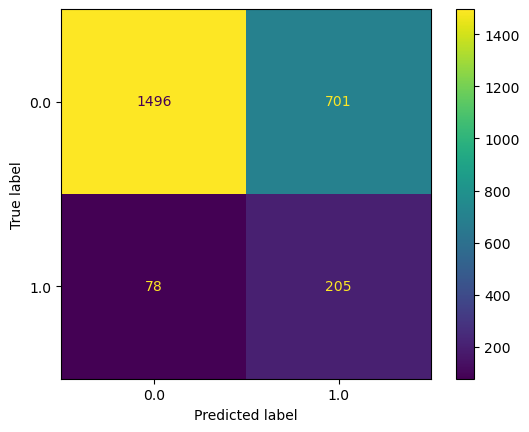

In [102]:
catBoost_best_model.fit(X_resampled, y_resampled)
y_pred = catBoost_best_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
ConfusionMatrixDisplay.from_predictions(y_test,y_pred)
print("\n"+ classification_report(y_test, y_pred))

In [103]:
# adaBoost = AdaBoostClassifier()
# adaBoost_params = {
#     'n_estimators': [50, 100, 200],
#     'learning_rate': [0.1, 0.5, 1.0]
# }
# adaBoost_grid = GridSearchCV(adaBoost, param_grid=adaBoost_params, cv=5)
# adaBoost_grid.fit(X_train, y_train)
# best_adaBoost = adaBoost_grid.best_estimator_
# best_adaBoost

In [104]:
# gradientBoosting = GradientBoostingClassifier()
# gradientBoosting_params = {
#     'n_estimators': [50, 100, 200],
#     'learning_rate': [0.1, 0.5, 1.0],
#     'max_depth': [3, 5, 7]
# }
# gradientBoosting_grid = GridSearchCV(gradientBoosting, param_grid=gradientBoosting_params, cv=5)
# gradientBoosting_grid.fit(X_train, y_train)
# best_gradientBoosting = gradientBoosting_grid.best_estimator_
# print(best_gradientBoosting)

In [105]:
# lgbClassifier = lgb.LGBMClassifier()
# lgb_params = {
#     'n_estimators': [50, 100, 200],
#     'learning_rate': [0.1, 0.5, 1.0],
#     'max_depth': [3, 5, -1]
# }
# lgb_grid = GridSearchCV(lgbClassifier, lgb_params, cv=5)
# lgb_grid.fit(X_train, y_train)
# lgb_best_model = lgb_grid.best_estimator_
# lgb_best_model

In [106]:
# xgb_params = {
#     'n_estimators': [50, 100, 200],
#     'learning_rate': [0.1, 0.5, 1.0],
#     'max_depth': [3, 5, 7]
# }
# xgb_grid = GridSearchCV(xgbClassifier, xgb_params, cv=5)
# xgb_grid.fit(X_train, y_train)
# xgb_best_model = xgb_grid.best_estimator_

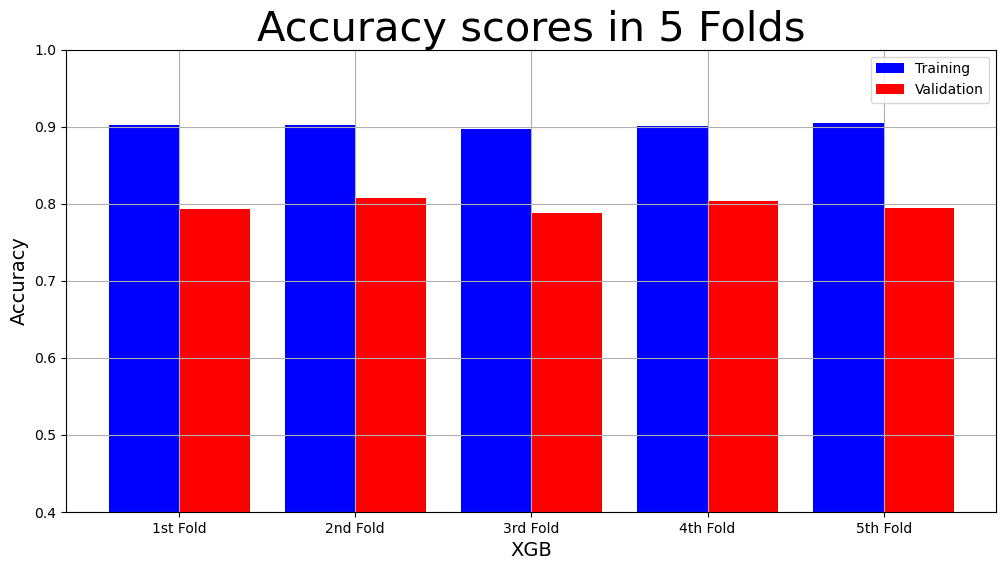

In [107]:
xgb_result = cross_validation(xgbClassifier, X_resampled, y_resampled, 5)
model_name = "XGB"
plot_result(model_name,
            "Accuracy",
            "Accuracy scores in 5 Folds",
            xgb_result["Training Accuracy scores"],
            xgb_result["Validation Accuracy scores"])

In [108]:
xgbClassifier.fit(X_resampled, y_resampled)
importances = xgbClassifier.feature_importances_
feature_importances = pd.DataFrame({'Feature': X_resampled.columns, 'Importance': importances})
feature_importances = feature_importances.sort_values('Importance', ascending=False)
print(feature_importances)
k = 5
selected_features = feature_importances.head(k)['Feature'].values
X_train_selected = X_resampled[selected_features]
X_test_selected = X_test[selected_features]
xgbClassifier_selected = xgb.XGBClassifier()
xgbClassifier_selected.fit(X_train_selected, y_resampled)
y_pred_select = xgbClassifier_selected.predict(X_test_selected)

   Feature  Importance
3        3    0.247853
0        0    0.221738
2        2    0.200438
1        1    0.181961
4        4    0.148010



              precision    recall  f1-score   support

         0.0       0.94      0.75      0.83      2197
         1.0       0.24      0.61      0.34       283

    accuracy                           0.74      2480
   macro avg       0.59      0.68      0.59      2480
weighted avg       0.86      0.74      0.78      2480



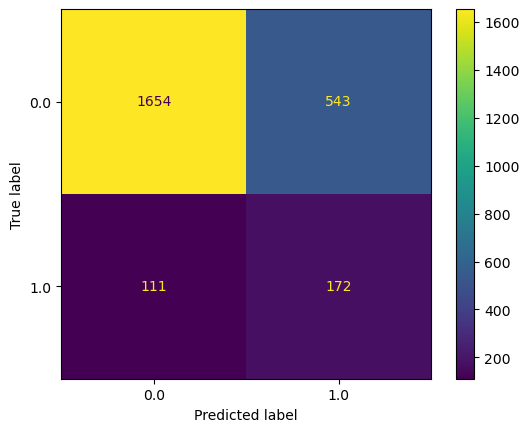

In [109]:
ConfusionMatrixDisplay.from_predictions(y_test,y_pred_select)
print("\n"+ classification_report(y_test, y_pred_select))

In [110]:
# with open('model_xgb.pkl', 'wb') as file:
#     pickle.dump(xgbClassifier_selected, file)

In [111]:
min_max_scaler = MinMaxScaler(feature_range =(0, 1))
X_rescaled = min_max_scaler.fit_transform(X_work)
print ("\nAfter min max Scaling : \n", X_rescaled)
pca = PCA(n_components = 0.95)
pca.fit(X_rescaled)
X_pca = pca.transform(X_rescaled)
X_pca=pd.DataFrame(X_pca)
X_train,X_test,y_train,y_test=train_test_split(X_pca,y_work,test_size=0.4,random_state=42,stratify=y_work)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)


After min max Scaling : 
 [[1.         0.25       0.16470588 ... 0.10169492 0.         0.        ]
 [1.         0.25       0.02352941 ... 0.11864407 0.         0.        ]
 [1.         0.41071429 0.17647059 ... 0.11864407 0.         0.        ]
 ...
 [1.         0.07142857 0.23529412 ... 0.13559322 0.         0.        ]
 [1.         0.07142857 0.31764706 ... 0.15254237 0.         1.        ]
 [0.         0.35714286 0.50588235 ... 0.         0.         1.        ]]



              precision    recall  f1-score   support

         0.0       0.93      0.66      0.77      4341
         1.0       0.22      0.66      0.33       618

    accuracy                           0.66      4959
   macro avg       0.57      0.66      0.55      4959
weighted avg       0.84      0.66      0.71      4959



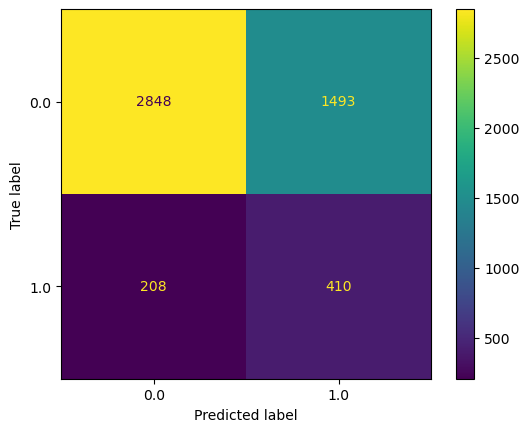

In [121]:
from sklearn import svm
svm_classifier = svm.SVC(kernel='rbf')

# Fit the classifier to the training data
svm_classifier.fit(X_resampled, y_resampled)

# Make predictions on the testing data
y_pred = svm_classifier.predict(X_test)

# Calculate the accuracy of the model
ConfusionMatrixDisplay.from_predictions(y_test,y_pred)
print("\n"+ classification_report(y_test, y_pred))

In [115]:
len(X_work.columns)

9

Best Gamma: 10

              precision    recall  f1-score   support

         0.0       0.94      0.62      0.75      4341
         1.0       0.21      0.71      0.33       618

    accuracy                           0.63      4959
   macro avg       0.57      0.67      0.54      4959
weighted avg       0.85      0.63      0.70      4959



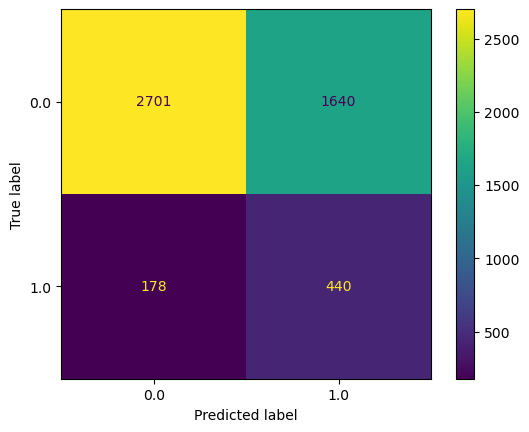

In [122]:
# param_grid = {'gamma': [0.1, 1, 10]}

# # Perform grid search using cross-validation
# grid_search = GridSearchCV(estimator=svm_classifier, param_grid=param_grid, cv=5)
# grid_search.fit(X_resampled, y_resampled)
# best_gamma = grid_search.best_params_['gamma']
# best_svm_classifier = svm.SVC(kernel='rbf', gamma=best_gamma)
# best_svm_classifier.fit(X_resampled, y_resampled)

# y_pred = best_svm_classifier.predict(X_test)

# # Calculate the accuracy of the model
# print("Best Gamma:", best_gamma)
# ConfusionMatrixDisplay.from_predictions(y_test,y_pred)
# print("\n"+ classification_report(y_test, y_pred))

## Kernel Trick

### Incercam sa impartim clientii in 3 clase,clienti ideali, cu intarzieri, dar nu critice, si clienti cu intarzieri critice

In [127]:
df.columns

Index(['Gender', 'Age', 'CreditLimit', 'State', 'score', 'ProbabilityOfModel',
       'DeclIncome', 'ANAFIncome', 'TotalLoanPayments', 'BNR40Available',
       'CreditsBefore', 'OfferCrab', 'OfferPenguin', 'OfferDolphin',
       'CrabIgnoringBNR', 'PenguinIgnoringBNR', 'DolphinIgnoringBNR',
       'ClientCategory', 'Comission', 'Withdrawed', 'PaidTotal', 'FutureTotal',
       'Crab', 'Dolphin', 'Penguin', 'durata_contract', 'target'],
      dtype='object')

In [132]:
df_new.loc[df_new['DpdDiffDaysMax'] <=0]
# y_pinguin = df_total.loc[df_total['Produs'] == 2, 'State']
# y_delfin=df_total.loc[df_total['Produs'] == 1, 'State']

1      index            CNP Age         DataSemnarii           DataInchis  \
0          2  1900226063350  32  2021-10-15 18:37:54  2021-10-16 18:11:03   
1          3  1900226063350  32  2021-11-06 03:38:12  2021-12-10 12:29:02   
3          5  2821224845270  40  2021-10-17 10:21:42  2021-12-08 11:55:03   
4          6  1890122104070  33  2021-10-15 08:49:02  2021-12-04 10:04:03   
5          7  2971008700226  25  2021-10-18 09:25:04  2022-01-12 09:56:02   
...      ...            ...  ..                  ...                  ...   
12511  12513  2950115066460  27  2022-09-02 14:17:42                  NaN   
12512  12514  1980503571385  24  2022-09-02 14:52:56                  NaN   
12513  12515  5001230076020  22  2022-09-02 15:59:01  2022-09-02 16:20:06   
12514  12516  5001230076020  22  2022-09-02 16:26:47                  NaN   
12515  12517  2841010148450  38  2022-09-02 16:40:21                  NaN   

1          Number   Produs CreditLimit   State          scoringdate  ...  \
0      DK53851057  Penguin        1900  Inchis  2021-10-15 00:31:13  ...   
1      TC42768422  Penguin         700  Inchis  2021-10-15 00:31:13  ...   
3      CL14119436  Penguin         700  Inchis  2021-10-15 08:26:57  ...   
4      XJ11096426     Crab         900  Inchis  2021-10-15 08:43:58  ...   
5      CX68136386  Penguin        1300  Inchis  2021-10-15 08:47:38  ...   
...           ...      ...         ...     ...                  ...  ...   
12511  HF65764739  Penguin        2400   Activ  2022-09-02 14:07:10  ...   
12512  RK14094581  Penguin        2400   Activ  2022-09-02 14:11:41  ...   
12513  XT65878045  Penguin        2500  Inchis  2022-09-02 15:56:48  ...   
12514  DG69685597  Dolphin        3200   Activ  2022-09-02 15:56:48  ...   
12515  WG16202485  Dolphin        4800   Activ  2022-09-02 16:12:04  ...   

1     PenguinIgnoringBNR DolphinIgnoringBNR ClientCategory Comission  \
0                      0                  0              0         0   
1                      0                  0              0         0   
3                      0                  0              0         0   
4                      0                  0              0         0   
5                      0                  0              0         0   
...                  ...                ...            ...       ...   
12511               2400                  0              3         9   
12512               3000               3200              3         9   
12513               2800               3200              3         9   
12514               2800               3200              3         9   
12515               2400               4800              2         7   

1     Withdrawed DpdDiffDaysMax DpdTotal PaidTotal FutureTotal  \
0          -1900            -27        0   1907.56           0   
1           -700            -22        0    783.58           0   
3           -700             -5        0    783.58           0   
4           -900             -8        0      1185           0   
5          -1300              0        0   1455.22           0   
...          ...            ...      ...       ...         ...   
12511      -2400              0        0         0     2996.16   
12512      -2400              0        0         0     2996.16   
12513      -2500            -28        0   2509.98           0   
12514      -3200              0        0         0        3200   
12515      -2800              0        0         0        2800   

1     IsDerrogationBNR  
0                  NaN  
1                  NaN  
3                  NaN  
4                  NaN  
5                  NaN  
...                ...  
12511             True  
12512              NaN  
12513              NaN  
12514              NaN  
12515              NaN  

[8834 rows x 31 columns]

In [156]:
df_new.loc[df_new['DpdDiffDaysMax'] <=0,'target']=0 # clienti exemplari
#df_new.loc[(df_new['DpdDiffDaysMax'] > 0) and (df_new['DpdDiffDaysMax'] < 30) ,'target']=1 # clienti un pic riscanti
df_new.loc[df_new['DpdDiffDaysMax'] >=30,'target']=2 # clienti riscanti

In [157]:
#df_new.loc[(df_new['DpdDiffDaysMax'] > 0) and (df_new['DpdDiffDaysMax'] < 30) ,'target']=1 # clienti
df_new.loc[(df_new['DpdDiffDaysMax'] >0) & (df_new['DpdDiffDaysMax'] < 30), 'target']=1    

In [176]:
df_new.shape
X_new=df_new.drop('target',axis=1)
y_new=df_new['target']

In [177]:
X_new=X_new.drop(['scoringdate','IsDerrogationBNR','DataSemnarii', 'DataInchis','index','CNP','Number','BNR40Available','OfferCrab','OfferPenguin', 'OfferDolphin','State','ProbabilityOfModel','DeclIncome','ClientCategory', 'Comission', 'Withdrawed', 'PaidTotal', 'FutureTotal','CrabIgnoringBNR','DolphinIgnoringBNR','PenguinIgnoringBNR'],axis=1)    

In [178]:
dummy_df = pd.get_dummies(X_new['Produs'])
X_new= pd.concat([X_new, dummy_df], axis=1)
X_new=X_new.drop("Produs",axis=1)

In [179]:
X_new.columns

Index(['Age', 'CreditLimit', 'score', 'ANAFIncome', 'TotalLoanPayments',
       'CreditsBefore', 'DpdDiffDaysMax', 'DpdTotal', 'Crab', 'Dolphin',
       'Penguin'],
      dtype='object')

In [183]:
X_rescaled = min_max_scaler.fit_transform(X_new)
print ("\nAfter min max Scaling : \n", X_rescaled)
pca = PCA(n_components = 0.95)
pca.fit(X_rescaled)
X_pca = pca.transform(X_rescaled)
X_pca=pd.DataFrame(X_pca)
X_train,X_test,y_train,y_test=train_test_split(X_pca,y_new,test_size=0.4,random_state=42,stratify=y_new)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)


After min max Scaling : 
 [[0.25       0.16470588 0.73842303 ... 0.         0.         1.        ]
 [0.25       0.02352941 0.73842303 ... 0.         0.         1.        ]
 [0.41071429 0.17647059 0.76220275 ... 0.         0.         1.        ]
 ...
 [0.07142857 0.23529412 0.60325407 ... 0.         0.         1.        ]
 [0.07142857 0.31764706 0.60325407 ... 0.         1.         0.        ]
 [0.35714286 0.50588235 0.73842303 ... 0.         1.         0.        ]]



              precision    recall  f1-score   support

         0.0       0.91      0.80      0.85      3534
         1.0       0.41      0.62      0.49       808
         2.0       0.97      0.96      0.97       665

    accuracy                           0.79      5007
   macro avg       0.76      0.79      0.77      5007
weighted avg       0.83      0.79      0.81      5007



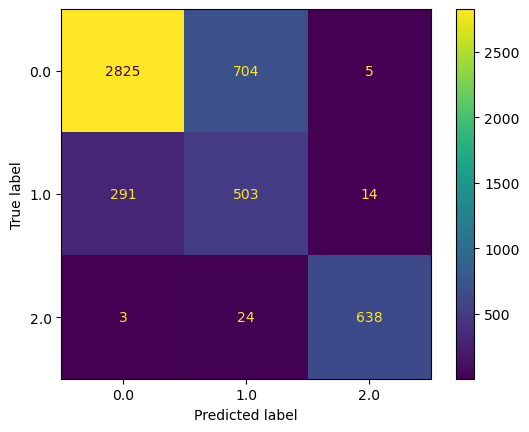

In [185]:
lgb_classifier = lgb.LGBMClassifier(random_state=42)
#model = lgb.train(params, train_data, valid_sets=[val_data])
lgb_classifier.fit(X_resampled,y_resampled)
y_pred = lgb_classifier_pinguin.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
ConfusionMatrixDisplay.from_predictions(y_test,y_pred)
print("\n"+ classification_report(y_test, y_pred))

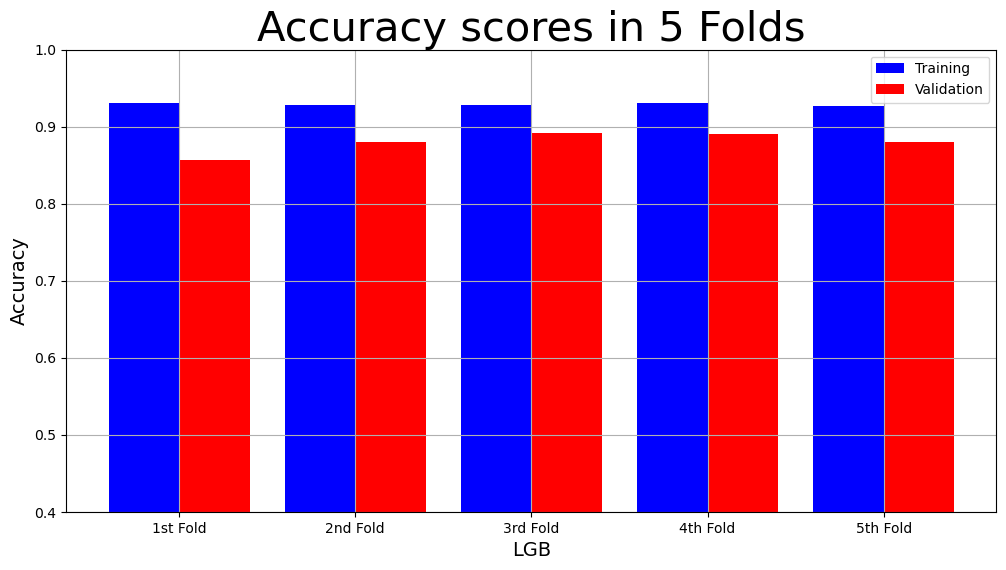

In [186]:
xgb_result = cross_validation(lgb_classifier, X_resampled, y_resampled, 5)
model_name = "LGB"
plot_result(model_name,
            "Accuracy",
            "Accuracy scores in 5 Folds",
            xgb_result["Training Accuracy scores"],
            xgb_result["Validation Accuracy scores"])